In [144]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as optimize

In [146]:
import numpy as np
import matplotlib.pyplot as plt
import yt
import math
from matplotlib import ticker
from colormap import rgb2hex                         # keep if you prefer it
# NEW ────────────────────────────────────────────────────────────────────────
# axes_grid → axes_grid1   (same functionality, maintained sub-package)
from mpl_toolkits.axes_grid1.inset_locator import (
    inset_axes, InsetPosition, mark_inset
)
# ────────────────────────────────────────────────────────────────────────────

# --------------------------------------------------------------------------
# Matplotlib global style
# --------------------------------------------------------------------------
plt.rc("text", usetex=False)
plt.rc("font", size=12)
plt.rc("axes", titlesize=60)
plt.rcParams.update({
    "legend.fontsize": 12,
    "lines.markersize": 5,
    "lines.markeredgecolor": "k",
    "lines.markeredgewidth": 0.2,
    "lines.linewidth": 1.0,
})

formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-1, 1))

# --------------------------------------------------------------------------
# Plot parameters
# --------------------------------------------------------------------------
aspect = 1.0

# Custom colour palette (red → blue gradient)
ncol = 5
red  = np.array([254,   0,   2], dtype=int)
blue = np.array([  3,   2, 252], dtype=int)

c1 = np.linspace(red[0],  blue[0],  ncol, dtype=int)
c2 = np.linspace(red[1],  blue[1],  ncol, dtype=int)
c3 = np.linspace(red[2],  blue[2],  ncol, dtype=int)

colors = [rgb2hex(r, g, b) for r, g, b in zip(c1, c2, c3)][::-1]

In [147]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from scipy.stats import multivariate_normal


### === Preprocessing Utilities === ###

def preprocess_data(Z, eps=1e-8):
    Z_proc = np.empty_like(Z, dtype=np.float64)
    Z_proc[:, 0] = np.log(Z[:, 0])  # log(r)
    Z_clipped = np.clip(Z[:, 1:], eps, 1.0 - eps)
    Z_proc[:, 1:] = np.log(Z_clipped / (1.0 - Z_clipped))  # logit(ε)
    return Z_proc

def inverse_preprocess_data(Z_proc):
    Z = np.empty_like(Z_proc, dtype=np.float64)
    Z[:, 0] = np.exp(Z_proc[:, 0])
    Z[:, 1:] = 1.0 / (1.0 + np.exp(-Z_proc[:, 1:]))  # sigmoid
    return Z

In [148]:
### === Data Loader === ###

def load_single_r_data(folder_r):
    ef_file = os.path.join(folder_r, "Ef.txt")
    E_data = np.loadtxt(ef_file)

    folder_name = os.path.basename(folder_r)
    i_r = int(folder_name[1:])
    r_val = 0.1 * i_r

    pre_energy  = E_data[:, 0] + E_data[:, 1] + E_data[:, 2]
    post_energy = E_data[:, 3] + E_data[:, 4] + E_data[:, 5]
    E_rot       = E_data[:, 1] + E_data[:, 2]
    E_rot_prime = E_data[:, 4] + E_data[:, 5]

    epsilon_tr          = E_data[:, 0] / pre_energy
    epsilon_tr_prime    = E_data[:, 3] / post_energy
    epsilon_rot_1       = E_data[:, 1] / E_rot
    epsilon_rot_1_prime = E_data[:, 4] / E_rot_prime

    r_column = np.full_like(epsilon_tr, r_val)
    return np.column_stack((r_column, epsilon_tr, epsilon_rot_1, epsilon_tr_prime, epsilon_rot_1_prime))

def load_all_data(base_dir, r_range=range(1, 13)):
    all_data = []
    for i in r_range:
        folder = os.path.join(base_dir, f"r{i:02d}")
        all_data.append(load_single_r_data(folder))
    return np.vstack(all_data)

In [149]:
### === GMM BIC Selection === ###

def find_best_gmm_bic(Z_scaled, max_components=40, random_state=42, covariance_type='full'):
    lowest_bic = np.inf
    best_n = None
    bics = []

    for n in range(1, max_components + 1):
        gmm = GaussianMixture(n_components=n, covariance_type=covariance_type, random_state=random_state)
        gmm.fit(Z_scaled)
        bic = gmm.bic(Z_scaled)
        bics.append(bic)
        if bic < lowest_bic:
            best_n = n
            lowest_bic = bic

    plt.plot(range(1, max_components + 1), bics, marker='o')
    plt.xlabel("Number of Components")
    plt.ylabel("BIC Score")
    plt.title("GMM BIC Model Selection")
    plt.grid(True)
    plt.show()

    print(f"Best n_components: {best_n}, BIC: {lowest_bic:.2f}")
    return best_n, bics

In [150]:
### === GMM Sampling === ###

def conditional_gmm_sample_scaled(gmm, x_scaled, D_x=3, D_y=2):
    weights, means, covs = gmm.weights_, gmm.means_, gmm.covariances_
    M = len(weights)

    alphas = np.array([
        weights[m] * multivariate_normal.pdf(x_scaled, mean=means[m][:D_x], cov=covs[m][:D_x, :D_x])
        for m in range(M)
    ])
    alphas /= np.sum(alphas) if np.sum(alphas) > 1e-30 else np.ones(M) / M
    m = np.random.choice(np.arange(M), p=alphas)

    mu_x, mu_y = means[m][:D_x], means[m][D_x:]
    Sigma_xx = covs[m][:D_x, :D_x]
    Sigma_xy = covs[m][:D_x, D_x:]
    Sigma_yx = covs[m][D_x:, :D_x]
    Sigma_yy = covs[m][D_x:, D_x:]

    mu_cond = mu_y + Sigma_yx @ np.linalg.inv(Sigma_xx) @ (x_scaled - mu_x)
    Sigma_cond = Sigma_yy - Sigma_yx @ np.linalg.inv(Sigma_xx) @ Sigma_xy
    return np.random.multivariate_normal(mean=mu_cond, cov=Sigma_cond)

def sample_conditionals(gmm, scaler, r, e_tr, e_r1, n_samples=1):
    samples = []
    for _ in range(n_samples):
        z_unscaled = np.array([r, e_tr, e_r1, 0.0, 0.0])
        z_proc = preprocess_data(z_unscaled.reshape(1, -1))
        z_scaled = scaler.transform(z_proc)
        y_scaled = conditional_gmm_sample_scaled(gmm, z_scaled[0, :3])
        z_scaled[0, 3:] = y_scaled
        z_proc_new = scaler.inverse_transform(z_scaled)
        z_unscaled_new = inverse_preprocess_data(z_proc_new)
        samples.append(z_unscaled_new[0, 3:])
    return np.array(samples)

In [151]:
import pandas as pd
### === VALIDATION FUNCTION === ###

def run_gmm_validation(base_dir, gmm, scaler, r_input=0.5, n_samples=20000):
    i_r = int(round(r_input * 10))
    folder_r = os.path.join(base_dir, f"r{i_r:02d}")
    Z_real = load_single_r_data(folder_r)

    # Use true ε_tr, ε_r1 as inputs
    epsilon_tr_vals = Z_real[:, 1]
    epsilon_r1_vals = Z_real[:, 2]
    true_epsilon_tr_prime = Z_real[:, 3]
    true_epsilon_r1_prime = Z_real[:, 4]

    # Sample subset if data is more than needed
    total = len(Z_real)
    if total > n_samples:
        idx = np.random.choice(total, size=n_samples, replace=False)
    else:
        idx = np.arange(total)

    predictions = []
    for i in idx:
        etr = epsilon_tr_vals[i]
        er1 = epsilon_r1_vals[i]
        pred = sample_conditionals(gmm, scaler, r_input, etr, er1, n_samples=1)[0]
        predictions.append(pred)
    predictions = np.array(predictions)

    # Ground truth for same indices
    etr_prime_real = true_epsilon_tr_prime[idx]
    er1_prime_real = true_epsilon_r1_prime[idx]
    etr_prime_pred = predictions[:, 0]
    er1_prime_pred = predictions[:, 1]

    # Plot comparison
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    axs[0].hist(etr_prime_real, bins=100, alpha=0.6, label='True')
    axs[0].hist(etr_prime_pred, bins=100, alpha=0.6, label='GMM')
    axs[0].set_title(r"$\epsilon_{tr}'$")
    axs[0].legend()

    axs[1].hist(er1_prime_real, bins=100, alpha=0.6, label='True')
    axs[1].hist(er1_prime_pred, bins=100, alpha=0.6, label='GMM')
    axs[1].set_title(r"$\epsilon_{r1}'$")
    axs[1].legend()

    plt.suptitle(f"GMM Validation vs Ground Truth for r = {r_input}")
    plt.tight_layout()
    plt.grid(True)
    plt.show()

    stats_df = pd.DataFrame({
        "Stat": ["Mean", "Std Dev"],
        "E_tr'_real": [np.mean(etr_prime_real), np.std(etr_prime_real)],
        "E_tr'_pred": [np.mean(etr_prime_pred), np.std(etr_prime_pred)],
        "E_r1'_real": [np.mean(er1_prime_real), np.std(er1_prime_real)],
        "E_r1'_pred": [np.mean(er1_prime_pred), np.std(er1_prime_pred)]
    })

    return stats_df

In [178]:
# Load and preprocess data
base_dir = "/home/muhammed/Documents/Thesis/New Simulations/GMM2/AR11"
bigZ = load_all_data(base_dir)

# Preprocess
bigZ_proc = preprocess_data(bigZ)
scaler = StandardScaler().fit(bigZ_proc)
bigZ_scaled = scaler.transform(bigZ_proc)

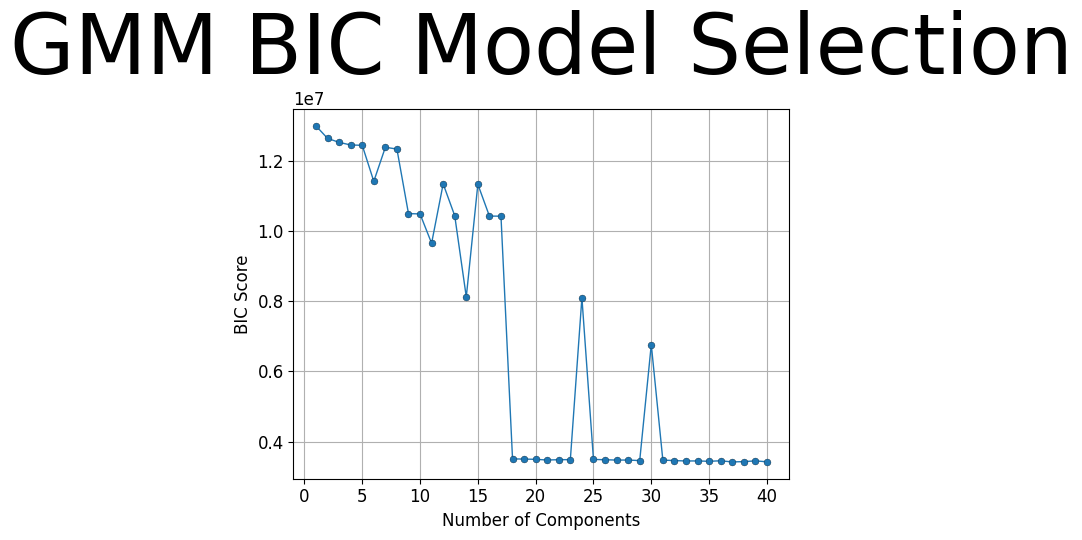

Best n_components: 37, BIC: 3418582.99


In [218]:
# Train GMM
n_best, bics = find_best_gmm_bic(bigZ_scaled, max_components=40)

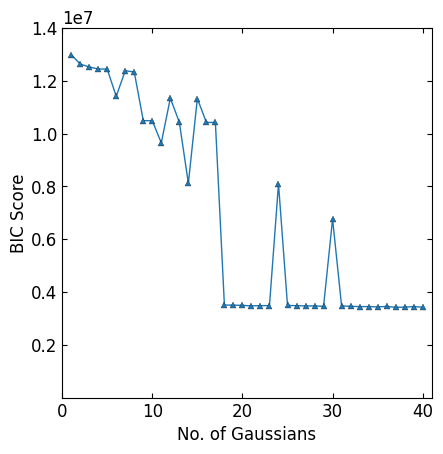

In [225]:
fig,ax = plt.subplots();
ax.plot(range(1, 41), bics, marker='^')

ax.set_xlim([0,41])
ax.set_ylim([0.2,1.4e7])
xval, yval = ax.get_xlim(), ax.get_ylim()
xrange = xval[1]-xval[0];
yrange = yval[1]-yval[0];
ax.set_aspect(aspect*(xrange/yrange), adjustable='box')
ax.set_xlabel("No. of Gaussians")
ax.set_ylabel("BIC Score",labelpad=+2)
ax.tick_params(axis='both',direction='in',which='both',right=True,top=True)

mng = plt.get_current_fig_manager()
mng.full_screen_toggle()
plt.savefig('SIC.pdf',bbox_inches='tight')
plt.show()

In [179]:
gmm_model = GaussianMixture(n_components=32, covariance_type='full', random_state=42)
gmm_model.fit(bigZ_scaled)

GaussianMixture(n_components=32, random_state=42)

In [950]:
# Sampling conditionals
samples = sample_conditionals(gmm_model, scaler, r=0.60, e_tr=0.645, e_r1=0.251, n_samples=1)
print("Sampled [e_tr', e_r1']:\n", samples)

Sampled [e_tr', e_r1']:
 [[0.76992674 0.88641299]]


In [329]:
epsilon_tr_p = samples[0, 0]
epsilon_r1_p = samples[0, 1]

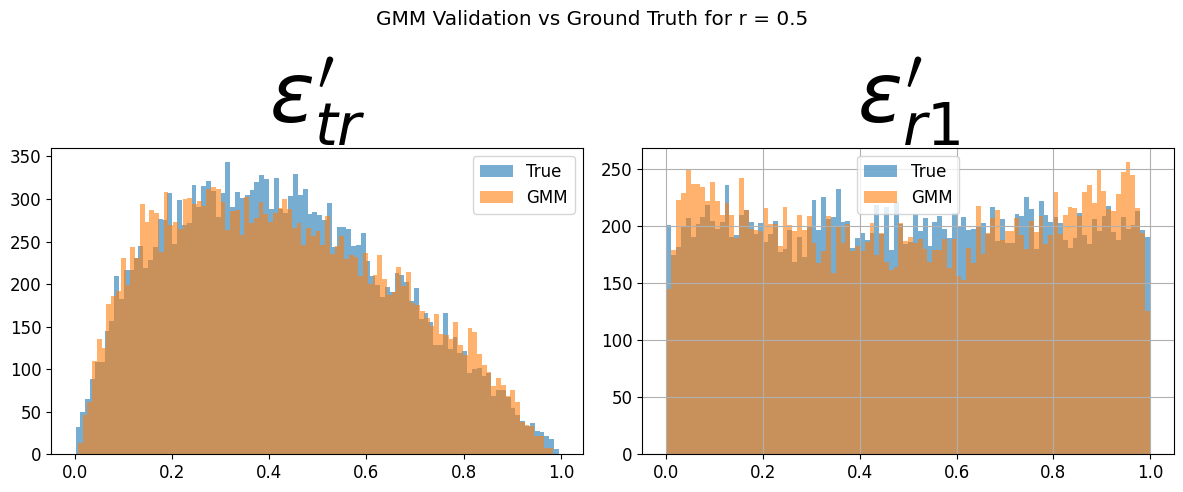

      Stat  E_tr'_real  E_tr'_pred  E_r1'_real  E_r1'_pred
0     Mean    0.426231    0.426898    0.500881    0.500708
1  Std Dev    0.220982    0.227076    0.288450    0.296834


In [1146]:
stats = run_gmm_validation(base_dir, gmm_model, scaler, r_input=0.5, n_samples=20000)
print(stats)

In [ ]:
import numpy as np

# Z_real columns assumed: [r, e_tr, e_r1, e_tr_prime, e_r1_prime]
Z_real = np.loadtxt("Z_real_r05.txt")   # <-- whatever file you already use/load

e_tr = Z_real[:, 1]
e_r1 = Z_real[:, 2]

np.savetxt("inputs_r05.txt", np.column_stack([e_tr, e_r1]), fmt="%.10e")
print("Wrote inputs_r05.txt with", len(e_tr), "rows")

In [154]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.stats import gaussian_kde

from scipy.stats import gaussian_kde
import matplotlib.colors as mcolors

def density_scatter(ax, x, y, xlabel, ylabel, cmap='turbo', s=1, alpha=0.8, fit_line=True):
    from scipy.stats import linregress
    from matplotlib.ticker import FixedLocator
    xy = np.vstack([x, y])
    kde = gaussian_kde(xy)
    z = kde(xy)
    idx = np.argsort(z)
    x, y, z = x[idx], y[idx], z[idx]

    sc = ax.scatter(x, y, c=z, s=s, cmap=cmap, edgecolors='none', alpha=1.0)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xticks([0.0, 0.5, 1.0])
    ax.set_yticks([0.0, 0.5, 1.0])
    #ax.set_xlabel(xlabel)
    #ax.set_ylabel(ylabel, fontsize=14)
    ax.set_title("GMM", fontsize=14)
    
    # Line of best fit
    if fit_line:
        slope, intercept, _, _, _ = linregress(x, y)
        x_fit = np.array([0, 1])
        y_fit = 1 * x_fit + 0.0
        ax.plot(x_fit, y_fit, 'r--', lw=2)
        
    return sc


In [183]:
r_input = 0.5
n_samples = 20000
i_r = int(round(r_input * 10))
folder_r = os.path.join(base_dir, f"r{i_r:02d}")
Z_real = load_single_r_data(folder_r)

eps_tr = Z_real[:, 1]
eps_r1 = Z_real[:, 2]
eps_tr_p_true = Z_real[:, 3]
eps_r1_p_true = Z_real[:, 4]

total = len(Z_real)
idx = np.random.choice(total, size=min(total, n_samples), replace=False)

predictions = []
for i in idx:
    etr = eps_tr[i]
    er1 = eps_r1[i]
    pred = sample_conditionals(gmm_model, scaler, r_input, etr, er1, n_samples=1)[0]
    predictions.append(pred)
predictions = np.array(predictions)
eps_tr_p_pred = predictions[:, 0]
eps_r1_p_pred = predictions[:, 1]

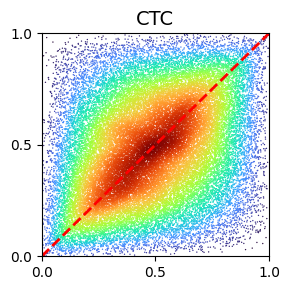

Saved: /home/muhammed/Documents/Thesis/New Simulations/figs/etr_CTC_corr.eps


In [564]:
save_dir="/home/muhammed/Documents/Thesis/New Simulations/figs"
os.makedirs(save_dir, exist_ok=True)

fig, ax = plt.subplots(figsize=(3, 3))
density_scatter(ax, eps_tr[idx], eps_tr_p_true[idx], r"$\epsilon_{tr}$", r"$\epsilon_{tr}'$")
plt.tight_layout()
save_path = os.path.join(save_dir, f"etr_CTC_corr.eps")
plt.savefig(save_path, format='eps', bbox_inches='tight')
plt.show()
plt.close()
print(f"Saved: {save_path}")

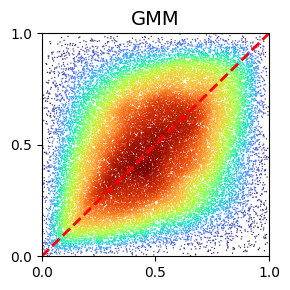

Saved: /home/muhammed/Documents/Thesis/New Simulations/figs/etr_GMM_corr.eps


In [603]:
fig, ax = plt.subplots(figsize=(3, 3))
density_scatter(ax, eps_tr[idx], eps_tr_p_pred, r"$\epsilon_{tr}$", r"$\epsilon_{tr}'$")
plt.tight_layout()
save_path = os.path.join(save_dir, f"etr_GMM_corr.eps")
plt.savefig(save_path, format='eps', bbox_inches='tight')
plt.show()
plt.close()
print(f"Saved: {save_path}")

In [ ]:
fig, ax = plt.subplots(figsize=(3, 3))
density_scatter(ax, eps_r1[idx], eps_r1_p_true[idx], r"$\epsilon_{tr}$", r"$\epsilon_{tr}'$")
plt.tight_layout()
save_path = os.path.join(save_dir, f"etr_CTC_corr.eps")
plt.savefig(save_path, format='eps', bbox_inches='tight')
plt.show()
plt.close()
print(f"Saved: {save_path}")

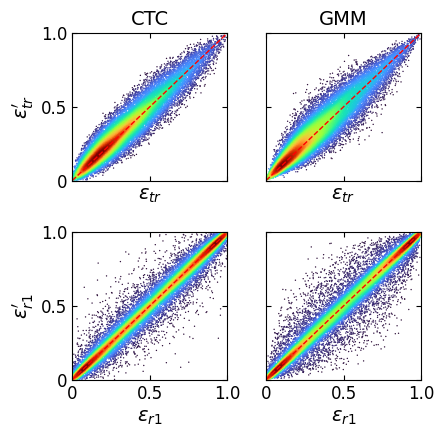

Saved: /home/muhammed/Documents/Thesis/New Simulations/figs/AR11_theta_05_corr.png


In [185]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde, linregress

save_dir="/home/muhammed/Documents/Thesis/New Simulations/figs"
os.makedirs(save_dir, exist_ok=True)

def density_scatter(ax, x, y, cmap='turbo', s=1, alpha=1.0, fit_line=True):
    xy = np.vstack([x, y])
    kde = gaussian_kde(xy)
    z = kde(xy)
    idx = np.argsort(z)
    x, y, z = x[idx], y[idx], z[idx]

    sc = ax.scatter(x, y, c=z, s=s, cmap=cmap, edgecolors='none', alpha=alpha)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xticks([0.0, 0.5, 1.0])
    ax.set_yticks([0.0, 0.5, 1.0])

    if fit_line:
        ax.plot([0, 1], [0, 1], 'r--', lw=1.0)  # Identity line

    return sc

N_gmm = len(eps_tr_p_pred)
eps_tr_cut = eps_tr[:N_gmm]
eps_r1_cut = eps_r1[:len(eps_r1_p_pred)]

from matplotlib.ticker import FuncFormatter
# ---- 2x2 Plot Grid ----
fig, axs = plt.subplots(2, 2, figsize=(4.5, 4.5), sharex=True, sharey=True)

# Custom formatter: return '0' for 0, otherwise default formatting
formatter1 = FuncFormatter(lambda x, _: '0' if x == 0 else f'{x:.1f}')
formatter2 = FuncFormatter(lambda x, _: '0' if x == 0 else f'{x:.1f}')


# Top row: ε_tr'
density_scatter(axs[0, 0], eps_tr[idx], eps_tr_p_true[idx])
density_scatter(axs[0, 1], eps_tr[idx], eps_tr_p_pred)

# Bottom row: ε_r1'
density_scatter(axs[1, 0], eps_r1[idx], eps_r1_p_true[idx])
density_scatter(axs[1, 1], eps_r1[idx], eps_r1_p_pred)

# Left labels
axs[0, 0].set_ylabel(r"$\epsilon_{tr}'$", fontsize=14)
axs[1, 0].set_ylabel(r"$\epsilon_{r1}'$", fontsize=14)

# Top titles
axs[0, 0].set_title("CTC", fontsize=14)
axs[0, 1].set_title("GMM", fontsize=14)

# X-labels
axs[1, 0].set_xlabel(r"$\epsilon_{r1}$", fontsize=14)
axs[1, 1].set_xlabel(r"$\epsilon_{r1}$", fontsize=14)
axs[0, 0].set_xlabel(r"$\epsilon_{tr}$", fontsize=14)
axs[0, 1].set_xlabel(r"$\epsilon_{tr}$", fontsize=14)

# Hide all x-labels
for ax in axs.flat:
    #ax.set_xlabel("")
    #ax.label_outer()
    ax.tick_params(axis='both',direction='in',which='both',right=True,top=True)
    ax.yaxis.set_major_formatter(formatter1)
    ax.xaxis.set_major_formatter(formatter2)

#plt.tight_layout(pad=0.8)
plt.subplots_adjust(hspace=0.35, wspace=0.25)
save_path = os.path.join(save_dir, "AR11_theta_05_corr.png")
plt.savefig(save_path, format='png', bbox_inches='tight')
plt.show()
plt.close()
print(f"Saved: {save_path}")

In [163]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma
from scipy.integrate import simps

# Same feq_eps and normalize as before...
def feq_eps(eps_tr, theta):
    zeta_tr, zeta_rot = 4, 4
    Ttr, Trot = 1.0, 1.0 / theta
    norm = gamma((zeta_tr + zeta_rot) / 2) / (gamma(zeta_tr / 2) * gamma(zeta_rot / 2))
    density = (eps_tr**(zeta_tr / 2 - 1)) * ((1 - eps_tr)**(zeta_rot / 2 - 1))
    scale = (eps_tr / Ttr + (1 - eps_tr) / Trot)**(-(zeta_tr + zeta_rot) / 2)
    return norm * density * scale

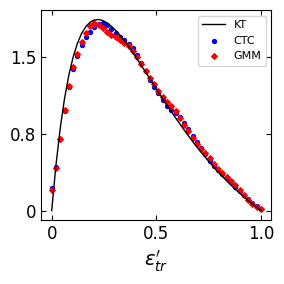

Saved: /home/muhammed/Documents/Thesis/New Simulations/figs/PDFAR11_theta05.pdf


In [187]:
from matplotlib.ticker import FuncFormatter

# Custom formatter: return '0' for 0, otherwise default formatting
formatter1 = FuncFormatter(lambda x, _: '0' if x == 0 else f'{x:.1f}')
formatter2 = FuncFormatter(lambda x, _: '0' if x == 0 else f'{x:.1f}')

fig, ax = plt.subplots(figsize=(3, 3))


x_plot = np.linspace(0, 1, 50)
kde_true = gaussian_kde(eps_tr_p_true[idx])
kde_pred = gaussian_kde(eps_tr_p_pred)

# Plot Kinetic Theory
theta = 0.5
kt_pdf = feq_eps(x_plot, theta)
kt_pdf /= np.trapz(kt_pdf, x_plot)
ax.plot(x_plot, kt_pdf, color='black', linestyle='-', linewidth=1.0, label="KT")

# Plot CTC KDE
ax.scatter(x_plot, kde_true(x_plot), marker='o', color='blue', s=8, label="CTC")

# Plot GMM
ax.scatter(x_plot, kde_pred(x_plot), marker='D', color='red', s=8, label="GMM")


# Ticks and labels
ax.set_xticks([0, 0.5, 1.0])
ax.set_yticks([0, 0.75, 1.5])
ax.set_xlabel(r"$\epsilon_{tr}'$", fontsize=14)
ax.yaxis.set_major_formatter(formatter1)
ax.xaxis.set_major_formatter(formatter2)
ax.tick_params(axis='both',direction='in',which='both',right=True,top=True)
#ax.set_ylabel("PDF")
ax.legend(fontsize=8)
plt.tight_layout()

# Save
save_path = os.path.join(save_dir, f"PDFAR11_theta05.pdf")
plt.savefig(save_path, format='pdf', bbox_inches='tight')
plt.show()
plt.close()
print(f"Saved: {save_path}")

In [939]:
import numpy as np
import matplotlib.pyplot as plt
import yt
import math
from matplotlib import ticker
from colormap import rgb2hex                         # keep if you prefer it
# NEW ────────────────────────────────────────────────────────────────────────
# axes_grid → axes_grid1   (same functionality, maintained sub-package)
from mpl_toolkits.axes_grid1.inset_locator import (
    inset_axes, InsetPosition, mark_inset
)
# ────────────────────────────────────────────────────────────────────────────

# --------------------------------------------------------------------------
# Matplotlib global style
# --------------------------------------------------------------------------
plt.rc("text", usetex=False)
plt.rc("font", size=12)
plt.rc("axes", titlesize=60)
plt.rcParams.update({
    "legend.fontsize": 12,
    "lines.markersize": 5,
    "lines.markeredgecolor": "k",
    "lines.markeredgewidth": 0.2,
    "lines.linewidth": 1.0,
})

formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(False)
formatter.set_powerlimits((-1, 1))

# --------------------------------------------------------------------------
# Plot parameters
# --------------------------------------------------------------------------
aspect = 1.0

# Custom colour palette (red → blue gradient)
ncol = 5
red  = np.array([254,   0,   2], dtype=int)
blue = np.array([  3,   2, 252], dtype=int)

c1 = np.linspace(red[0],  blue[0],  ncol, dtype=int)
c2 = np.linspace(red[1],  blue[1],  ncol, dtype=int)
c3 = np.linspace(red[2],  blue[2],  ncol, dtype=int)

colors = [rgb2hex(r, g, b) for r, g, b in zip(c1, c2, c3)][::-1]

/tmp/ipykernel_266850/2026400066.py:24: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  return fx / simps(fx, x)
/tmp/ipykernel_266850/2026400066.py:29: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  return simps(f[mask] * np.log(f[mask] / g[mask]), x[mask])


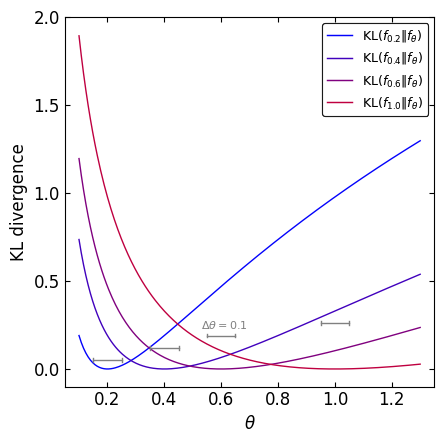

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma
from scipy.integrate import simps

# Parameters
zeta_tr = 4
zeta_rot = 4
eps_tr = np.linspace(1e-5, 1 - 1e-5, 500)
theta_vals = np.linspace(0.1, 1.3, 300)
theta_refs = [0.2, 0.4, 0.6, 1.0]

# Distribution function
def feq_eps(eps_tr, theta):
    Ttr = 1.0
    Trot = Ttr / theta
    norm = gamma((zeta_tr + zeta_rot) / 2) / (gamma(zeta_tr / 2) * gamma(zeta_rot / 2))
    density = (eps_tr**(zeta_tr / 2 - 1)) * ((1 - eps_tr)**(zeta_rot / 2 - 1))
    scale = (eps_tr / Ttr + (1 - eps_tr) / Trot)**(-(zeta_tr + zeta_rot) / 2)
    return norm * density * scale

# Normalize a PDF
def normalize(fx, x):
    return fx / simps(fx, x)

# KL divergence
def kl_div(f, g, x):
    mask = (f > 0) & (g > 0)
    return simps(f[mask] * np.log(f[mask] / g[mask]), x[mask])

# Plot setup
fig,ax = plt.subplots();

# Compute KL curves for each reference
for i, theta_ref in enumerate(theta_refs):
    f_ref = normalize(feq_eps(eps_tr, theta_ref), eps_tr)
    kl_vals = []
    for theta in theta_vals:
        f_theta = normalize(feq_eps(eps_tr, theta), eps_tr)
        kl_vals.append(kl_div(f_ref, f_theta, eps_tr))
    ax.plot(theta_vals, kl_vals, label=fr'KL($f_{{{theta_ref}}} \| f_\theta$)', color=colors[i])
    
# Draw Δθ = 0.1 brackets for each reference θ
for i, theta_ref in enumerate(theta_refs):
    y_pos = 0.05 + 0.07 * i  # vertical stacking of arrows
    left = theta_ref - 0.05
    right = theta_ref + 0.05
    
    # Horizontal bracket line
    ax.plot([left, right], [y_pos, y_pos], color='gray', lw=1)
    # Vertical caps
    ax.plot([left, left], [y_pos - 0.01, y_pos + 0.01], color='gray', lw=1)
    ax.plot([right, right], [y_pos - 0.01, y_pos + 0.01], color='gray', lw=1)

# Annotate only one with Δθ = 0.1
ax.text(0.53, 0.01 + 0.055 * len(theta_refs), r'$\Delta \theta = 0.1$', fontsize=8, color='gray')
#plt.axvline(1.0, color='gray', linestyle='--', linewidth=1.0)
#plt.axvline(0.6, color='gray', linestyle='--', linewidth=1.0)
#plt.axvline(0.4, color='gray', linestyle='--', linewidth=1.0)
#plt.axvline(0.2, color='gray', linestyle='--', linewidth=1.0)
# Labels, legend, layout
ax.set_xlabel(r'$\theta$', fontsize=12)
ax.set_ylabel('KL divergence', fontsize=12)
ax.set_xlim([0.05,1.35])
ax.set_ylim([-0.1,2.0])
xval, yval = ax.get_xlim(), ax.get_ylim()
aspect= 1
xrange = xval[1]-xval[0];
yrange = yval[1]-yval[0];
ax.set_aspect(aspect*(xrange/yrange), adjustable='box')
ax.tick_params(axis='both',direction='in',which='both',right=True,top=True)
legend1 = ax.legend(
    loc='upper right',
    fontsize=9,
    frameon=True,
)
legend1.get_frame().set_edgecolor('black')
legend1.get_frame().set_linewidth(0.8)
ax.add_artist(legend1)

#ax.xticks([0.2, 0.4, 0.6, 0.8, 1.0, 1.2])
ax.set_yticks([0.0, 0.5, 1.0, 1.5, 2.0])

#ax.grid(True, linestyle='--', alpha=0.5)
mng = plt.get_current_fig_manager()
mng.full_screen_toggle()
save_path = os.path.join(save_dir, "KLD.png")
plt.savefig(save_path, format='png', bbox_inches='tight')
plt.show()

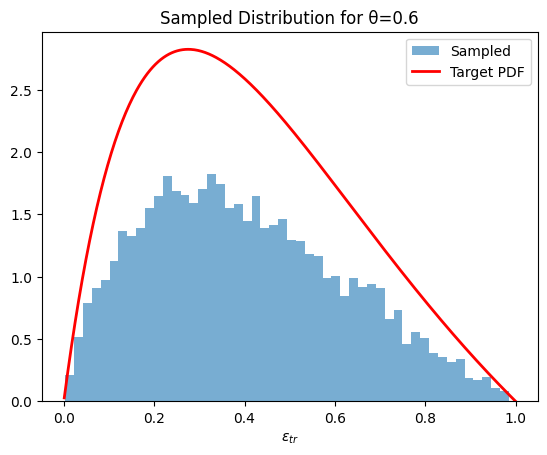

In [502]:
import numpy as np
from scipy.special import gamma
import matplotlib.pyplot as plt

import numpy as np
from scipy.special import gamma

def feq_eps(eps_tr, theta, k=1.0):
    zeta_tr, zeta_rot = 4, 4
    Ttr = 1.0
    Trot = 1.0 / theta

    A = gamma((zeta_tr + zeta_rot) / 2.0) / (gamma(zeta_tr / 2.0) * gamma(zeta_rot / 2.0))
    power = - (zeta_tr + zeta_rot) / 2.0

    num = eps_tr**(zeta_tr / 2.0 - 1.0) * (1.0 - eps_tr)**(zeta_rot / 2.0 - 1.0)
    denom = (k * Ttr) * (k * Trot)
    scale = (eps_tr / (k * Ttr) + (1.0 - eps_tr) / (k * Trot))**power

    return A * num * scale / denom


def sample_feq_eps(theta, num_samples=10000):
    samples = []
    max_pdf = None

    # Estimate the maximum of feq_eps for rejection bound
    eps_vals = np.linspace(1e-6, 1 - 1e-6, 1000)
    pdf_vals = feq_eps(eps_vals, theta)
    max_pdf = np.max(pdf_vals) * 1.1  # add safety margin

    while len(samples) < num_samples:
        x = np.random.uniform(0, 1)
        y = np.random.uniform(0, max_pdf)
        if y < feq_eps(x, theta):
            samples.append(x)
    return np.array(samples)

# Example usage
theta = 0.6
samples = sample_feq_eps(theta)

# Plot the sampled histogram and true PDF
x_vals = np.linspace(1e-3, 1-1e-3, 500)
plt.hist(samples, bins=50, density=True, alpha=0.6, label='Sampled')
plt.plot(x_vals, feq_eps(x_vals, theta), 'r-', lw=2, label='Target PDF')
plt.xlabel(r'$\varepsilon_{tr}$')
plt.legend()
plt.title(f"Sampled Distribution for θ={theta}")
plt.show()

In [504]:
samples = sample_feq_eps(theta, num_samples=1)
samples[0]

0.31431192574517874

In [952]:
import numpy as np
from sklearn.mixture import GaussianMixture

def process_gmm_conditionals(gmm_model, D_x=3, D_y=2):
    """
    Process a fitted GMM model to compute:
        - A: affine matrices for conditional mean A_m
        - b: offsets for conditional mean b_m
        - Sigma_cond: conditional covariance matrices

    Parameters:
        gmm_model : sklearn.mixture.GaussianMixture
            Fitted GMM with full covariance matrices.
        D_x : int
            Number of known (conditioning) variables.
        D_y : int
            Number of target (predicted) variables.

    Returns:
        weights       : (M,) array of GMM component weights
        A_array       : (M, D_y, D_x) array of affine transformation matrices
        b_array       : (M, D_y) array of bias vectors
        Sigma_cond    : (M, D_y, D_y) array of conditional covariance matrices
    """
    M = gmm_model.n_components
    D = gmm_model.means_.shape[1]
    assert D_x + D_y == D, f"Dimensions do not match: D_x + D_y = {D_x + D_y}, but D = {D}"

    A_array = np.zeros((M, D_y, D_x))
    b_array = np.zeros((M, D_y))
    Sigma_cond_array = np.zeros((M, D_y, D_y))

    for m in range(M):
        mu = gmm_model.means_[m]
        Sigma = gmm_model.covariances_[m]

        mu_x = mu[:D_x]
        mu_y = mu[D_x:]

        Sigma_xx = Sigma[:D_x, :D_x]
        Sigma_xy = Sigma[:D_x, D_x:]
        Sigma_yx = Sigma[D_x:, :D_x]
        Sigma_yy = Sigma[D_x:, D_x:]

        # Compute A and b
        Sigma_xx_inv = np.linalg.inv(Sigma_xx)
        A_m = Sigma_yx @ Sigma_xx_inv
        b_m = mu_y - A_m @ mu_x

        # Compute conditional covariance
        Sigma_cond = Sigma_yy - Sigma_yx @ Sigma_xx_inv @ Sigma_xy

        A_array[m] = A_m
        b_array[m] = b_m
        Sigma_cond_array[m] = Sigma_cond

    return gmm_model.weights_, A_array, b_array, Sigma_cond_array

In [953]:
def save_gmm_affine_fortran(filename, weights, A_array, b_array, Sigma_cond_array):
    """
    Save the GMM conditional sampling parameters (A, b, Sigma_cond) to a Fortran-readable file.

    Format:
    - Line 1: n_components D_x D_y
    - Line 2: weights (space-separated)
    - For each component m:
        - D_x lines: A(m, i, j) (one line per j, contains D_y values → A(:, j))
        - 1 line: b(m, :) (D_y values)
        - D_y lines: Sigma_cond(m, i, j) (one line per j, contains D_y values → Sigma_cond(:, j))
    """
    M = weights.shape[0]
    D_y, D_x = A_array.shape[1:]
    assert b_array.shape == (M, D_y)
    assert Sigma_cond_array.shape == (M, D_y, D_y)

    with open(filename, "w") as f:
        f.write(f"{M} {D_x} {D_y}\n")
        f.write(" ".join(map(str, weights)) + "\n")

        for m in range(M):
            # Write A: one column per line, as expected by Fortran (loop over j)
            for j in range(D_x):
                line = " ".join(str(A_array[m, i, j]) for i in range(D_y))
                f.write(line + "\n")

        for m in range(M):
            f.write(" ".join(map(str, b_array[m])) + "\n")

        for m in range(M):
            # Write Sigma_cond: one column per line, same logic
            for j in range(D_y):
                line = " ".join(str(Sigma_cond_array[m, i, j]) for i in range(D_y))
                f.write(line + "\n")


In [ ]:
# After fitting your GMM and processing the conditionals
weights, A_array, b_array, Sigma_cond_array = process_gmm_conditionals(gmm_model)

save_gmm_affine_fortran("gmm_model.dat", weights, A_array, b_array, Sigma_cond_array)

In [121]:
save_gmm_affine_fortran("gmm_model.dat", weights, A_array, b_array, Sigma_cond_array)

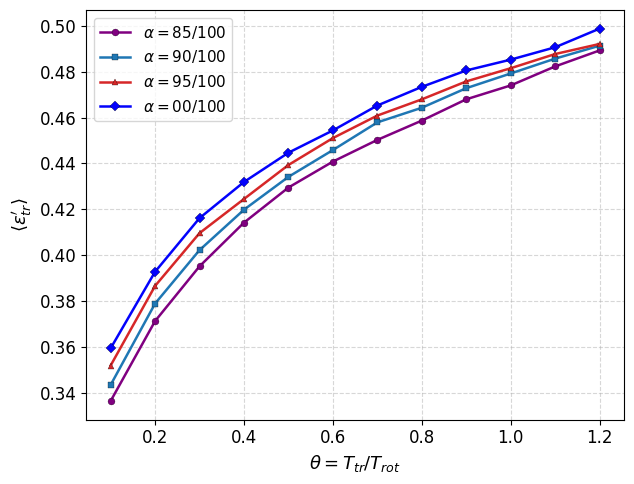

In [125]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Base directory
base_dir = "/home/muhammed/Documents/Thesis/New Simulations/Delta"
coeff_labels = ['GMM85', 'GMM90', 'GMM95', 'GMM100']
theta_vals = [round(0.1 * (i + 1), 1) for i in range(12)]
AR_folder = 'AR20'

# Storage dictionary
results = {}

# Loop over GMM folders
for coeff in coeff_labels:
    coeff_path = os.path.join(base_dir, coeff, AR_folder)
    mean_values = []

    for i in range(1, 13):
        r_folder = f"r{str(i).zfill(2)}"
        ef_path = os.path.join(coeff_path, r_folder, "Ef.txt")

        try:
            E_data = np.loadtxt(ef_path)
            post_energy = E_data[:, 3] + E_data[:, 4] + E_data[:, 5]
            epsilon_tr_prime = E_data[:, 3] / post_energy
            mean_eps_tr = np.mean(epsilon_tr_prime)
            mean_values.append(mean_eps_tr)
        except Exception as e:
            print(f"Skipping {ef_path}: {e}")
            mean_values.append(np.nan)

    results[coeff] = mean_values

# Plotting
plt.figure(figsize=(6.5, 5))
markers = ['o', 's', '^', 'D']
colors = ['#800080', '#1f77b4', '#d62728', '#0302FC']
for i, coeff in enumerate(coeff_labels):
    plt.plot(theta_vals, results[coeff], label=f"$\\alpha = {coeff[-2:]}/100$", 
             marker=markers[i], color=colors[i], linewidth=1.8)

plt.xlabel(r'$\theta = T_{tr}/T_{rot}$', fontsize=13)
plt.ylabel(r'$\langle \varepsilon^\prime_{tr} \rangle$', fontsize=13)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=11, frameon=True)
plt.tight_layout()
plt.savefig("mean_trans_energy_fraction_AR20.pdf", bbox_inches='tight')
plt.show()

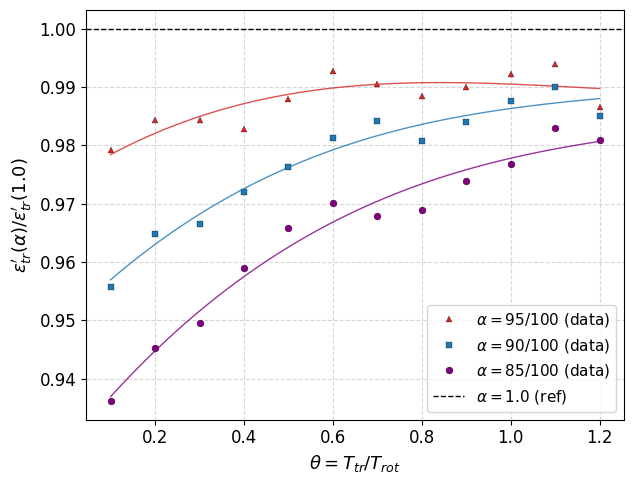

In [126]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Reference (elastic) data
theta_vals = np.array([round(0.1 * (i + 1), 1) for i in range(12)])
alpha_ref = 'GMM100'
ref_values = np.array(results[alpha_ref])

# Alpha values and labels
alpha_labels = ['GMM95', 'GMM90', 'GMM85']
alpha_vals = np.array([0.95, 0.90, 0.85])
colors = ['#d62728', '#1f77b4', '#800080']
markers = ['^', 's', 'o']
labels = ['95', '90', '85']

# Compute scaled values
scaling_results = {}
X_fit, y_fit = [], []

for a_val, coeff in zip(alpha_vals, alpha_labels):
    eps_alpha = np.array(results[coeff])
    with np.errstate(divide='ignore', invalid='ignore'):
        scaling = np.where(ref_values != 0, eps_alpha / ref_values, np.nan)
    scaling_results[coeff] = scaling
    
    for t, s in zip(theta_vals, scaling):
        if not np.isnan(s):
            X_fit.append([t, a_val])
            y_fit.append(s)

X_fit = np.array(X_fit)
y_fit = np.array(y_fit)

# Fit 2D polynomial model
poly = PolynomialFeatures(degree=3, include_bias=True)
X_poly = poly.fit_transform(X_fit)
model = LinearRegression().fit(X_poly, y_fit)

# Plotting
plt.figure(figsize=(6.5, 5))

# Plot raw data and fitted curves
for i, (alpha, coeff) in enumerate(zip(alpha_vals, alpha_labels)):
    plt.plot(theta_vals, scaling_results[coeff], marker=markers[i], linestyle='', 
             label=fr'$\alpha = {labels[i]}/100$ (data)', color=colors[i])
    
    # Predict using model over fine theta grid
    theta_grid = np.linspace(0.1, 1.2, 100)
    alpha_grid = np.full_like(theta_grid, alpha)
    X_pred = poly.transform(np.column_stack((theta_grid, alpha_grid)))
    y_pred = model.predict(X_pred)

    plt.plot(theta_grid, y_pred, linestyle='-', color=colors[i], alpha=0.8)

# Reference horizontal line
plt.axhline(1.0, color='black', linestyle='--', linewidth=1.0, label=r'$\alpha = 1.0$ (ref)')

# Labels, styling
plt.xlabel(r'$\theta = T_{tr}/T_{rot}$', fontsize=13)
plt.ylabel(r'$\varepsilon^\prime_{tr}(\alpha) / \varepsilon^\prime_{tr}(1.0)$', fontsize=13)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=11, frameon=True)
plt.tight_layout()
plt.savefig("scaling_deviation_AR20_with_fit.pdf", bbox_inches='tight')
plt.show()


In [123]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt

# Prepare data for fitting
theta_vals = np.array([round(0.1 * (i + 1), 1) for i in range(12)])
alpha_vals = np.array([0.85, 0.90, 0.95])  # Normalized alpha values
alpha_labels = ['GMM85', 'GMM90', 'GMM95']

# Build (theta, alpha) pairs and corresponding targets
X, y = [], []
for alpha, label in zip(alpha_vals, alpha_labels):
    for i, theta in enumerate(theta_vals):
        if not np.isnan(scaling_results[label][i]):
            X.append([theta, alpha])
            y.append(scaling_results[label][i])

X = np.array(X)
y = np.array(y)

# Fit 2D polynomial (degree 3 is typical, adjust as needed)
poly = PolynomialFeatures(degree=3, include_bias=True)
X_poly = poly.fit_transform(X)

model = LinearRegression()
model.fit(X_poly, y)

# Store model for reuse
coeffs = model.coef_
intercept = model.intercept_

# Print formula representation (optional)
feature_names = poly.get_feature_names_out(['theta', 'alpha'])
for name, coef in zip(feature_names, model.coef_):
    print(f"{coef:.4e} * {name}")
print(f"Intercept: {intercept:.4e}")


0.0000e+00 * 1
9.0879e-01 * theta
3.9488e-01 * alpha
-5.8334e-01 * theta^2
-7.6575e-01 * theta alpha
3.1958e-01 * alpha^2
6.0892e-02 * theta^3
4.8405e-01 * theta^2 alpha
-1.0979e-01 * theta alpha^2
-9.5708e-02 * alpha^3
Intercept: 3.8446e-01


Fitted Z_r = 2.251 ± 0.042
Estimated CPP rate (late) ν_dem ≈ 0.1385  [CPP per second]


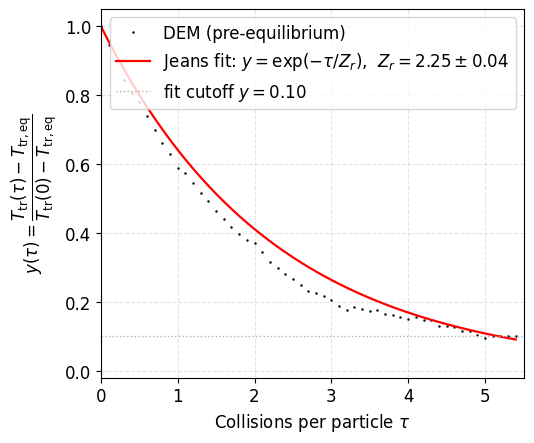

In [81]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.typing import ArrayLike

# ---------- helpers ----------
def load_dem_table(path: str):
    """
    Expects columns: time, CPP (tau), T_tr, T_rot, ...  (no header)
    """
    A = np.loadtxt(path)
    t   = A[:, 0]
    tau = A[:, 1]
    # pick translational temperature/energy-like column
    Ttr = A[:, 2]   # adjust if your file layout differs
    return t, tau, Ttr

def equilibrium_value(x: ArrayLike, tail_frac: float = 0.2):
    """Robust equilibrium estimate from the last `tail_frac` of samples."""
    n0 = int((1.0 - tail_frac) * len(x))
    return np.median(x[n0:])

def fit_Zr(tau: ArrayLike, Ttr: ArrayLike, eps: float = 0.10):
    """
    Fit Jeans: y = exp(-tau/Zr) over the window where y >= eps,
    with y = (Ttr - T_eq)/(Ttr[0] - T_eq).
    Returns Zr, indices used, standard error.
    """
    T_eq = equilibrium_value(Ttr, tail_frac=0.2)
    y = (Ttr - T_eq) / (Ttr[0] - T_eq)

    # keep strictly the relaxation segment (before practical equilibrium)
    mask = y >= eps
    tau_fit = tau[mask]
    y_fit   = y[mask]

    # linearize: ln y = -tau/Zr
    ln_y = np.log(y_fit)

    # simple weighted LS (heavier weight mid-range)
    w = 1.0 / np.maximum(1e-12, (1.0 + (y_fit-0.5)**2))
    # polyfit with weights -> slope, intercept
    p = np.polyfit(tau_fit, ln_y, 1, w=w)
    slope, intercept = p[0], p[1]
    Zr = -1.0 / slope

    # stderr for Zr from residuals
    ln_y_hat = np.polyval(p, tau_fit)
    s2 = np.mean((ln_y - ln_y_hat)**2)
    Sxx = np.sum(w * (tau_fit - np.average(tau_fit, weights=w))**2)
    slope_stderr = np.sqrt(s2 / max(Sxx, 1e-15))
    Zr_stderr = slope_stderr / (slope**2)

    # index of last point used = practical equilibrium index
    last_idx = np.where(mask)[0][-1]

    return Zr, Zr_stderr, y, T_eq, last_idx

def cpp_rate_after_level(t, tau, y, level=0.65):
    """
    Estimate DEM CPP rate (slope d(tau)/dt) after the signal first crosses `level`
    (matches the spirit of the MATLAB snippet).
    """
    idx = np.argmax(y < level)  # first index where y < level
    if y[0] < level:  # guard: if already below, start at 0
        idx = 0
    if idx == 0:
        idx = np.searchsorted(y, level, side='left')
    # linear slope over the remaining window
    dt = t[-1] - t[idx]
    if dt <= 0:
        return np.nan
    return (tau[-1] - tau[idx]) / dt

# ---------- run (single case) ----------
path = "/home/muhammed/Documents/Thesis/New Simulations/DEM_Relax/Alpha_100/AR30/T.txt"  # <- change AR as needed
t, tau, Ttr = load_dem_table(path)

Zr, Zr_err, y, T_eq, i_eq = fit_Zr(tau, Ttr, eps=0.10)
nu_dem = cpp_rate_after_level(t, tau, y, level=0.65)

print(f"Fitted Z_r = {Zr:.3f} ± {Zr_err:.3f}")
print(f"Estimated CPP rate (late) ν_dem ≈ {nu_dem:.4f}  [CPP per second]")

# ---------- plot up to equilibrium with Jeans fit ----------
tau_fit = tau[:i_eq+1]
y_fit   = y[:i_eq+1]
y_jeans = np.exp(-tau_fit / Zr)

plt.figure(figsize=(5.5, 4.6))
plt.plot(tau_fit, y_fit, 'k.', ms=3, label='DEM (pre-equilibrium)')
plt.plot(tau_fit, y_jeans, 'r-', lw=1.6,
         label=fr"Jeans fit: $y=\exp(-\tau/Z_r)$,  $Z_r={Zr:.2f}\pm{Zr_err:.2f}$")
plt.axhline(0.10, color='0.7', ls=':', lw=1, label=r'fit cutoff $y=0.10$')
plt.xlabel(r'Collisions per particle $\tau$')
plt.ylabel(r'$y(\tau)=\dfrac{T_{\rm tr}(\tau)-T_{\rm tr,eq}}{T_{\rm tr}(0)-T_{\rm tr,eq}}$')
plt.xlim(tau_fit[0], tau_fit[-1]*1.02)
plt.ylim(-0.02, 1.05)
plt.grid(True, ls='--', alpha=0.35)
plt.legend(frameon=True)
plt.tight_layout()
plt.show()

/tmp/ipykernel_266850/1599497471.py:61: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(


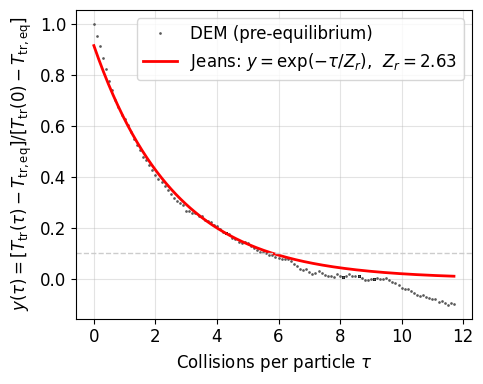

In [134]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import lstsq
from scipy.optimize import curve_fit

# ---------- IO ----------
def load_dem_T(path):
    arr = np.loadtxt(path)          # columns: t, τ, T_tr, T_rot
    return arr[:,0], arr[:,1], arr[:,2], arr[:,3]

# ---------- helpers ----------
def robust_Teq(T, frac=0.2):
    n = len(T); i0 = int((1.0-frac)*n)
    return np.median(T[i0:])

def best_linear_window(tau, y, ymins=(0.08,0.10,0.12,0.15), ymaxs=(0.6,0.7,0.8,0.9), min_pts=10):
    best = None
    for ylo in ymins:
        for yhi in ymaxs:
            m = (y>=ylo) & (y<=yhi)
            if m.sum() < min_pts: 
                continue
            X = np.column_stack([tau[m], np.ones(m.sum())])
            Y = np.log(y[m])
            slope, intercept = lstsq(X, Y, rcond=None)[0]
            Yhat = slope*tau[m] + intercept
            r2 = 1 - ((Y-Yhat)**2).sum() / ((Y-Y.mean())**2).sum()
            if (best is None) or (r2 > best['r2']):
                best = dict(mask=m, slope=slope, intercept=intercept, r2=r2,
                            ylo=ylo, yhi=yhi)
    return best

def _zr_label(zr, zr_err):
    if zr_err is not None and np.isfinite(zr_err):
        return fr'$Z_r={zr:.2f}\ \pm\ {zr_err:.2f}$'
    return fr'$Z_r={zr:.2f}$'

# ---------- fit (unchanged logic) ----------
def fit_Zr_joint(tau, Ttr, tail_frac=0.2):
    Teq0 = robust_Teq(Ttr, frac=tail_frac)
    y0 = (Ttr - Teq0) / (Ttr[0] - Teq0)

    win = best_linear_window(tau, y0)
    if win is None:
        raise RuntimeError("No adequate linear window found.")

    m = win['mask']

    def model(tau_, Teq, Zr, A):
        return A * np.exp(-tau_ / Zr)

    Zr0 = -1.0 / win['slope']
    A0  = np.exp(win['intercept'])
    p0  = [Teq0, Zr0, A0]

    # weights: emphasize mid-range y
    y_mid = (Ttr - Teq0) / (Ttr[0] - Teq0)
    w = np.clip(y_mid, 0.05, 1.0)

    # fit only on the window
    popt, pcov = curve_fit(
        lambda tau_, Teq, Zr, A: model(tau_, Teq, Zr, A),
        tau[m], y_mid[m], p0=[Teq0, Zr0, A0],
        sigma=1.0/w[m], absolute_sigma=False, maxfev=20000
    )

    Teq, Zr, A = popt
    Zr_err = np.sqrt(np.diag(pcov))[1] if (pcov.size and np.isfinite(pcov[1,1])) else np.nan

    # normalized data for plotting
    y_norm = (Ttr - Teq) / (Ttr[0] - Teq)

    return dict(Teq=Teq, Zr=Zr, Zr_err=Zr_err, A=A, mask=m, y=y_norm)

# ---------- plotting with user-specified τ span ----------
def demo_plot(tau, fit, tau_span=(0.1, 7.5), title=None):
    # Build a smooth curve ONLY for the requested span.
    t0, t1 = tau_span
    # keep within data extent but allow small padding
    t0 = max(t0, float(np.nanmin(tau)))
    t1 = min(t1, float(np.nanmax(tau)))
    tau_plot = np.linspace(t0, t1, 300)
    y_plot   = fit['A'] * np.exp(-tau_plot / fit['Zr'])

    plt.figure(figsize=(5.0,4.0))
    plt.plot(tau, fit['y'], '.', ms=3, color='0.35', label='DEM (pre-equilibrium)')
    zr_txt = _zr_label(fit["Zr"], fit.get("Zr_err", np.nan))
    plt.plot(tau_plot, y_plot, 'r-', lw=2, label=fr'Jeans: $y=\exp(-\tau/Z_r)$,  {zr_txt}')
    plt.axhline(0.10, color='0.8', ls='--', lw=1)
    plt.xlabel(r'Collisions per particle $\tau$')
    plt.ylabel(r'$y(\tau)=[T_{\rm tr}(\tau)-T_{\rm tr,eq}]/[T_{\rm tr}(0)-T_{\rm tr,eq}]$')
    #if title: plt.title(title)
    plt.grid(True, alpha=0.35)
    plt.legend(frameon=True)
    plt.tight_layout()
    plt.show()

# ---------- example ----------
path = "/home/muhammed/Documents/Thesis/New Simulations/DEM_Relax/Alpha_095/AR20/T.txt"
t, tau, Ttr, Trot = load_dem_T(path)
fit = fit_Zr_joint(tau, Ttr, tail_frac=0.2)
demo_plot(tau, fit, tau_span=(0, 12.5), title=r"AR=3.0, $\alpha=1$")


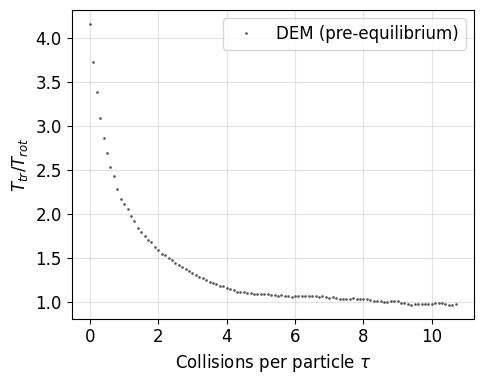

In [127]:
path = "/home/muhammed/Documents/Thesis/New Simulations/DEM_Relax/Alpha_090/AR15/T.txt"
arr = np.loadtxt(path)
tau = arr[:, 1]
T_trans = arr[:, 2]
T_rot = arr[:, 3]
Temp_ratio = T_trans / T_rot
plt.figure(figsize=(5.0,4.0))
plt.plot(tau, Temp_ratio, '.', ms=3, color='0.35', label='DEM (pre-equilibrium)')
plt.xlabel(r'Collisions per particle $\tau$')
plt.ylabel(r'$T_{tr} / T_{rot}$')
plt.grid(True, alpha=0.35)
plt.legend(frameon=True)
plt.tight_layout()
plt.show()

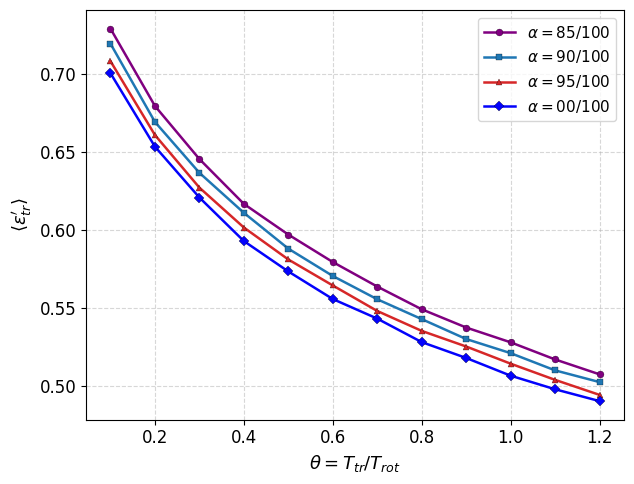

In [140]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Base directory
base_dir = "/home/muhammed/Documents/Thesis/New Simulations/Delta"
coeff_labels = ['GMM85', 'GMM90', 'GMM95', 'GMM100']
theta_vals = [round(0.1 * (i + 1), 1) for i in range(12)]
AR_folder = 'AR15'

# Storage dictionary
results = {}

# Loop over GMM folders
for coeff in coeff_labels:
    coeff_path = os.path.join(base_dir, coeff, AR_folder)
    mean_values = []

    for i in range(1, 13):
        r_folder = f"r{str(i).zfill(2)}"
        ef_path = os.path.join(coeff_path, r_folder, "Ef.txt")

        try:
            E_data = np.loadtxt(ef_path)
            post_energy = E_data[:, 3] + E_data[:, 4] + E_data[:, 5]
            epsilon_tr_prime = (E_data[:, 4] + E_data[:, 5]) / post_energy
            mean_eps_tr = np.mean(epsilon_tr_prime)
            mean_values.append(mean_eps_tr)
        except Exception as e:
            print(f"Skipping {ef_path}: {e}")
            mean_values.append(np.nan)

    results[coeff] = mean_values

# Plotting
plt.figure(figsize=(6.5, 5))
markers = ['o', 's', '^', 'D']
colors = ['#800080', '#1f77b4', '#d62728', '#0302FC']
for i, coeff in enumerate(coeff_labels):
    plt.plot(theta_vals, results[coeff], label=f"$\\alpha = {coeff[-2:]}/100$", 
             marker=markers[i], color=colors[i], linewidth=1.8)

plt.xlabel(r'$\theta = T_{tr}/T_{rot}$', fontsize=13)
plt.ylabel(r'$\langle \varepsilon^\prime_{tr} \rangle$', fontsize=13)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=11, frameon=True)
plt.tight_layout()
plt.savefig("mean_trans_energy_fraction_AR20.pdf", bbox_inches='tight')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


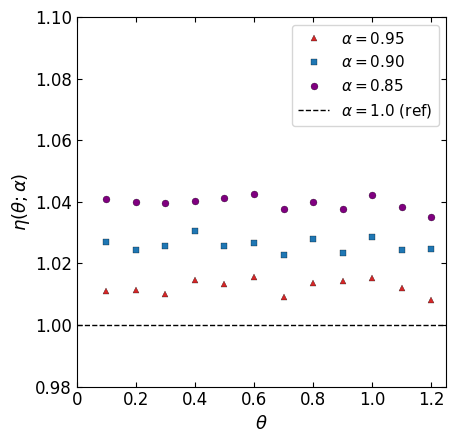

In [143]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Reference (elastic) data
theta_vals = np.array([round(0.1 * (i + 1), 1) for i in range(12)])
alpha_ref = 'GMM100'
ref_values = np.array(results[alpha_ref])

# Alpha values and labels
alpha_labels = ['GMM95', 'GMM90', 'GMM85']
alpha_vals = np.array([0.95, 0.90, 0.85])
colors = ['#d62728', '#1f77b4', '#800080']
markers = ['^', 's', 'o']
labels = ['0.95', '0.90', '0.85']

# Compute scaled values
scaling_results = {}
X_fit, y_fit = [], []

for a_val, coeff in zip(alpha_vals, alpha_labels):
    eps_alpha = np.array(results[coeff])
    with np.errstate(divide='ignore', invalid='ignore'):
        scaling = np.where(ref_values != 0, eps_alpha / ref_values, np.nan)
    scaling_results[coeff] = scaling
    
    for t, s in zip(theta_vals, scaling):
        if not np.isnan(s):
            X_fit.append([t, a_val])
            y_fit.append(s)

X_fit = np.array(X_fit)
y_fit = np.array(y_fit)

# Fit 2D polynomial model
poly = PolynomialFeatures(degree=1, include_bias=True)
X_poly = poly.fit_transform(X_fit)
model = LinearRegression().fit(X_poly, y_fit)

# Plotting
fig,ax = plt.subplots();
# Custom formatter: return '0' for 0, otherwise default formatting
formatter1 = FuncFormatter(lambda x, _: '0' if x == 0 else f'{x:.2f}')
formatter2 = FuncFormatter(lambda x, _: '0' if x == 0 else f'{x:.1f}')
ax.yaxis.set_major_formatter(formatter1)
ax.xaxis.set_major_formatter(formatter2)

# Plot raw data and fitted curves
for i, (alpha, coeff) in enumerate(zip(alpha_vals, alpha_labels)):
    ax.plot(theta_vals, scaling_results[coeff], marker=markers[i], linestyle='', 
             label=fr'$\alpha = {labels[i]}$', color=colors[i])
    
    # Predict using model over fine theta grid
    theta_grid = np.linspace(0.1, 1.2, 100)
    alpha_grid = np.full_like(theta_grid, alpha)
    X_pred = poly.transform(np.column_stack((theta_grid, alpha_grid)))
    y_pred = model.predict(X_pred)

    #plt.plot(theta_grid, y_pred, linestyle='-', color=colors[i], alpha=0.8)

# Reference horizontal line
ax.axhline(1.0, color='black', linestyle='--', linewidth=1.0, label=r'$\alpha = 1.0$ (ref)')

ax.set_xlim([0,1.25])
ax.set_ylim([0.98,1.1])
ax.set_xlabel(r'$\theta$')
ax.set_ylabel(r'$Z_r$',labelpad=+2)
xval, yval = ax.get_xlim(), ax.get_ylim()
xrange = xval[1]-xval[0];
yrange = yval[1]-yval[0];
ax.set_aspect(aspect*(xrange/yrange), adjustable='box')
ax.tick_params(axis='both',direction='in',which='both',right=True,top=True)

# Labels, styling
ax.set_xlabel(r'$\theta$', fontsize=13)
ax.set_ylabel(r'$\eta(\theta;\alpha)$', fontsize=13)
ax.legend(fontsize=11, frameon=True)
plt.savefig("eta_fit.eps", bbox_inches='tight')
plt.show()

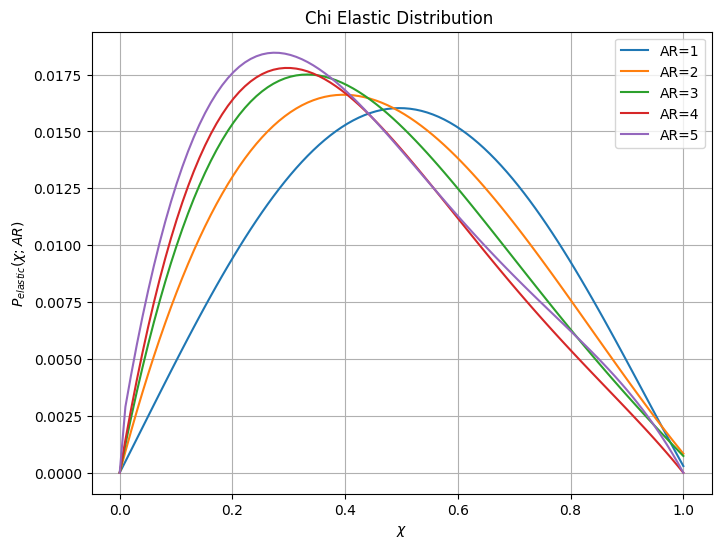

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Define the coefficients as functions of AR in a dictionary
coefficients = {
    "b0": lambda AR: 0.00226433 * AR**2 - 0.07525039 * AR + 0.14013707,
    "b1": lambda AR: -0.0150968 * AR**2 + 0.24036209 * AR - 0.35608824,
    "b2": lambda AR: 0.0188692 * AR**2 - 0.22754548 * AR + 0.22388461,
    "b3": lambda AR: -0.00636007 * AR**2 + 0.06394877 * AR - 0.00883223,
}

# Define the polynomial P_elastic(chi, AR)
def P_elastic(chi, AR):
    """Compute P_elastic using the coefficients defined in the dictionary."""
    return (
        coefficients["b0"](AR) * chi**4 +
        coefficients["b1"](AR) * chi**3 +
        coefficients["b2"](AR) * chi**2 +
        coefficients["b3"](AR) * chi
    )

# Generate data for plotting
AR_values = [1, 2, 3, 4, 5]  # Example AR values
chi = np.linspace(0, 1, 100)  # Chi values

def enforce_non_negativity(chi, P_values):
    """Apply non-negativity by adjusting with P(chi=1)."""
    P_at_1 = P_values[-1]  # Value of P(chi=1)
    adjustment = -P_at_1 if P_at_1 < 0 else 0  # Adjustment only if P_at_1 is negative
    P_adjusted = P_values + adjustment
    P_adjusted[0] = 0  # Fix P(chi=0) = 0
    return P_adjusted

# Generate data and apply the non-negativity condition
plt.figure(figsize=(8, 6))
for AR in AR_values:
    P_values = P_elastic(chi, AR)
    P_adjusted = enforce_non_negativity(chi, P_values)
    plt.plot(chi, P_adjusted, label=f"AR={AR}")

# Label the plot
plt.xlabel(r"$\chi$")
plt.ylabel(r"$P_{elastic}(\chi; AR)$")
plt.title("Chi Elastic Distribution ")
plt.legend()
plt.grid()
plt.show()



In [16]:
import numpy as np

# 1) Define your AR and alpha arrays
AR_list = [1, 2, 3, 4, 5]
alpha_list = [0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]

# 2) Suppose you have a dictionary of coefficients: 
#    coef_dict[AR][alpha] = [c4, c3, c2, c1]
#    (We'll just imagine it's filled in from your data.)

coef_dict = {
   1: {
       0.60: [-0.0457423, 0.18620275, -0.19844997, 0.05980599],
       0.65: [-0.02933377, 0.13350822, -0.14763789, 0.04470322],
       0.70: [-0.02995546, 0.12455225, -0.1344866, 0.0410258],
       0.75: [-0.017568, 0.08534477, -0.09701993, 0.03014919],
       0.80: [0.00500905, 0.03192625, -0.05603576, 0.01981849],
       0.85: [0.0063324, 0.01874517, -0.03865676, 0.01394177],
       0.90: [-0.01141365, 0.03966811, -0.039162, 0.01109996],
       0.95: [0.00582891, -0.00056087, -0.00920061, 0.00404684]
       # ...
   },
   2: {
       0.60: [-0.16893229, 0.41206732, -0.31875322, 0.07655536],
       0.65: [-0.1481685, 0.35794755, -0.27453046, 0.06557392],
       0.70: [-0.10157086, 0.25064335, -0.19528488, 0.0467525],
       0.75: [-0.06618716, 0.17173588, -0.13943772, 0.0345829],
       0.80: [-0.0521602, 0.13816142, -0.11478855, 0.02956328],
       0.85: [-0.06132872, 0.14522579, -0.10937857, 0.02585302],
       0.90: [-0.03824374, 0.09408824, -0.0732436, 0.01780612],
       0.95: [-0.01042564, 0.03151258, -0.02852445, 0.00777626]
   },
   3: {
       0.60: [-0.17901411, 0.4178749, -0.31155637, 0.07367286],
       0.65: [-0.15621984, 0.36287468, -0.26842249, 0.06228219],
       0.70: [-0.12114029, 0.28061615, -0.20597802, 0.04671893],
       0.75: [-0.08306562, 0.19534342, -0.1445301, 0.03221163],
       0.80: [-0.06876079, 0.16049872, -0.11806513, 0.0262182 ],
       0.85: [-0.05557579, 0.12884057, -0.09402805, 0.02073682],
       0.90: [-0.0304625, 0.07298925, -0.05474471, 0.01227399],
       0.95: [-0.01102906, 0.03005799, -0.02507753, 0.00620061]
   },
   4: {
       0.60: [-0.18246659, 0.42103769, -0.31121875, 0.07363455],
       0.65: [-0.1528647, 0.35174684, -0.25809351, 0.05987711],
       0.70: [-0.11897112, 0.27373594, -0.20000706, 0.04535826],
       0.75: [-0.09183981, 0.21475325, -0.15981239, 0.03722662],
       0.80: [-0.06115686, 0.14347598, -0.10620414, 0.02374209],
       0.85: [-0.0460703, 0.10632288, -0.07734191, 0.01685651],
       0.90: [-0.03695505, 0.08123861, -0.05603186, 0.01141461],
       0.95: [-0.01212053, 0.02843139, -0.02117981, 0.00483127]
   },
   5: {
       0.60: [-0.18012468, 0.40717507, -0.29310759, 0.06586052],
       0.65: [-0.16479155, 0.37086692, -0.26677269, 0.0607597 ],
       0.70: [-0.11538663, 0.26117436, -0.18736981, 0.0412548 ],
       0.75: [-0.08699589, 0.19488878, -0.13712965, 0.02867664],
       0.80: [-0.06132963, 0.13832804, -0.09850346, 0.0208973 ],
       0.85: [-0.04080834, 0.09144096, -0.0647443, 0.0144134 ],
       0.90: [-0.02035939, 0.04575119, -0.03146198, 0.00542497],
       0.95: [-0.01089383, 0.02421473, -0.01663602, 0.00298165]
   },
   # etc for AR=3,4,5
}
# 3) Build an x-grid
num_points = 100
x_vals = np.linspace(0, 1, num_points)

# We'll store dp_data in a 3D array: shape = (len(AR_list), len(alpha_list), num_points)
dp_data = np.zeros((len(AR_list), len(alpha_list), num_points))

# 4) Evaluate the polynomial for each (AR, alpha) on the x-grid
for j, AR in enumerate(AR_list):
    for k, alpha in enumerate(alpha_list):
        c4, c3, c2, c1 = coef_dict[AR][alpha]
        
        # Evaluate dp at each x
        for i, x in enumerate(x_vals):
            dp_data[j, k, i] = (c4*(x**4) + 
                                c3*(x**3) + 
                                c2*(x**2) + 
                                c1*x)

# dp_data[j,k,i] now holds Delta p at x_i for that AR_j and alpha_k.

In [954]:
import os
import numpy as np
from scipy.optimize import curve_fit
import re

# Define 4th-degree polynomial
def poly4(x, a, b, c, d, e):
    return a * x**4 + b * x**3 + c * x**2 + d * x + e

def load_chi_data(filepath):
    try:
        data = np.loadtxt(filepath)
        return data[:, 1] / np.pi  # Normalize chi to [0,1]
    except Exception as e:
        print(f"Error loading {filepath}: {e}")
        return None

def fit_polynomial(x_vals, bins=100):
    # Compute histogram
    hist, bin_edges = np.histogram(x_vals, bins=bins)
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

    # Normalize by number of samples (instead of density=True)
    prob_density = hist / len(x_vals)

    try:
        coeffs, _ = curve_fit(poly4, bin_centers, prob_density, maxfev=5000)
        return coeffs
    except Exception as e:
        print(f"Curve fitting failed: {e}")

In [955]:
# Paths and parameters
root_dir = "/home/muhammed/Documents/Thesis/New Simulations/Alpha"
aspect_ratios = [10, 15, 20, 25, 30, 40]   # AR = dir / 10
alphas = [60, 65, 70, 75, 80, 85, 90, 95, 100] # α = dir / 100

# Storage for coefficients
elastic_coeffs = {}    # AR -> [a, b, c, d, e]
delta_p_data = []      # list of tuples: (x, AR, alpha, delta_p)

# For elastic model design matrix
elastic_x_data = []
elastic_AR_data = []
elastic_p_data = []

x_vals = np.linspace(0, 1, 100)  # 100 points in chi/pi

# Step 1: Fit elastic model from Alpha/100
for ar in aspect_ratios:
    path = os.path.join(root_dir, "100", str(ar), "chi.txt")
    chi_data = load_chi_data(path)
    
    if chi_data is not None:
        coeffs = fit_polynomial(chi_data)
        if coeffs is not None:
            elastic_coeffs[ar] = coeffs
            
            # Evaluate polynomial PDF using coeffs on x_vals
            p_vals = np.polyval(coeffs, x_vals)

            # Append data points for design matrix regression
            elastic_x_data.extend(x_vals)
            elastic_AR_data.extend([ar / 10.0] * len(x_vals))  # Real AR
            elastic_p_data.extend(p_vals)

In [956]:
# Step 2: Fit inelastic and compute delta_p
for alpha in alphas:
    if alpha == 100: continue  # skip elastic case
    for ar in aspect_ratios:
        path = os.path.join(root_dir, str(alpha), str(ar), "chi.txt")
        chi_data = load_chi_data(path)
        if chi_data is None: continue

        inelastic_coeffs = fit_polynomial(chi_data)
        if inelastic_coeffs is None or ar not in elastic_coeffs: continue

        # Compute delta_p polynomial coefficients
        dp_coeffs = [in_ - el_ for in_, el_ in zip(inelastic_coeffs, elastic_coeffs[ar])]

        # Generate Δp(x) data for design matrix
        x_vals = np.linspace(0, 1, 100)
        dp_vals = poly4(x_vals, *dp_coeffs)
        for x, dp in zip(x_vals, dp_vals):
            delta_p_data.append((x, ar/10.0, alpha/100.0, dp))  # Convert AR and alpha to float

# Convert to numpy arrays for modeling
delta_p_data = np.array(delta_p_data)
x_data, AR_data, alpha_data, dp_data = delta_p_data.T

In [957]:
import numpy as np

def phi(alpha, beta=1.0):

    return 1.0 - alpha**beta

def build_design_matrix(x_data, AR_data, alpha_data, dp_data,
                        K=4, M=2, N=2, beta=1.0):
    R = len(x_data)
    if not (len(AR_data) == R and len(alpha_data) == R and len(dp_data) == R):
        raise ValueError("All input arrays must have the same length R.")

    # Number of columns in design matrix
    num_cols = (K+1)*(M+1)*(N+1)

    # Allocate
    X = np.zeros((R, num_cols), dtype=float)
    y = np.zeros(R, dtype=float)

    # Precompute phi(alpha)
    phi_vals = [phi(a, beta=beta) for a in alpha_data]

    for r in range(R):
        x_r  = x_data[r]
        AR_r = AR_data[r]
        ph_r = phi_vals[r]

        # Fill row r of the design matrix
        col_index = 0
        for m in range(M+1):     # 0..M
            for n in range(N+1): # 0..N
                for k in range(K+1): # 0..K
                    bf = (AR_r**m) * (ph_r**n) * (x_r**k)
                    X[r, col_index] = bf
                    col_index += 1

        # The target is dp_data
        y[r] = dp_data[r]

    return X, y

In [958]:
# Now call build_design_matrix:
K, M, N     = 4, 2, 2         # for example
beta_choice = 0.5        # or whichever you prefer
X, y = build_design_matrix(
    x_data, AR_data, alpha_data, dp_data,
    K=K, M=M, N=N, beta=beta_choice
)

In [959]:
a_vec, residuals, rank, svals = np.linalg.lstsq(X, y, rcond=None)
print("Coefficients shape:", a_vec.shape)
print("Residual sum of squares:", residuals)
a_reshaped = a_vec.reshape((M+1, N+1, K+1), order='C')
print("Coefficients shape: ", a_reshaped.shape)

Coefficients shape: (45,)
Residual sum of squares: [4.83343537e-05]
Coefficients shape:  (3, 3, 5)


In [960]:
import numpy as np

def build_elastic_design_matrix(x_data, AR_data, p_data, K=4, M=2):
    """
    Build design matrix for P_elastic(x, AR) = sum_{m=0..M} sum_{k=0..K} a_{m,k} * AR^m * x^k

    Parameters
    ----------
    x_data : array of x (chi/pi) values, shape (R,)
    AR_data : array of AR values, shape (R,)
    p_data : array of probability densities at each (x, AR), shape (R,)
    K : polynomial degree in x
    M : polynomial degree in AR

    Returns
    -------
    X : design matrix of shape (R, (M+1)*(K+1))
    y : target vector of shape (R,)
    """
    R = len(x_data)
    assert R == len(AR_data) == len(p_data)

    num_cols = (M + 1) * (K + 1)
    X = np.zeros((R, num_cols), dtype=float)
    y = np.zeros(R, dtype=float)

    for r in range(R):
        x = x_data[r]
        AR = AR_data[r]
        col_idx = 0
        for m in range(M + 1):
            for k in range(K + 1):
                X[r, col_idx] = (AR ** m) * (x ** k)
                col_idx += 1
        y[r] = p_data[r]
    
    return X, y

In [961]:
X_elastic, y_elastic = build_elastic_design_matrix(
    np.array(elastic_x_data),
    np.array(elastic_AR_data),
    np.array(elastic_p_data),
    K=4, M=2
)
a_vec_elastic, residuals_elastic, _, _ = np.linalg.lstsq(X_elastic, y_elastic, rcond=None)
a_elastic_reshaped = a_vec_elastic.reshape((M + 1, K + 1), order='C')

In [962]:
print("Coefficients shape:", a_vec_elastic.shape)
print("Residual sum of squares:", residuals_elastic)
print("Coefficients shape: ", a_elastic_reshaped.shape)

Coefficients shape: (15,)
Residual sum of squares: [1.62817108e-05]
Coefficients shape:  (3, 5)


In [963]:
def P_elastic(x, AR, a_elastic_reshaped, M=2, K=4):
    x = np.atleast_1d(x)
    P = np.zeros_like(x, dtype=float)

    for m in range(M + 1):
        for k in range(K + 1):
            coeff = a_elastic_reshaped[m, k]
            P += coeff * (AR ** m) * (x ** k)

    return P if x.size > 1 else P[0]

In [964]:
import numpy as np

def delta_p_model(x, AR, alpha, a_reshaped, M, N, K, beta=1.0):
    # Ensure x is a NumPy array for vectorized evaluation
    x_arr = np.atleast_1d(x)
    
    # compute phi(alpha)
    phi_val = 1.0 - alpha**beta
    
    # We'll accumulate results in an array of same shape as x_arr
    s = np.zeros_like(x_arr, dtype=float)
    
    # Triple nested loops for m=0..M, n=0..N, k=0..K
    for m in range(M+1):
        for n in range(N+1):
            for k_ in range(K+1):
                coeff = a_reshaped[m, n, k_] 
                s += coeff * (AR**m) * (phi_val**n) * (x_arr**k_)
    
    # s now holds Delta p
    return s if x_arr.size > 1 else s[0]

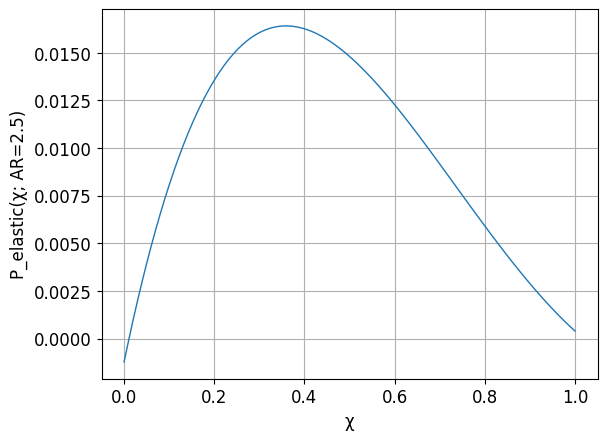

In [883]:
chi_vals = np.linspace(0, 1, 100)
AR_val = 2.5  # AR = 2.5
P_vals = P_elastic(chi_vals, AR_val, a_elastic_reshaped)

plt.plot(chi_vals, P_vals)
plt.xlabel("χ")
plt.ylabel("P_elastic(χ; AR=2.5)")
plt.grid()
plt.show()

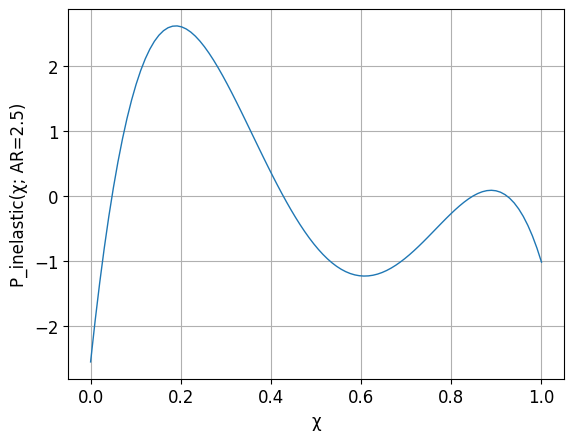

In [884]:
chi_vals = np.linspace(0, 1, 100)
AR_val = 2.5  # AR = 2.5
delP = delta_p_model(chi_vals, AR_val, alpha, a_reshaped, M, N, K, beta=0.5)

plt.plot(chi_vals, delP)
plt.xlabel("χ")
plt.ylabel("P_inelastic(χ; AR=2.5)")
plt.grid()
plt.show()

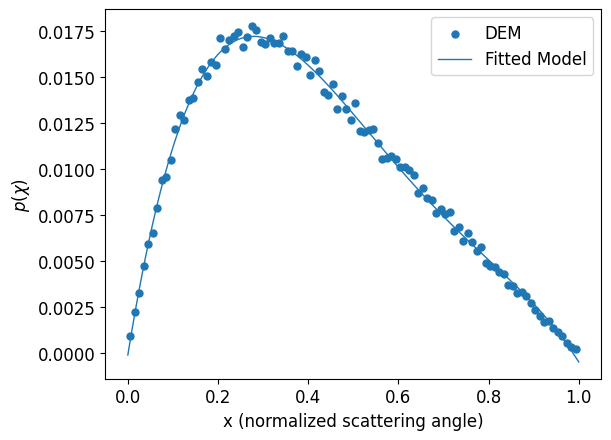

In [965]:
import matplotlib.pyplot as plt

def p_chi_AR_alpha (chi, AR, alpha):
    P_alpha1 = P_elastic(chi, AR, a_elastic_reshaped)
    #P_alpha1 = enforce_non_negativity(chi, P_alpha1)
    delP = delta_p_model(chi, AR, alpha, a_reshaped, M, N, K, beta=0.5)
    P_chi = P_alpha1 + delP
    return P_chi

chi_test = np.linspace(0, 1, 1000)
AR = 4
alpha = 0.9
p_chi_pred = p_chi_AR_alpha (chi_test, AR, alpha)

def load_and_process_Edata(file_path):
    chi_data = np.loadtxt(file_path)
    chi = chi_data[:, 1]/np.pi
    return chi

chi_DEM = load_and_process_Edata('/home/muhammed/Documents/Thesis/New Simulations/Alpha/90/40/chi.txt')
hist_data, bin_edges = np.histogram(chi_DEM, bins=100)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

plt.scatter(bin_centers, hist_data/len(chi_DEM), label=f'DEM')
plt.plot(chi_test, p_chi_pred, label="Fitted Model")
#plt.scatter(x_test, y2, label="0.9", alpha=0.5)
plt.xlabel("x (normalized scattering angle)")
plt.ylabel(r"$p(\chi)$")
#plt.title(f"Delta p for AR={AR_test}, alpha={alpha_test}")
plt.legend()
plt.show()

In [886]:
import numpy as np
import matplotlib.pyplot as plt
import yt
import math
from matplotlib import ticker
from colormap import rgb2hex                         # keep if you prefer it
# NEW ────────────────────────────────────────────────────────────────────────
# axes_grid → axes_grid1   (same functionality, maintained sub-package)
from mpl_toolkits.axes_grid1.inset_locator import (
    inset_axes, InsetPosition, mark_inset
)
# ────────────────────────────────────────────────────────────────────────────

# --------------------------------------------------------------------------
# Matplotlib global style
# --------------------------------------------------------------------------
plt.rc("text", usetex=False)
plt.rc("font", size=12)
plt.rc("axes", titlesize=60)
plt.rcParams.update({
    "legend.fontsize": 12,
    "lines.markersize": 5,
    "lines.markeredgecolor": "k",
    "lines.markeredgewidth": 0.2,
    "lines.linewidth": 1.0,
})

formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(False)
formatter.set_powerlimits((-1, 1))

# --------------------------------------------------------------------------
# Plot parameters
# --------------------------------------------------------------------------
aspect = 1.0

# Custom colour palette (red → blue gradient)
ncol = 5
red  = np.array([254,   0,   2], dtype=int)
blue = np.array([  3,   2, 252], dtype=int)

c1 = np.linspace(red[0],  blue[0],  ncol, dtype=int)
c2 = np.linspace(red[1],  blue[1],  ncol, dtype=int)
c3 = np.linspace(red[2],  blue[2],  ncol, dtype=int)

colors = [rgb2hex(r, g, b) for r, g, b in zip(c1, c2, c3)][::-1]

markers = ["o", "^", "v", "s", "D", "X", "*"]

In [1107]:
colors = ['#0302FC','g', '#BF0040','#FE0002']

In [1108]:
markers = ['o', '^', 's', 'v', 'D', 'X', '*']

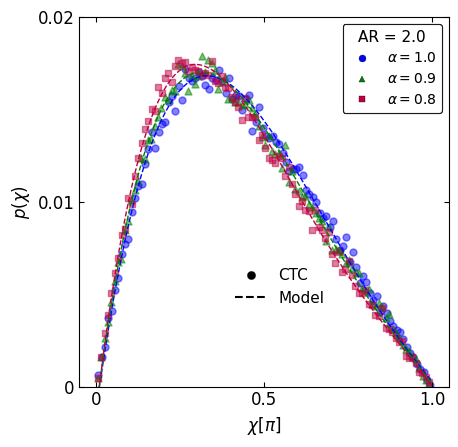

In [1111]:
def load_and_process_Edata(file_path):
    chi_data = np.loadtxt(file_path)
    chi = chi_data[:, 1]/np.pi
    return chi

file_list1 = [
    '/home/muhammed/Documents/Thesis/New Simulations/Alpha/100/30/chi.txt',
    '/home/muhammed/Documents/Thesis/New Simulations/Alpha/90/30/chi.txt',
    '/home/muhammed/Documents/Thesis/New Simulations/Alpha/80/30/chi.txt',
]
label = [r'$\alpha = 1.0$', r'$\alpha = 0.9$', r'$\alpha=0.8$']

fig,ax = plt.subplots();
from matplotlib.ticker import FuncFormatter

# Custom formatter: return '0' for 0, otherwise default formatting
formatter1 = FuncFormatter(lambda x, _: '0' if x == 0 else f'{x:.2f}')
formatter2 = FuncFormatter(lambda x, _: '0' if x == 0 else f'{x:.1f}')
ax.yaxis.set_major_formatter(formatter1)
ax.xaxis.set_major_formatter(formatter2)

chi_test = np.linspace(0, 1, 1000)
AR = 3.0
alpha = [1, 0.9, 0.8]

for j, file_path in enumerate(file_list1):
    chi = load_and_process_Edata(file_path)
    hist_data, bin_edges = np.histogram(chi, bins=100)
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    ax.scatter(bin_centers, hist_data/len(chi), label=f'{label[j]}', marker=markers[j], color=colors[j], alpha=0.5)
    p_chi_pred = p_chi_AR_alpha (chi_test, AR, alpha[j])
    plt.plot(chi_test, p_chi_pred, '--', color=colors[j])
    
    
ax.set_xlim([-0.05,1.05])
ax.set_ylim([0,0.02])
ax.set_ylabel(r'$p(\chi)$')
ax.set_xlabel(r'$\chi[\pi]$')
xval, yval = ax.get_xlim(), ax.get_ylim()
xrange = xval[1]-xval[0];
yrange = yval[1]-yval[0];
ax.set_aspect(aspect*(xrange/yrange), adjustable='box')
ax.set_xticks([0, 0.5, 1.0])
ax.set_yticks([0, 0.01, 0.02])
ax.tick_params(axis='both',direction='in',which='both',right=True,top=True)
from matplotlib.lines import Line2D

# Model (dashed line) and CTC (black markers) legend items
model_line = Line2D([0], [0], color='black', lw=1.5, linestyle='--', label=r'Model')
ctc_marker = Line2D([0], [0], color='black', marker='o', linestyle='None', markersize=6, label='CTC')

# Combined legend
legend_items = [ctc_marker, model_line]
legend3 = ax.legend(handles=legend_items,
                    loc='center right',
                    bbox_to_anchor=(0.7, 0.27),
                    fontsize=11,
                    frameon=False)
ax.add_artist(legend3)

# Custom handles for AR=2.0
legend1_handles = [
    Line2D([0], [0], marker=markers[0], color='none', markerfacecolor=colors[0], label=r'$\alpha = 1.0$'),
    Line2D([0], [0], marker=markers[1], color='none', markerfacecolor=colors[1], label=r'$\alpha = 0.9$'),
    Line2D([0], [0], marker=markers[2], color='none', markerfacecolor=colors[2], label=r'$\alpha = 0.8$')
]


# Legend for AR=2.0
legend1 = ax.legend(handles=legend1_handles, title=r'AR = 2.0',
                    loc='upper right', bbox_to_anchor=(1.0, 1.0),
                    fontsize=10, title_fontsize=11, frameon=True)
legend1.get_frame().set_edgecolor('black')
legend1.get_frame().set_linewidth(0.8)
ax.add_artist(legend1)

mng = plt.get_current_fig_manager()
mng.full_screen_toggle()
plt.savefig('chi.pdf',bbox_inches='tight')
plt.show()

In [891]:
alpha[0]

1

In [966]:
# setup stage
def init_p_chi_distribution(AR, alpha):
    # High-resolution precomputation
    chi_vals = np.linspace(0, 1, 1000)
    p_vals = p_chi_AR_alpha(chi_vals, AR, alpha)
    
    # Find max for accept-reject
    p_max = np.max(p_vals) * 1.05
    
    # Return callable and p_max
    return lambda chi: p_chi_AR_alpha(chi, AR, alpha), p_max

In [967]:
# inside collision loop
def sample_chi(p_chi_fn, p_max, rng=np.random):
    while True:
        chi_star = rng.uniform(0.0, 1.0)
        u = rng.uniform(0.0, p_max)
        if u <= p_chi_fn(chi_star):
            return chi_star

In [348]:
np.max(p_chi_pred)*1.05

0.018054829714947252

In [349]:
# Save a_elastic_reshaped to file (shape: [M+1, K+1])
with open("Pchi_elastic.dat", "w") as f:
    for m in range(a_elastic_reshaped.shape[0]):
        for k in range(a_elastic_reshaped.shape[1]):
            f.write(f"{m} {k} {a_elastic_reshaped[m, k]:.15e}\n")

In [350]:
# Save a_reshaped to file (shape: [M+1, N+1, K+1])
with open("del_P.dat", "w") as f:
    for m in range(a_reshaped.shape[0]):
        for n in range(a_reshaped.shape[1]):
            for k in range(a_reshaped.shape[2]):
                f.write(f"{m} {n} {k} {a_reshaped[m, n, k]:.15e}\n")

In [351]:
a_reshaped

array([[[ 6.19952799e-04, -7.63904797e-03,  2.48700467e-02,
         -3.08853546e-02,  1.29693390e-02],
        [-1.21458289e-02,  2.24998119e-01, -2.61314582e-01,
         -4.85478227e-01,  5.44289668e-01],
        [ 2.63551613e-02, -4.47272978e-02, -6.67326434e-01,
          1.57766149e+00, -8.97195326e-01]],

       [[-5.09339747e-04,  8.27939579e-03, -2.67133181e-02,
          3.02137148e-02, -1.11412416e-02],
        [ 6.46237260e-03, -6.88590359e-02, -1.46407195e-01,
          6.99843496e-01, -4.97684599e-01],
        [-2.37083481e-02,  6.00563131e-01, -2.10739597e+00,
          2.52214285e+00, -9.97446087e-01]],

       [[ 8.07086923e-05, -1.56798997e-03,  5.07930168e-03,
         -5.50496898e-03,  1.87748250e-03],
        [-4.51024285e-04,  1.29134178e-02,  2.11373787e-03,
         -7.41682571e-02,  6.05401912e-02],
        [ 2.41829996e-04, -1.01178203e-01,  4.16501403e-01,
         -5.33612217e-01,  2.19208158e-01]]])

In [34]:
import numpy as np
from scipy.integrate import cumtrapz
from scipy.interpolate import interp1d

# Precompute the PDF and CDF for given AR and alpha
def precompute_cdf(chi_range, AR, alpha):
    # Compute the PDF
    pdf = p_chi_AR_alpha(chi_range, AR, alpha)
    pdf_normalized = pdf / np.trapz(pdf, chi_range)  # Normalize PDF

    # Compute the CDF
    cdf = cumtrapz(pdf_normalized, chi_range, initial=0)
    cdf_interpolator = interp1d(cdf, chi_range, kind="linear", bounds_error=False, fill_value="extrapolate")
    
    return pdf_normalized, cdf_interpolator

# Generate a single sample using the precomputed CDF
def sample_chi(cdf_interpolator):
    uniform_random = np.random.uniform(0, 1)  # Uniform random number in [0, 1]
    return cdf_interpolator(uniform_random)

# Example usage
chi_range = np.linspace(0, 1, 1000)  # High resolution for chi
AR = 3  # Example aspect ratio
alpha = 0.9  # Example restitution coefficient

# Precompute PDF and CDF
pdf_normalized, cdf_interpolator = precompute_cdf(chi_range, AR, alpha)

# Generate a single sample per occurrence
sampled_chi = sample_chi(cdf_interpolator)

# Print results
print(f"Sampled chi: {sampled_chi}")

Sampled chi: 0.13139864380538485


/tmp/ipykernel_3152013/1864582621.py:12: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  cdf = cumtrapz(pdf_normalized, chi_range, initial=0)


In [352]:
import os
import numpy as np
import matplotlib.pyplot as plt

def load_and_process_Edata(file_path):
    """Loads Ef.txt and computes maximum fractional dissipation."""
    try:
        E_data = np.loadtxt(file_path)
        post_coll_energy = E_data[:, 3] + E_data[:, 4] + E_data[:, 5]
        pre_coll_energy = E_data[:, 0] + E_data[:, 1] + E_data[:, 2]
        dissp_energy = (pre_coll_energy - post_coll_energy) / pre_coll_energy
        return np.max(dissp_energy)
    except Exception as e:
        print(f"Failed to process {file_path}: {e}")
        return None

In [968]:
import os
import numpy as np
import matplotlib.pyplot as plt

def load_and_process_Edata(file_path):
    """Loads Ef.txt and computes maximum fractional dissipation."""
    try:
        E_data = np.loadtxt(file_path)
        post_coll_energy = E_data[:, 3] + E_data[:, 4] + E_data[:, 5]
        pre_coll_energy = E_data[:, 0] + E_data[:, 1] + E_data[:, 2]
        dissp_energy = (pre_coll_energy - post_coll_energy) / pre_coll_energy
        return np.max(dissp_energy)
    except Exception as e:
        print(f"Failed to process {file_path}: {e}")
        return None

def plot_all_ARs(root_dir):
    """
    Compare max dissipation vs alpha for all AR values.
    Each line represents an AR on the same plot.
    """
    AR_dirs = ['10', '15', '20', '25', '30', '40']
    AR_vals = [int(ar)/10.0 for ar in AR_dirs]

    alpha_dirs = sorted([d for d in os.listdir(root_dir)
                         if os.path.isdir(os.path.join(root_dir, d)) and d.isdigit()],
                         key=lambda x: int(x))
    
    alpha_vals = [int(a)/100.0 for a in alpha_dirs]
    gamma_matrix = []

    plt.figure(figsize=(8, 6))

    for AR_dir, AR_val in zip(AR_dirs, AR_vals):
        gamma_max_vals = []

        for alpha_dir in alpha_dirs:
            ef_path = os.path.join(root_dir, alpha_dir, AR_dir, "Ef.txt")
            if os.path.exists(ef_path):
                gamma_max = load_and_process_Edata(ef_path)
                gamma_max_vals.append(gamma_max)
            else:
                gamma_max_vals.append(np.nan)
                
        gamma_matrix.append(gamma_max_vals)
        plt.plot(alpha_vals, gamma_max_vals, '-o', label=f'AR={AR_val}', markersize=5)

    plt.xlabel(r'Coefficient of Restitution $\alpha$')
    plt.ylabel(r'Max Dissipation $\gamma_{\max}$')
    plt.title("Max Dissipation vs. α for Various Aspect Ratios")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return alpha_vals, gamma_matrix

In [969]:
import numpy as np
import matplotlib.pyplot as plt

# Assume: gamma_matrix[i][j] is γ_max at AR[i], alpha[j]
# gamma_matrix shape: (n_ARs, n_alphas)
# alpha_vals: 1D array of α values

def fit_AR_inf_model(alpha_vals, gamma_matrix):
    # Step 1: Compute average gamma_max across ARs
    gamma_matrix = np.array(gamma_matrix)
    gamma_avg = np.mean(gamma_matrix, axis=0)

    # Step 2: Fit quadratic model γ = a*α² + b*α + c
    coeffs = np.polyfit(alpha_vals, gamma_avg, deg=2)

    # Step 3: Evaluate model for smooth plotting
    alpha_fit = np.linspace(min(alpha_vals), max(alpha_vals), 200)
    gamma_fit = np.polyval(coeffs, alpha_fit)

    # Plot original ARs (optional context)
    for row in gamma_matrix:
        plt.plot(alpha_vals, row, alpha=0.3, color='gray', linestyle='--')

    # Plot AR_inf fit
    plt.plot(alpha_vals, gamma_avg, 'o', label='AR_inf data', color='black')
    plt.plot(alpha_fit, gamma_fit, '-', label=r'$AR_\infty$ model', color='black', linewidth=2.5)

    plt.xlabel(r'Coefficient of Restitution $\alpha$')
    plt.ylabel(r'Max Dissipation $\gamma_{\max}$')
    plt.title(r'Fitted Model for $\gamma_{\max}(\alpha)$ as $AR \to \infty$')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return coeffs  # In order [a, b, c]

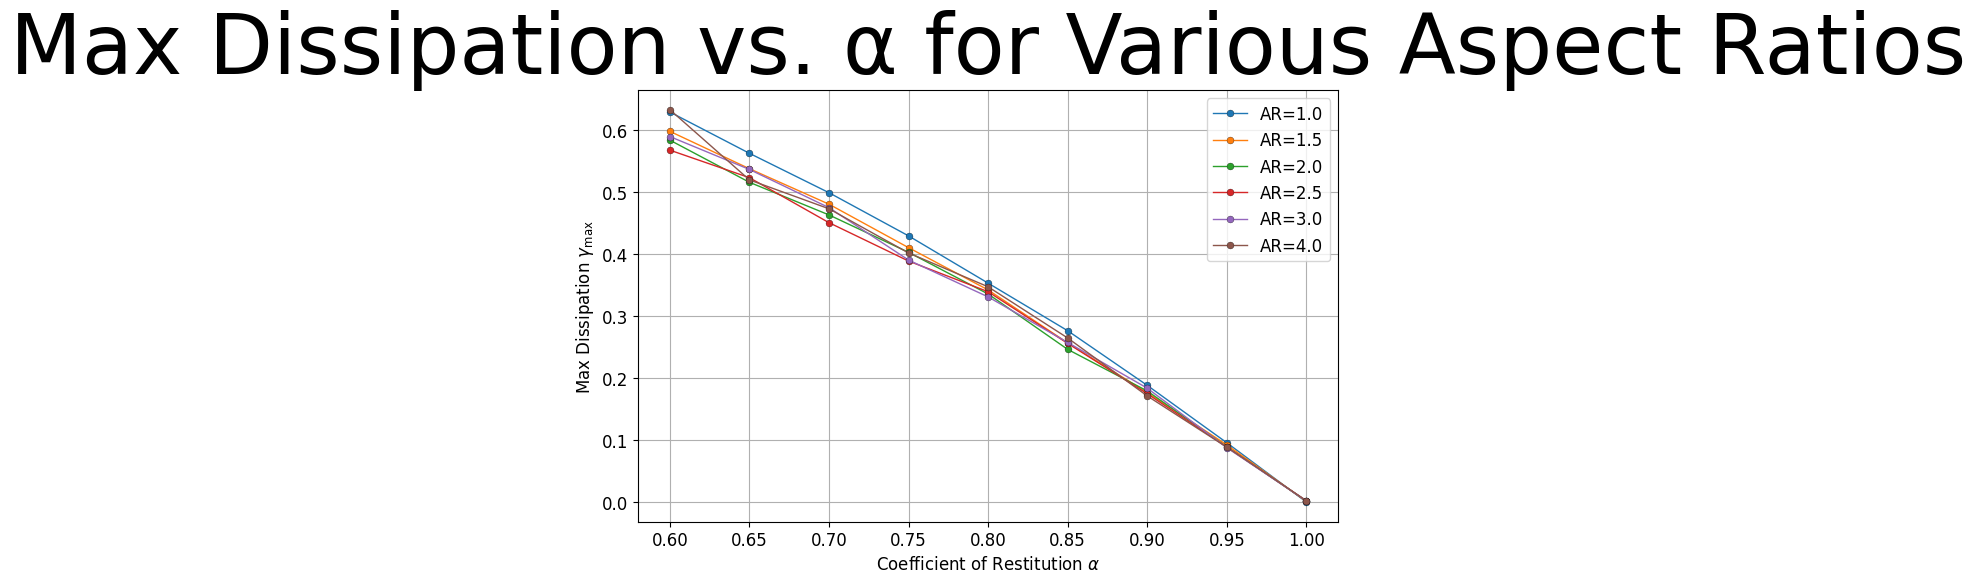

In [970]:
root_dir = "/home/muhammed/Documents/Thesis/New Simulations/Alpha"
alpha_vals, gamma_matrix = plot_all_ARs(root_dir)

In [356]:
# Evaluate the model at α = 0.75 for example
gamma_predict = np.polyval(coeffs, 0.75)
print(f"Predicted γ_max(α=0.75) ≈ {gamma_predict:.5f}")

Predicted γ_max(α=0.75) ≈ 0.00653


In [357]:
coeffs

array([-1.30766674e-01,  3.68816831e-01, -3.79056497e-01,  1.41031631e-01,
       -2.39499267e-04])

In [678]:
# Re-import libraries after code environment reset
import os
import numpy as np
import matplotlib.pyplot as plt

def load_and_process_Edata_filtered(file_dir):
    """Loads NPhit.txt and Ef.txt, computes max dissipation only for single-hit events."""
    try:
        nphit_path = os.path.join(file_dir, "NPhit.txt")
        ef_path = os.path.join(file_dir, "Ef.txt")

        nphit = np.loadtxt(nphit_path, dtype=int)
        E_data = np.loadtxt(ef_path)

        # Filter to only indices where number of hits is 1
        valid_indices = np.where(nphit == 1)[0]
        if valid_indices.size == 0:
            return np.nan

        E_data = E_data[valid_indices]
        pre_coll_energy = E_data[:, 0] + E_data[:, 1] + E_data[:, 2]
        post_coll_energy = E_data[:, 3] + E_data[:, 4] + E_data[:, 5]
        dissp_energy = (pre_coll_energy - post_coll_energy) / pre_coll_energy

        return np.max(dissp_energy)
    except Exception as e:
        print(f"Failed to process in {file_dir}: {e}")
        return None

def plot_all_ARs_filtered(root_dir):
    AR_dirs = ['10', '15', '20', '25', '30']
    AR_vals = [int(ar)/10.0 for ar in AR_dirs]

    alpha_dirs = sorted([d for d in os.listdir(root_dir)
                         if os.path.isdir(os.path.join(root_dir, d)) and d.isdigit()],
                         key=lambda x: int(x))
    
    alpha_vals = [int(a)/100.0 for a in alpha_dirs]
    gamma_matrix = []

    plt.figure(figsize=(8, 6))

    for AR_dir, AR_val in zip(AR_dirs, AR_vals):
        gamma_max_vals = []

        for alpha_dir in alpha_dirs:
            folder_path = os.path.join(root_dir, alpha_dir, AR_dir)
            if os.path.exists(os.path.join(folder_path, "Ef.txt")) and os.path.exists(os.path.join(folder_path, "NPhit.txt")):
                gamma_max = load_and_process_Edata_filtered(folder_path)
                gamma_max_vals.append(gamma_max)
            else:
                gamma_max_vals.append(np.nan)
                
        gamma_matrix.append(gamma_max_vals)
        plt.plot(alpha_vals, gamma_max_vals, '-o', label=f'AR={AR_val}', markersize=5)

    plt.xlabel(r'Coefficient of Restitution $\alpha$')
    plt.ylabel(r'Max Dissipation $\gamma_{\max}$ (Single-hit Only)')
    plt.title("Filtered Max Dissipation vs. α for Various Aspect Ratios")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return alpha_vals, gamma_matrix

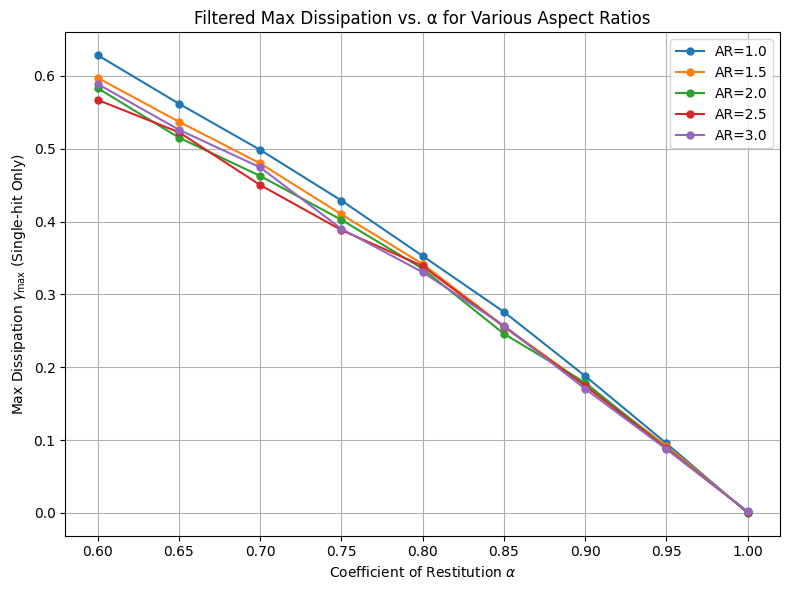

In [679]:
# Set root directory again
root_dir = "/home/muhammed/Documents/Thesis/New Simulations/Alpha"
alpha_vals2, gamma_matrix2 = plot_all_ARs_filtered(root_dir)

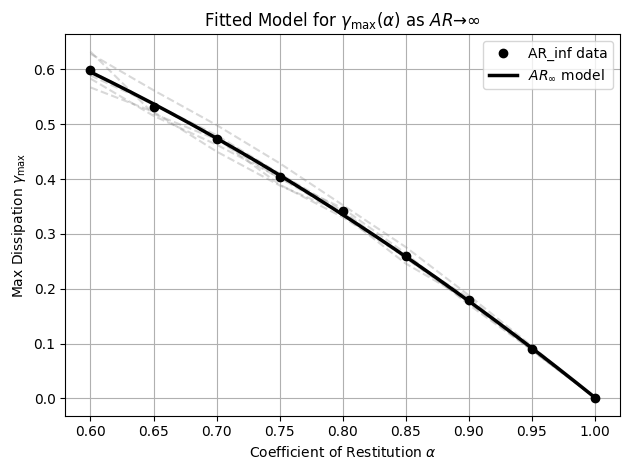

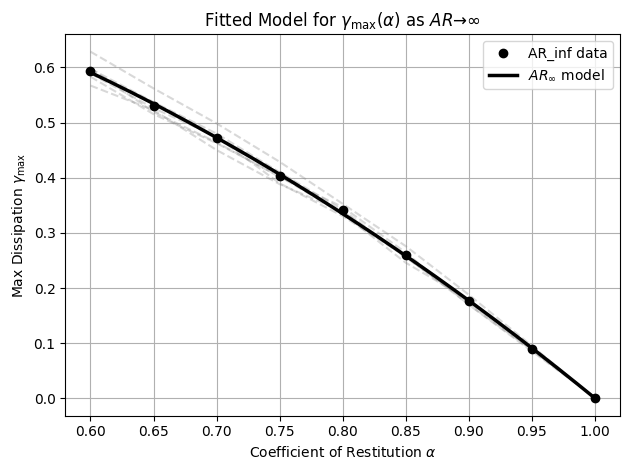

In [360]:
# Fit the AR_inf model (mean of all ARs)
coeffs1 = fit_AR_inf_model(alpha_vals, gamma_matrix)
coeffs2 = fit_AR_inf_model(alpha_vals2, gamma_matrix2)

In [26]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma
from scipy.integrate import simps

# Load max dissipation values from each folder
def load_and_process_Edata_filtered(file_dir):
    try:
        nphit = np.loadtxt(os.path.join(file_dir, "NPhit.txt"), dtype=int)
        E_data = np.loadtxt(os.path.join(file_dir, "Ef.txt"))
        valid_indices = np.where(nphit == 1)[0]
        if valid_indices.size == 0:
            return np.nan
        E_data = E_data[valid_indices]
        pre = E_data[:, :3].sum(axis=1)
        post = E_data[:, 3:].sum(axis=1)
        return np.max((pre - post) / pre)
    except:
        return np.nan

# Main plotting routine
def plot_dissipation_model(root_dir):
    AR_dirs = ['15', '20', '25', '30']
    AR_vals = [int(ar)/10.0 for ar in AR_dirs]

    alpha_dirs = sorted([d for d in os.listdir(root_dir) if d.isdigit()])
    alpha_vals = [int(a)/100.0 for a in alpha_dirs]

    gamma_matrix = []
    import matplotlib.patches as mpatches
    eps = [0.62, 0.565, 0.50, 0.4275, 0.36, 0.2775, 0.19, 0.0975, 0.0]
    alphas = [0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]

    fig,ax = plt.subplots();
    #ax.yaxis.set_major_formatter(formatter)

    # Distinct markers for each AR
    markers = ['o', '^', 'v', 's', 'D', 'X', '*']
    ax.scatter(alphas, eps, marker=markers[0], color=colors[0], label=fr'1.0', zorder=3)
    for i, (AR_dir, AR_val) in enumerate(zip(AR_dirs, AR_vals)):
        gamma_max_vals = []
        for alpha_dir in alpha_dirs:
            folder = os.path.join(root_dir, alpha_dir, AR_dir)
            if os.path.exists(os.path.join(folder, "Ef.txt")):
                gamma = load_and_process_Edata_filtered(folder)
                gamma_max_vals.append(gamma)
            else:
                gamma_max_vals.append(np.nan)
        gamma_matrix.append(gamma_max_vals)
        ax.scatter(alpha_vals, gamma_max_vals,
                   marker=markers[i+1], color=colors[i+1],
                   label=fr'{AR_val}', zorder=3)

    # Convert to array and fit AR_inf model
    gamma_matrix = np.array(gamma_matrix)
    gamma_avg = np.nanmean(gamma_matrix, axis=0)
    coeffs = np.polyfit(alpha_vals, gamma_avg, deg=2)
    alpha_fit = np.linspace(min(alpha_vals), max(alpha_vals), 300)
    gamma_fit = lambda x: 1 - x**2

    # Plot model line
    ax.plot(alpha_fit, gamma_fit(alpha_fit), '--', color='black', linewidth=1, zorder=2)


    # Axis labels
    ax.set_xlabel(r'$\alpha$', fontsize=14)
    ax.set_ylabel(r'$\delta \varepsilon_{\max}$', fontsize=14)
    aspect = 1.0
    ax.set_xlim([0.55,1.05])
    ax.set_ylim([-0.05,0.65])
    xval, yval = ax.get_xlim(), ax.get_ylim()
    xrange = xval[1]-xval[0];
    yrange = yval[1]-yval[0];
    ax.set_aspect(aspect*(xrange/yrange), adjustable='box')

    # Legend with visible box and line under title
    legend1 = ax.legend(title=r'AR', fontsize=12, title_fontsize=14, frameon=True)
    legend1.get_frame().set_edgecolor('black')
    legend1.get_frame().set_linewidth(0.8)
    ax.add_artist(legend1)
    
    from matplotlib.lines import Line2D
    model_handle = Line2D([0], [0], color='black', linestyle='--', lw=1, label=r'$1 - \alpha^2$')
    ax.legend(handles=[model_handle], loc='lower left', bbox_to_anchor=(0.22, 0.32), frameon=False, fontsize=14)

    mng = plt.get_current_fig_manager()
    mng.full_screen_toggle()
    
    ax.tick_params(direction='in', top=True, right=True)
    plt.tight_layout()
    plt.savefig('gamma_max.eps',bbox_inches='tight')
    plt.show()

    return coeffs

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


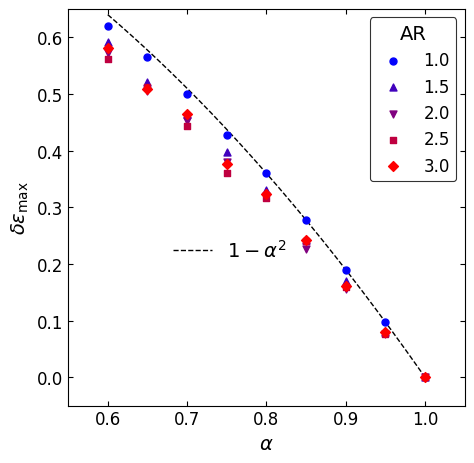

In [27]:
# Usage
root_dir = "/home/muhammed/Documents/Thesis/New Simulations/Alpha"
coeffs = plot_dissipation_model(root_dir)

In [871]:
coeffs

array([-0.79113006, -0.19782645,  0.98575351])

In [361]:
gamma_max = np.polyval(coeffs1, 0.95)
gamma_max

0.09197746416454122

In [971]:
# Load NPhit.txt
nphit = np.loadtxt("/home/muhammed/Documents/Thesis/New Simulations/Alpha/100/20/NPhit.txt", dtype=int)

# Total number of hits (sum of all hits across all rows)
total_hits = np.sum(nphit)

# Number of rows that have only 1 hit
one_hit_rows = np.sum(nphit == 1)

# Ratio of 1-hit rows to total number of hits
ratio_one_hit_to_total_hits = one_hit_rows / total_hits

total_hits, one_hit_rows, ratio_one_hit_to_total_hits


(88558, 72363, 0.817125499672531)

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import yt
import math
from matplotlib import ticker
from colormap import rgb2hex                         # keep if you prefer it
# NEW ────────────────────────────────────────────────────────────────────────
# axes_grid → axes_grid1   (same functionality, maintained sub-package)
from mpl_toolkits.axes_grid1.inset_locator import (
    inset_axes, InsetPosition, mark_inset
)
# ────────────────────────────────────────────────────────────────────────────

# --------------------------------------------------------------------------
# Matplotlib global style
# --------------------------------------------------------------------------
plt.rc("text", usetex=False)
plt.rc("font", size=12)
plt.rc("axes", titlesize=60)
plt.rcParams.update({
    "legend.fontsize": 12,
    "lines.markersize": 5,
    "lines.markeredgecolor": "k",
    "lines.markeredgewidth": 0.2,
    "lines.linewidth": 1.0,
})

formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-1, 1))

# --------------------------------------------------------------------------
# Plot parameters
# --------------------------------------------------------------------------
aspect = 1.0

# Custom colour palette (red → blue gradient)
ncol = 5
red  = np.array([254,   0,   2], dtype=int)
blue = np.array([  3,   2, 252], dtype=int)

c1 = np.linspace(red[0],  blue[0],  ncol, dtype=int)
c2 = np.linspace(red[1],  blue[1],  ncol, dtype=int)
c3 = np.linspace(red[2],  blue[2],  ncol, dtype=int)

colors = [rgb2hex(r, g, b) for r, g, b in zip(c1, c2, c3)][::-1]

markers = ["o", "^", "v", "s", "D", "X", "*"]

In [50]:
import os
import numpy as np
import matplotlib.pyplot as plt

def compute_one_hit_ratio(nphit_path):
    """Reads NPhit.txt and computes the ratio of 1-hit rows to total hits."""
    try:
        nphit = np.loadtxt(nphit_path, dtype=int)
        total_hits = np.sum(nphit)
        one_hit_rows = np.sum(nphit == 1)
        return one_hit_rows / total_hits if total_hits > 0 else np.nan
    except Exception as e:
        print(f"Failed to process {nphit_path}: {e}")
        return None

def plot_one_hit_ratios(root_dir):
    AR_dirs = ['10','15', '20', '25', '30']
    AR_vals = [int(ar)/10.0 for ar in AR_dirs]

    alpha_dirs = sorted([d for d in os.listdir(root_dir)
                         if os.path.isdir(os.path.join(root_dir, d)) and d.isdigit()],
                         key=lambda x: int(x))

    alpha_vals = [int(a)/100.0 for a in alpha_dirs]
    one_hit_matrix = []

    fig,ax = plt.subplots();
    markers = ['o', '^', 'v', 's', 'D', 'X', '*']
    i = 0
    for AR_dir, AR_val in zip(AR_dirs, AR_vals):
        ratios = []
        for alpha_dir in alpha_dirs:
            nphit_path = os.path.join(root_dir, alpha_dir, AR_dir, "NPhit.txt")
            if os.path.exists(nphit_path):
                ratio = compute_one_hit_ratio(nphit_path)
                ratios.append(ratio)
            else:
                ratios.append(np.nan)
        one_hit_matrix.append(ratios)
        ax.scatter(alpha_vals, ratios, marker=markers[i], color=colors[i], label=fr'{AR_val}', zorder=3)
        i+=1

    ax.set_xlabel(r'$\alpha$')
    ax.set_ylabel(r'Pr(1-hit)')
    ax.legend()
    plt.show()

    return alpha_vals, AR_vals, one_hit_matrix

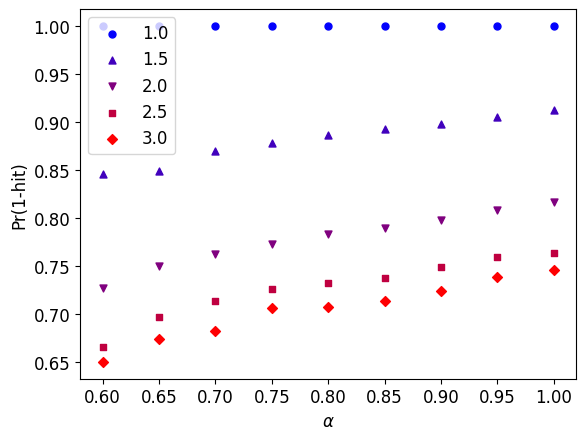

In [51]:
# Define your directory and run
root_dir = "/home/muhammed/Documents/Thesis/New Simulations/Alpha"
alpha_vals, AR_vals, one_hit_matrix = plot_one_hit_ratios(root_dir)

In [52]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Prepare inputs
X = np.array([[alpha, AR] for AR in AR_vals for alpha in alpha_vals])
y = np.array([ratio for row in one_hit_matrix for ratio in row])

# Fit 2D polynomial model
poly = PolynomialFeatures(degree=3, include_bias=True)
X_poly = poly.fit_transform(X)

model_one_hit = LinearRegression()
model_one_hit.fit(X_poly, y)

model_one_hit.predict(poly.transform([[0.9, 2]]))

array([0.80435061])

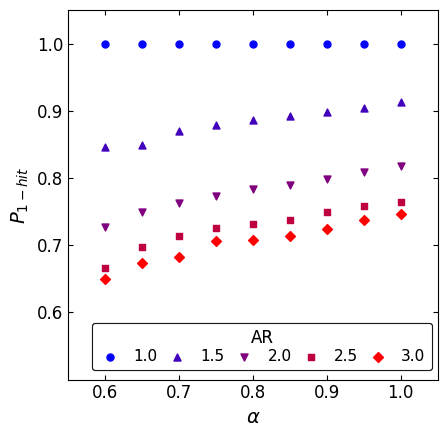

In [58]:
def plot_comparison_with_predictions(alpha_vals, AR_vals, one_hit_matrix, model, poly):
    """Overlay actual data and model predictions for direct comparison."""
    
    fig,ax = plt.subplots();
    markers = ['o', '^', 'v', 's', 'D', 'X', '*']
    for j, AR in enumerate(AR_vals):
        actual = one_hit_matrix[j]
        ax.scatter(alpha_vals, actual, marker=markers[j], color=colors[j], label=fr'{AR}', zorder=3)
        
        if AR != 1.0:
            predicted_inputs = np.array([[alpha, AR] for alpha in alpha_vals])
            predicted_poly = poly.transform(predicted_inputs)
            predicted = model.predict(predicted_poly)
            #ax.plot(alpha_vals, predicted, '--', color=colors[j], zorder=2)

    ax.set_xlim([0.55,1.05])
    ax.set_ylim([0.5,1.05])
    xval, yval = ax.get_xlim(), ax.get_ylim()
    xrange = xval[1]-xval[0];
    yrange = yval[1]-yval[0];
    aspect= 1
    ax.set_aspect(aspect*(xrange/yrange), adjustable='box')

    ax.tick_params(axis='both',direction='in',which='both',right=True,top=True)
    #ax.minorticks_on()
    legend1 = ax.legend(
        loc='lower right',
        bbox_to_anchor=(1.0, 0.01),  # tight to bottom-right
        borderaxespad=0.4,
        handlelength=1.5,
        handletextpad=0.8,
        labelspacing=0.1,      # spacing between rows
        columnspacing=0.5,
        ncol=5,
        fontsize=11,
        frameon=True,
        title=r'AR',
        title_fontsize=12
    )
    legend1.get_frame().set_edgecolor('black')
    legend1.get_frame().set_linewidth(0.8)
    ax.add_artist(legend1)
    
    #ax.xticks([0.2, 0.4, 0.6, 0.8, 1.0, 1.2])
    ax.set_yticks([0.6, 0.7, 0.8, 0.9, 1.0])
    
    from matplotlib.lines import Line2D
    model_handle = Line2D([0], [0], color='black', lw=1.5, linestyle='--', label=r'$P_{1-hit}^*(\alpha, AR)$')
    #ax.legend(handles=[model_handle], loc='lower right', bbox_to_anchor=(1.0, 0.15), fontsize=11, frameon=False)
    
    ax.set_xlabel(r'$\alpha$', fontsize=14)
    ax.set_ylabel(r'$P_{1-hit}$', fontsize=14)
    mng = plt.get_current_fig_manager()
    mng.full_screen_toggle()
    plt.savefig('Pr1hit.png',bbox_inches='tight')
    plt.show()

# Example usage:
plot_comparison_with_predictions(alpha_vals, AR_vals, one_hit_matrix, model_one_hit, poly)


In [367]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import numpy as np

# Reuse the model and poly if already defined
# Export polynomial model parameters to a file
def export_polynomial_model(poly, model, filename="prob_one_hit.dat"):
    coeffs = model.coef_
    intercept = model.intercept_
    feature_names = poly.get_feature_names_out(["alpha", "AR"])
    
    with open(filename, "w") as f:
        f.write(f"{len(coeffs)}\n")
        for name, coef in zip(feature_names, coeffs):
            f.write(f"{coef:.16e}\n")
        f.write(f"{intercept:.16e}\n")
    
    return coeffs, intercept

coeffs_hit, intercept_hit = export_polynomial_model(poly, model)

In [368]:
coeffs_hit

array([ 0.00000000e+00,  3.45017106e+00, -9.50753267e-01, -4.07536783e+00,
        1.33131343e-01,  2.65121843e-01,  1.58283424e+00,  3.51466283e-03,
       -2.28809482e-02, -2.45510886e-02])

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import yt
import math
from matplotlib import ticker
from colormap import rgb2hex                         # keep if you prefer it
# NEW ────────────────────────────────────────────────────────────────────────
# axes_grid → axes_grid1   (same functionality, maintained sub-package)
from mpl_toolkits.axes_grid1.inset_locator import (
    inset_axes, InsetPosition, mark_inset
)
# ────────────────────────────────────────────────────────────────────────────

# --------------------------------------------------------------------------
# Matplotlib global style
# --------------------------------------------------------------------------
plt.rc("text", usetex=False)
plt.rc("font", size=12)
plt.rc("axes", titlesize=60)
plt.rcParams.update({
    "legend.fontsize": 12,
    "lines.markersize": 5,
    "lines.markeredgecolor": "k",
    "lines.markeredgewidth": 0.2,
    "lines.linewidth": 1.0,
})

formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(False)
formatter.set_powerlimits((-1, 1))

# --------------------------------------------------------------------------
# Plot parameters
# --------------------------------------------------------------------------
aspect = 1.0

# Custom colour palette (red → blue gradient)
ncol = 5
red  = np.array([254,   0,   2], dtype=int)
blue = np.array([  3,   2, 252], dtype=int)

c1 = np.linspace(red[0],  blue[0],  ncol, dtype=int)
c2 = np.linspace(red[1],  blue[1],  ncol, dtype=int)
c3 = np.linspace(red[2],  blue[2],  ncol, dtype=int)

colors = [rgb2hex(r, g, b) for r, g, b in zip(c1, c2, c3)][::-1]

markers = ["o", "^", "v", "s", "D", "X", "*"]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


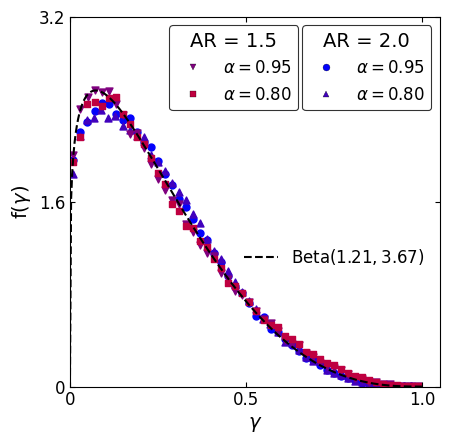

In [38]:
def load_and_process_Edata(file_path):
    E_data = np.loadtxt(file_path)
    pre_coll_energy = E_data[:, 0] + E_data[:, 1] + E_data[:, 2]
    post_coll_energy = E_data[:, 3] + E_data[:, 4] + E_data[:, 5]
    dissp_energy = (pre_coll_energy - post_coll_energy)/pre_coll_energy
    max_dissp = max(dissp_energy)
    dissp_energy2 = (dissp_energy/max_dissp)
    return dissp_energy2

file_list1 = [
    '/home/muhammed/Documents/Thesis/New Simulations/Alpha/95/20/Ef.txt',
    '/home/muhammed/Documents/Thesis/New Simulations/Alpha/80/20/Ef.txt',
]
label = [r'$\alpha = 0.95$', r'$\alpha=0.80$']

file_list2 = [
    '/home/muhammed/Documents/Thesis/New Simulations/Alpha/95/15/Ef.txt',
    '/home/muhammed/Documents/Thesis/New Simulations/Alpha/80/15/Ef.txt',
]
fig,ax = plt.subplots();
from matplotlib.ticker import FuncFormatter

# Custom formatter: return '0' for 0, otherwise default formatting
formatter1 = FuncFormatter(lambda x, _: '0' if x == 0 else f'{x:.1f}')
formatter2 = FuncFormatter(lambda x, _: '0' if x == 0 else f'{x:.1f}')
ax.yaxis.set_major_formatter(formatter1)
ax.xaxis.set_major_formatter(formatter2)

for j, file_path in enumerate(file_list1):
    dissp = load_and_process_Edata(file_path)
    hist_data, bin_edges = np.histogram(dissp, bins=50, density=True)
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    ax.scatter(bin_centers, hist_data, label=f'{label[j]}', marker=markers[j], color=colors[j])
    
for j, file_path in enumerate(file_list2):
    dissp = load_and_process_Edata(file_path)
    hist_data, bin_edges = np.histogram(dissp, bins=50, density=True)
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    ax.scatter(bin_centers, hist_data, label=f'{label[j]}', marker=markers[j+2], color=colors[j+2])

from scipy.stats import beta

a_fit = 1.211
b_fit = 3.672
loc_fit = 0  # Location parameter (already fitted to 0)
scale_fit = 1  # Scale parameter (already fitted to 1) 
gamma_vals = np.linspace(0, 1, 300)
beta_pdf = beta.pdf(gamma_vals, a_fit, b_fit, loc=loc_fit, scale=scale_fit)
ax.plot(gamma_vals, beta_pdf, color='black', linestyle='--', linewidth=1.5,
        label=r'$\mathrm{Beta}(\alpha=1.211,\ \beta=3.672)$')
    
ax.set_xlim([0,1.05])
ax.set_ylim([0,3.2])
ax.set_ylabel(r'f($\gamma$)', fontsize=14)
ax.set_xlabel(r'$\gamma$', fontsize=14)
xval, yval = ax.get_xlim(), ax.get_ylim()
xrange = xval[1]-xval[0];
yrange = yval[1]-yval[0];
ax.set_aspect(aspect*(xrange/yrange), adjustable='box')
ax.set_xticks([0, 0.5, 1.0])
ax.set_yticks([0, 1.6, 3.2])
ax.tick_params(axis='both',direction='in',which='both',right=True,top=True)
from matplotlib.lines import Line2D

beta_line = Line2D([0], [0], color='black', lw=1.5, linestyle='--',
                   label=r'$\mathrm{Beta}(1.21, 3.67)$')
legend3 = ax.legend(handles=[beta_line], loc='center right', bbox_to_anchor=(1.0, 0.35),fontsize=12, frameon=False)
ax.add_artist(legend3)

# Custom handles for AR=2.0
legend1_handles = [
    Line2D([0], [0], marker=markers[0], color='none', markerfacecolor=colors[0], label=r'$\alpha = 0.95$'),
    Line2D([0], [0], marker=markers[1], color='none', markerfacecolor=colors[1], label=r'$\alpha = 0.80$')
]

# Custom handles for AR=1.5
legend2_handles = [
    Line2D([0], [0], marker=markers[2], color='none', markerfacecolor=colors[2], label=r'$\alpha = 0.95$'),
    Line2D([0], [0], marker=markers[3], color='none', markerfacecolor=colors[3], label=r'$\alpha = 0.80$')
]

# Legend for AR=2.0
legend1 = ax.legend(handles=legend1_handles, title=r'AR = 2.0',
                    loc='upper right', bbox_to_anchor=(1.0, 1.0),
                    fontsize=12, title_fontsize=14, frameon=True)
legend1.get_frame().set_edgecolor('black')
legend1.get_frame().set_linewidth(0.8)
ax.add_artist(legend1)

# Legend for AR=1.5
legend2 = ax.legend(handles=legend2_handles, title=r'AR = 1.5',
                    loc='upper right', bbox_to_anchor=(0.64, 1.0),
                    fontsize=12, title_fontsize=14, frameon=True)
legend2.get_frame().set_edgecolor('black')
legend2.get_frame().set_linewidth(0.8)

mng = plt.get_current_fig_manager()
mng.full_screen_toggle()
plt.savefig('Gamma.eps',bbox_inches='tight')
plt.show()

In [981]:
import numpy as np
from scipy.stats import beta

# Estimated parameters for the Beta distribution
a_fit = 1.211
b_fit = 3.672
loc_fit = 0  # Location parameter (already fitted to 0)
scale_fit = 1  # Scale parameter (already fitted to 1)

# Function to sample a single value from the Beta distribution
def sample_dissp(a, b, loc=0, scale=1):
    return beta.rvs(a, b, loc=loc, scale=scale, size=1)[0]

# Generate one sample
sample = sample_dissp(a_fit, b_fit, loc_fit, scale_fit)
print(f"Sampled value: {sample}")

Sampled value: 0.2982099863240151


In [982]:
def update_velocities(velA, velB, chi, eps, crmag):
    coschi = np.cos(chi)
    sinchi = np.sin(chi)
    coseps = np.cos(eps)
    sineps = np.sin(eps)
    
    vcom = (velA + velB) * 0.5
    crA = velA - vcom
    crB = velB - vcom
    crmagA = np.linalg.norm(crA)  # Compute magnitude using np.linalg.norm
    crmagB = np.linalg.norm(crB)

    ur, vr, wr = crA
    vrwr = np.sqrt(vr ** 2 + wr ** 2)

    if vrwr >= 1.0E-8:
        crel = [
            coschi * ur + sinchi * sineps * vrwr,
            coschi * vr + sinchi * (crmagA * wr * coseps - ur * vr * sineps) / vrwr,
            coschi * wr - sinchi * (crmagA * vr * coseps + ur * wr * sineps) / vrwr
        ]
    else:
        crel = [
            coschi * vr + sinchi * (crmagA * coseps - ur * sineps),
            coschi * wr - sinchi * (crmagA * coseps + ur * sineps),
            0.0
        ]

    crelf = np.array(crel).reshape(1, 3)  # Reshape to (1, 3) array
    crelf_mag = np.linalg.norm(crelf)
    crelf = crelf/crelf_mag

    crmagA = crmag
    crmagB = crmag

    # Update velocities
    velA = vcom + crelf * crmagA
    velB = vcom - crelf * crmagB

    return velA, velB

In [1017]:
E_data = np.loadtxt('/home/muhammed/Documents/Thesis/New Simulations/GMM/AR30/r10/Ef.txt')  # shape (N,)

pre_Er1 = E_data[:, 1] + E_data[:, 2]
post_Er1 = E_data[:, 4] + E_data[:, 5]

pre_Etran = E_data[:, 1]
post_Etran = E_data[:, 3]

dE_Er = pre_Er1 - post_Er1
dE_Etr = pre_Etran - post_Etran

dE_Er = np.abs(dE_Er)
kb_T_rot = np.mean(dE_Er)

kb_T_rot


1.7511668844234998

In [1024]:
def quadratic_model(C, a, b, c):
    return a * C**2 + b * C + c

a, b, c_AR2 = 0.3884, 0.0924, 0.48
c_AR15 = 0.96  # Shift down for AR=1.5
c_AR25 = 0.13  # Shift up for AR=2.5
C = np.linspace(0.05, 1.2, 100)
ZR_AR25 = quadratic_model(C, a, b, c_AR25)
ZR_AR2 = quadratic_model(C, a, b, c_AR2)
ZR_AR15 = quadratic_model(C, a, b, c_AR15)

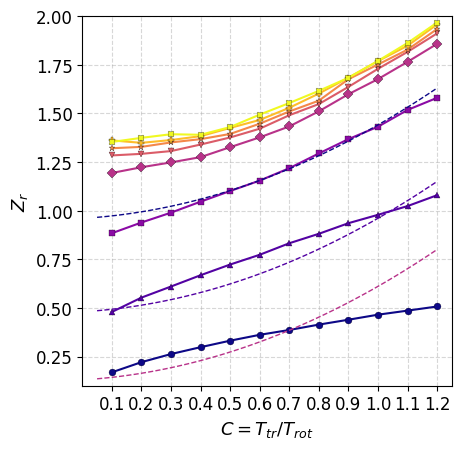

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Root directory
base_dir = "/home/muhammed/Documents/Thesis/New Simulations/GMM"

# Sorted list of AR directories
ar_dirs = sorted([d for d in os.listdir(base_dir) if d.startswith("AR")])

# C values: 0.1 to 1.2
C_vals = [round(0.1 * (i + 1), 1) for i in range(12)]

# Storage for Zr vs C per AR
Zr_data = {}

# Loop over aspect ratio directories
for ar_dir in ar_dirs:
    full_ar_path = os.path.join(base_dir, ar_dir)
    if not os.path.isdir(full_ar_path):
        continue

    Zr_list = []

    # Loop over realizations r01 to r12 (theta = 0.1 to 1.2)
    for i in range(1, 13):
        r_folder = f"r{str(i).zfill(2)}"
        ef_path = os.path.join(full_ar_path, r_folder, "Ef.txt")

        try:
            E_data = np.loadtxt(ef_path)
            pre_Er1 = E_data[:, 1] + E_data[:, 2]
            post_Er1 = E_data[:, 4] + E_data[:, 5]
            dE_Er = np.abs(pre_Er1 - post_Er1)
            Zr = np.mean(dE_Er)
            Zr_list.append(Zr)
        except Exception as e:
            print(f"Skipping {ef_path}: {e}")
            Zr_list.append(np.nan)  # Placeholder if file missing

    Zr_data[ar_dir] = Zr_list

# Plotting
fig,ax = plt.subplots();
markers = ['o', '^', 's', 'D', 'v', '*', 'P', 'X']
colors = plt.cm.plasma(np.linspace(0, 1, len(Zr_data)))

for i, (ar_dir, Zr_list) in enumerate(sorted(Zr_data.items())):
    AR_str = ar_dir.replace("AR", "AR ")
    ax.plot(C_vals, Zr_list, label=AR_str, marker=markers[i % len(markers)],
             color=colors[i], linestyle='-', linewidth=1.5, markersize=5)

ax.plot(C, ZR_AR15, '--',  color=colors[0])
ax.plot(C, ZR_AR2, '--',  color=colors[1])
ax.plot(C, ZR_AR25, '--',  color=colors[3])
# Aesthetics
ax.set_xlabel(r'$C = T_{tr}/T_{rot}$', fontsize=13)
ax.set_ylabel(r'$Z_r$', fontsize=13)
ax.set_xticks(np.arange(0.1, 1.3, 0.1))
ax.set_xlim([0,1.25])
ax.set_ylim(0.1, 2.0)
xval, yval = ax.get_xlim(), ax.get_ylim()
xrange = xval[1]-xval[0];
yrange = yval[1]-yval[0];
ax.set_aspect(aspect*(xrange/yrange), adjustable='box')
#ax.grid(True, linestyle='--', alpha=0.5)
#ax.legend(fontsize=10, loc='upper left', frameon=True)
plt.show()

In [1158]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import pandas as pd

def extract_ar(folder_name):
    raw = folder_name.replace("AR", "")
    
    if "_" in raw:
        # case like AR12_5 → 12.5
        return float(raw.replace("_", "."))
    elif len(raw) == 3:
        # AR125 → 1.25 (insert decimal after 1st digit)
        return float(raw[0] + "." + raw[1:])
    elif len(raw) == 2:
        # AR11 → 1.1
        return float(raw[0] + "." + raw[1])
    else:
        raise ValueError(f"Unexpected folder name format: {folder_name}")



# Root directory
base_dir = "/home/muhammed/Documents/Thesis/New Simulations/GMM2"

# Sorted list of AR directories
ar_dirs = sorted([d for d in os.listdir(base_dir) if d.startswith("AR")])

# C values: 0.1 to 1.2
C_vals = np.array([round(0.1 * (i + 1), 1) for i in range(12)])

# Storage for regression input
theta_list = []
AR_list = []
Zr_list = []

# Collect data from directories
for ar_dir in ar_dirs:
    full_ar_path = os.path.join(base_dir, ar_dir)
    if not os.path.isdir(full_ar_path):
        continue

    try:
        AR_value = extract_ar(ar_dir)
    except ValueError:
        continue

    for i, theta in enumerate(C_vals):
        r_folder = f"r{str(i + 1).zfill(2)}"
        ef_path = os.path.join(full_ar_path, r_folder, "Ef.txt")

        try:
            E_data = np.loadtxt(ef_path)
            pre_Er1 = E_data[:, 1] + E_data[:, 2]
            post_Er1 = E_data[:, 4] + E_data[:, 5]
            dE_Er = np.abs(pre_Er1 - post_Er1)
            Zr = np.mean(dE_Er)

            theta_list.append(theta)
            AR_list.append(AR_value)
            Zr_list.append(Zr)
        except Exception as e:
            continue

# Convert to numpy arrays
X_data = np.array(list(zip(theta_list, AR_list)))  # shape (N, 2)
y_data = np.array(Zr_list)  # shape (N,)

# Return the input arrays for regression preview
df = pd.DataFrame({
    'theta (C)': theta_list,
    'Aspect Ratio (AR)': AR_list,
    'Z_r': Zr_list
})


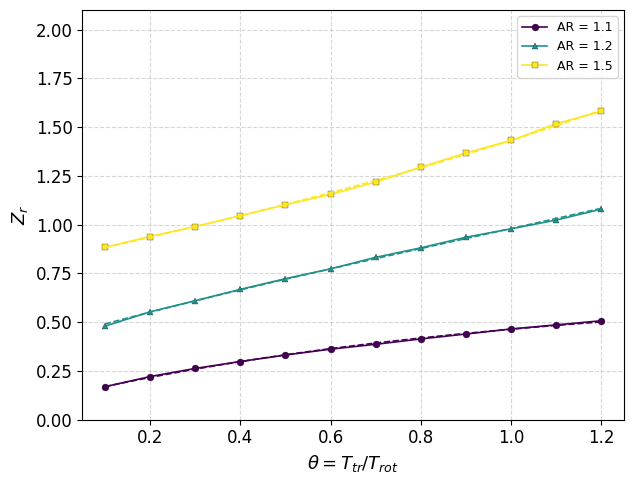

In [1160]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import pandas as pd

# Assume df already exists with 'theta (C)', 'Aspect Ratio (AR)', 'Z_r'
X_data = df[['theta (C)', 'Aspect Ratio (AR)']].values
y_data = df['Z_r'].values

# Polynomial feature transformation
degree = 3  # You can increase to 3 if necessary
poly = PolynomialFeatures(degree=degree, include_bias=True)
X_poly = poly.fit_transform(X_data)

# Fit the model
model1 = LinearRegression()
model1.fit(X_poly, y_data)

# Generate predictions over a grid
theta_vals = np.linspace(0.1, 1.2, 50)
AR_vals = sorted(df['Aspect Ratio (AR)'].unique())

# Meshgrid for predictions
Theta_grid, AR_grid = np.meshgrid(theta_vals, AR_vals)
X_pred_grid = np.column_stack((Theta_grid.ravel(), AR_grid.ravel()))
X_pred_poly = poly.transform(X_pred_grid)
Z_pred = model1.predict(X_pred_poly).reshape(len(AR_vals), len(theta_vals))

# Plotting
fig, ax = plt.subplots(figsize=(6.5, 5))
markers = ['o', '^', 's', 'D', 'v', '*', 'P', 'X']
colors = plt.cm.viridis(np.linspace(0, 1, len(AR_vals)))

for i, AR in enumerate(AR_vals):
    mask = df['Aspect Ratio (AR)'] == AR
    ax.plot(df[mask]['theta (C)'], df[mask]['Z_r'],
            marker=markers[i % len(markers)], color=colors[i],
            label=fr'AR = {AR:.1f}', linestyle='-', linewidth=1.2)

    ax.plot(theta_vals, Z_pred[i], '--', color=colors[i], linewidth=1.2)

# Labels and grid
ax.set_xlabel(r'$\theta = T_{tr}/T_{rot}$', fontsize=13)
ax.set_ylabel(r'$Z_r$', fontsize=13)
ax.set_xlim(0.05, 1.25)
ax.set_ylim(0.0, 2.1)
ax.grid(True, linestyle='--', alpha=0.5)
ax.legend(fontsize=9)
plt.tight_layout()
plt.show()

In [1162]:
coeffs = model1.coef_
intercept = model1.intercept_
coeffs

array([ 0.        , -4.25538406,  1.34942684, -0.9994194 ,  7.58635   ,
        1.53619157,  0.05190488,  0.68581203, -2.93442562, -0.69785395])

In [1163]:
def Zr_model(theta, AR):
    X_input = poly.transform(np.array([[theta, AR]]))
    return model1.predict(X_input)[0]

Z = Zr_model(1, 1.25)
Z

0.9800078299977013

In [1165]:
intercept

-2.2963429723660234

In [1170]:
def compute_Zr_ref(AR, coeffs):
    """
    Computes Zr_ref(AR) by removing the constant AR-dependent terms
    and evaluating the remainder at theta=1.
    
    Parameters:
    -----------
    AR : float
        Aspect ratio to evaluate.
    coeffs : array-like, shape (10,)
        Coefficients from the polynomial regression (excluding intercept).
    intercept : float
        Intercept term from the regression.
    
    Returns:
    --------
    Zr_ref : float
        The value of Zr_ref(AR) that makes the model match Zr=4.3 at theta=1.
    """
    theta = 1.0

    # Polynomial terms: order from PolynomialFeatures(degree=3)
    # [1, theta, AR, theta^2, theta*AR, AR^2, theta^3, theta^2*AR, theta*AR^2, AR^3]
    terms_theta_dependent = (
        coeffs[1]*theta +
        coeffs[3]*theta**2 +
        coeffs[4]*theta*AR +
        coeffs[6]*theta**3 +
        coeffs[7]*theta**2*AR +
        coeffs[8]*theta*AR**2
    )

    # Solve for Zr_ref:
    Zr_ref = 4.3 - terms_theta_dependent

    return Zr_ref


In [1171]:
# Assume these are your values
intercept = -2.2963
coeffs = np.array([0, -4.2554, 1.3494, -0.9994, 7.5864, 1.5362, 0.0519, 0.6858, -2.9344, -0.6979])

# Compute Zr_ref for AR = 1.1
Zr_ref_11 = compute_Zr_ref(1.25, coeffs)
print(f"Zr_ref(AR=1.25) = {Zr_ref_11:.4f}")


Zr_ref(AR=1.25) = 3.7476


In [1076]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import pandas as pd

def extract_ar(folder_name):
    raw = folder_name.replace("AR", "")
    
    if "_" in raw:
        # case like AR12_5 → 12.5
        return float(raw.replace("_", "."))
    elif len(raw) == 3:
        # AR125 → 1.25 (insert decimal after 1st digit)
        return float(raw[0] + "." + raw[1:])
    elif len(raw) == 2:
        # AR11 → 1.1
        return float(raw[0] + "." + raw[1])
    else:
        raise ValueError(f"Unexpected folder name format: {folder_name}")



# Root directory
base_dir = "/home/muhammed/Documents/Thesis/New Simulations/GMM"

# Sorted list of AR directories
ar_dirs = sorted([d for d in os.listdir(base_dir) if d.startswith("AR")])

# C values: 0.1 to 1.2
C_vals = np.array([round(0.1 * (i + 1), 1) for i in range(12)])

# Storage for regression input
theta_list = []
AR_list = []
Zr_list = []

# Collect data from directories
for ar_dir in ar_dirs:
    full_ar_path = os.path.join(base_dir, ar_dir)
    if not os.path.isdir(full_ar_path):
        continue

    try:
        AR_value = extract_ar(ar_dir)
    except ValueError:
        continue

    for i, theta in enumerate(C_vals):
        r_folder = f"r{str(i + 1).zfill(2)}"
        ef_path = os.path.join(full_ar_path, r_folder, "Ef.txt")

        try:
            E_data = np.loadtxt(ef_path)
            pre_Er1 = E_data[:, 1] + E_data[:, 2]
            post_Er1 = E_data[:, 4] + E_data[:, 5]
            dE_Er = np.abs(pre_Er1 - post_Er1)
            Zr = np.mean(dE_Er)

            theta_list.append(theta)
            AR_list.append(AR_value)
            Zr_list.append(Zr)
        except Exception as e:
            continue

# Convert to numpy arrays
X_data = np.array(list(zip(theta_list, AR_list)))  # shape (N, 2)
y_data = np.array(Zr_list)  # shape (N,)

# Return the input arrays for regression preview
df2 = pd.DataFrame({
    'theta (C)': theta_list,
    'Aspect Ratio (AR)': AR_list,
    'Z_r': Zr_list
})

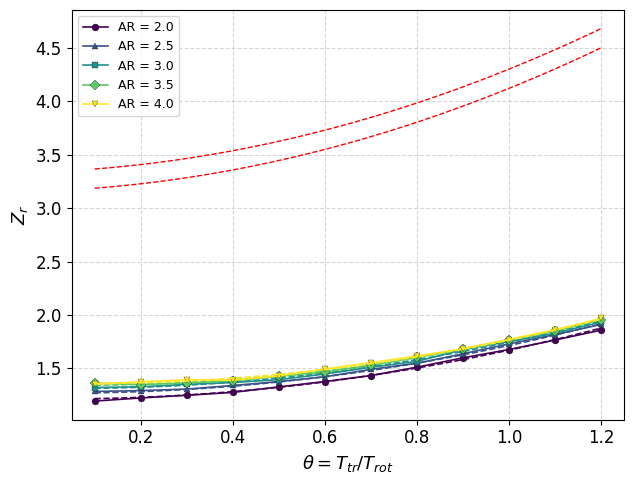

In [1101]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import pandas as pd

# Assume df already exists with 'theta (C)', 'Aspect Ratio (AR)', 'Z_r'
X_data = df2[['theta (C)', 'Aspect Ratio (AR)']].values
y_data = df2['Z_r'].values

# Polynomial feature transformation
degree = 2  # You can increase to 3 if necessary
poly = PolynomialFeatures(degree=degree, include_bias=True)
X_poly = poly.fit_transform(X_data)

# Fit the model
model2 = LinearRegression()
model2.fit(X_poly, y_data)

# Generate predictions over a grid
theta_vals = np.linspace(0.1, 1.2, 50)
AR_vals = sorted(df2['Aspect Ratio (AR)'].unique())

# Meshgrid for predictions
Theta_grid, AR_grid = np.meshgrid(theta_vals, AR_vals)
X_pred_grid = np.column_stack((Theta_grid.ravel(), AR_grid.ravel()))
X_pred_poly = poly.transform(X_pred_grid)
Z_pred = model2.predict(X_pred_poly).reshape(len(AR_vals), len(theta_vals))

# Plotting
fig, ax = plt.subplots(figsize=(6.5, 5))
markers = ['o', '^', 's', 'D', 'v', '*', 'P', 'X']
colors = plt.cm.viridis(np.linspace(0, 1, len(AR_vals)))

for i, AR in enumerate(AR_vals):
    mask = df2['Aspect Ratio (AR)'] == AR
    ax.plot(df2[mask]['theta (C)'], df2[mask]['Z_r'],
            marker=markers[i % len(markers)], color=colors[i],
            label=fr'AR = {AR:.1f}', linestyle='-', linewidth=1.2)

    ax.plot(theta_vals, Z_pred[i], '--', color=colors[i], linewidth=1.2)

Zr = lambda x: 2*(0.39*x**2 + 0.09*x + 1.67)
Zr9 = lambda x: 2*(0.39*x**2 + 0.09*x + 1.58)
x = np.linspace(0.1, 1.2, 100)
ax.plot(x, Zr(x), '--', color='r')
ax.plot(x, Zr9(x), '--', color='r')
# Labels and grid
ax.set_xlabel(r'$\theta = T_{tr}/T_{rot}$', fontsize=13)
ax.set_ylabel(r'$Z_r$', fontsize=13)
ax.set_xlim(0.05, 1.25)
#ax.set_ylim(1.0, 2.1)
ax.grid(True, linestyle='--', alpha=0.5)
ax.legend(fontsize=9)
plt.tight_layout()
plt.show()

In [1100]:
def Zr_model(theta, AR):
    X_input = poly.transform(np.array([[theta, AR]]))
    return model2.predict(X_input)[0]

Z = Zr_model(0.9, 2)
Z

1.5822836297833855

In [1091]:
coeffs2 = model2.coef_
intercept2 = model2.intercept_
coeffs2

array([ 0.        ,  0.03289343,  0.22962631,  0.47639718, -0.02613566,
       -0.02603705])

In [1095]:
def compute_Zr_ref2(AR, coeffs):
    """
    Computes Zr_ref(AR) by removing the constant AR-dependent terms
    and evaluating the remainder at theta=1.
    
    Parameters:
    -----------
    AR : float
        Aspect ratio to evaluate.
    coeffs : array-like, shape (10,)
        Coefficients from the polynomial regression (excluding intercept).
    intercept : float
        Intercept term from the regression.
    
    Returns:
    --------
    Zr_ref : float
        The value of Zr_ref(AR) that makes the model match Zr=4.3 at theta=1.
    """
    theta = 1.0

    # Polynomial terms: order from PolynomialFeatures(degree=3)
    # [1, theta, AR, theta^2, theta*AR, AR^2, theta^3, theta^2*AR, theta*AR^2, AR^3]
    terms_theta_dependent = (
        coeffs[1]*theta +
        coeffs[3]*theta**2 +
        coeffs[4]*theta*AR
    )

    # Solve for Zr_ref:
    Zr_ref = 0.5 * 4.3 - terms_theta_dependent

    return Zr_ref


In [1093]:
intercept2

0.8587375959544005

In [1096]:
# Assume these are your values
intercept2 = 0.8587375959544005
coeffs2 = np.array([ 0.        ,  0.03289343,  0.22962631,  0.47639718, -0.02613566,
       -0.02603705])

# Compute Zr_ref for AR = 1.1
Zr_ref_11 = compute_Zr_ref2(2.0, coeffs2)
print(f"Zr_ref(AR=1.1) = {Zr_ref_11:.4f}")


Zr_ref(AR=1.1) = 1.6930


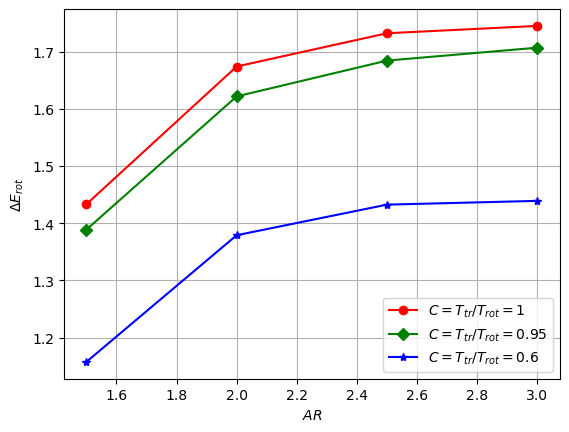

In [177]:

alpha = [1.5, 2.0, 2.5, 3.0] #, 4.0, 5.0
kT = [1.433, 1.674, 1.7322, 1.745] #, 1.7811, 1.794
kT15 = [1.3886, 1.6217, 1.68435, 1.70694] #, 1.7811, 1.794
kT2 = [1.1573, 1.3789, 1.4324, 1.439] #, 1.7811, 1.794

plt.figure()
plt.plot(alpha, kT, 'r-', marker='o', label = r'$C = T_{tr}/T_{rot} = 1$')
plt.plot(alpha, kT15, 'g-', marker='D', label = r'$C = T_{tr}/T_{rot} = 0.95$')
plt.plot(alpha, kT2, 'b-', marker='*', label = r'$C = T_{tr}/T_{rot} = 0.6$')

plt.xlabel(r'$AR$')
plt.ylabel(r'$\Delta E_{rot}$')
plt.grid(True)  # Add grid lines for better readability
plt.savefig('/home/muhammed/Documents/Thesis/New Simulations/Py_scripts2/Results/dist2.png', format='png', dpi=400)
plt.legend()
plt.show()

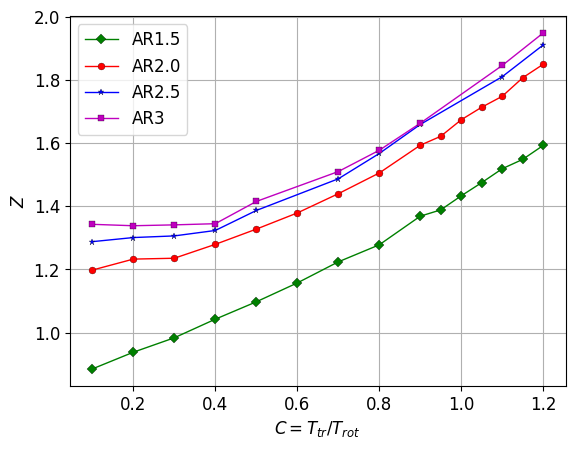

In [ ]:
alpha = [1.5, 2.0, 2.5, 3.0] #, 4.0, 5.0
kT = [1.433, 1.674, 1.7322, 1.745] #, 1.7811, 1.794
kT15 = [1.3886, 1.6217, 1.68435, 1.70694] #, 1.7811, 1.794
kT2 = [1.1573, 1.3789, 1.4324, 1.439] #, 1.7811, 1.794

C1 = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 1.0, 1.05, 1.1, 1.15, 1.20]
C2 = [1, 0.95, 0.6]
Z_AR15 = [0.885, 0.9379, 0.9836, 1.0425, 1.0975, 1.1573, 1.224, 1.278, 1.3687, 1.3886, 1.4332, 1.475, 1.519, 1.5486, 1.5928]
Z_AR2 = [1.19798, 1.23276, 1.2355, 1.27945, 1.327697, 1.3789, 1.43978, 1.5055, 1.59329, 1.6217, 1.674, 1.71377, 1.74836, 1.8071, 1.849768]
Z_AR25 = [1.288, 1.301, 1.3062, 1.3234, 1.3867, 1.487, 1.5672, 1.6591, 1.8104, 1.911]
C3 = [0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2]
Z_AR3 = [1.3429, 1.3384, 1.34118, 1.34488, 1.41528, 1.50995, 1.5774, 1.66304, 1.75116, 1.8276, 1.949]
t = np.linspace(0, 1, 10)
#f = Zr_C(1.674, t)
plt.figure()
plt.plot(C1, Z_AR15, 'g-', marker='D', label= 'AR1.5')
plt.plot(C1, Z_AR2, 'r-', marker='o', label= 'AR2.0')
plt.plot(C3, Z_AR25, 'b-', marker='*', label= 'AR2.5')
plt.plot(C3, Z_AR3, 'm-', marker='s', label= 'AR3')
#plt.plot(t, f, 'b-', marker='^', label= 'model')
#plt.plot(alpha, kT2, 'b-', marker='*')

plt.xlabel(r'$C = T_{tr}/T_{rot}$')
plt.ylabel(r'$Z$')
plt.grid(True)  # Add grid lines for better readability
plt.savefig('/home/muhammed/Documents/Thesis/New Simulations/Py_scripts2/Results/dist2.png', format='png', dpi=400)
plt.legend()
plt.show()

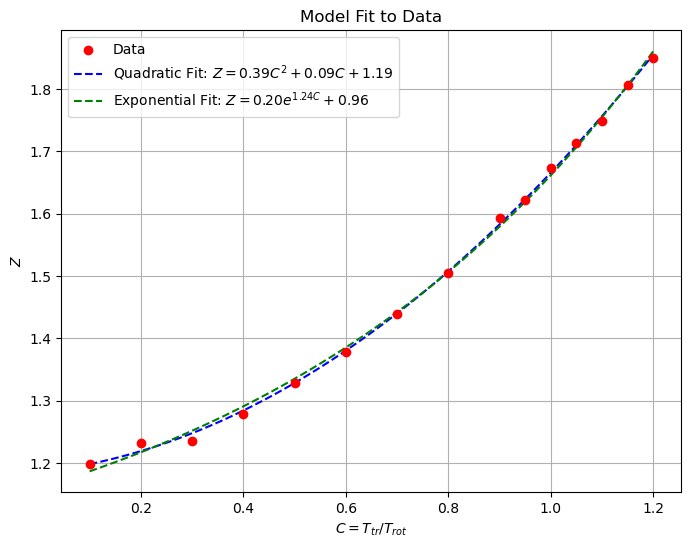

Quadratic Model Parameters:
a = 0.3884, b = 0.0924, c = 1.1852

Exponential Model Parameters:
a = 0.2040, b = 1.2414, c = 0.9557


In [216]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Example data (replace these with your actual data points)
C = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 1.0, 1.05, 1.1, 1.15, 1.20])  # X-axis (C = T_tr/T_rot)
Z = np.array([1.19798, 1.23276, 1.2355, 1.27945, 1.327697, 1.3789, 1.43978, 1.5055, 1.59329, 1.6217, 1.674, 1.71377, 1.74836, 1.8071, 1.849768])  # Y-axis (Z)
Z_AR15 = [0.885, 0.9379, 0.9836, 1.0425, 1.0975, 1.1573, 1.224, 1.278, 1.3687, 1.3886, 1.4332, 1.475, 1.519, 1.5486, 1.5928]

# Define quadratic model
def quadratic_model(C, a, b, c):
    return a * C**2 + b * C + c

# Define exponential model
def exponential_model(C, a, b, c):
    return a * np.exp(b * C) + c

# Fit the quadratic model
quad_params, quad_cov = curve_fit(quadratic_model, C, Z)

# Fit the exponential model
exp_params, exp_cov = curve_fit(exponential_model, C, Z, p0=[1, 1, 1])

# Generate fitted values
C_fit = np.linspace(min(C), max(C), 100)
Z_quad_fit = quadratic_model(C_fit, *quad_params)
Z_exp_fit = exponential_model(C_fit, *exp_params)

# Plot the data and fits
plt.figure(figsize=(8, 6))
plt.scatter(C, Z, color='red', label='Data', zorder=3)
plt.plot(C_fit, Z_quad_fit, label=f'Quadratic Fit: $Z = {quad_params[0]:.2f}C^2 + {quad_params[1]:.2f}C + {quad_params[2]:.2f}$', linestyle='--', color='blue')
plt.plot(C_fit, Z_exp_fit, label=f'Exponential Fit: $Z = {exp_params[0]:.2f}e^{{{exp_params[1]:.2f}C}} + {exp_params[2]:.2f}$', linestyle='--', color='green')
plt.xlabel(r"$C = T_{tr}/T_{rot}$")
plt.ylabel(r"$Z$")
plt.title("Model Fit to Data")
plt.legend()
plt.grid()
plt.show()

# Print the parameters
print("Quadratic Model Parameters:")
print(f"a = {quad_params[0]:.4f}, b = {quad_params[1]:.4f}, c = {quad_params[2]:.4f}")
print("\nExponential Model Parameters:")
print(f"a = {exp_params[0]:.4f}, b = {exp_params[1]:.4f}, c = {exp_params[2]:.4f}")


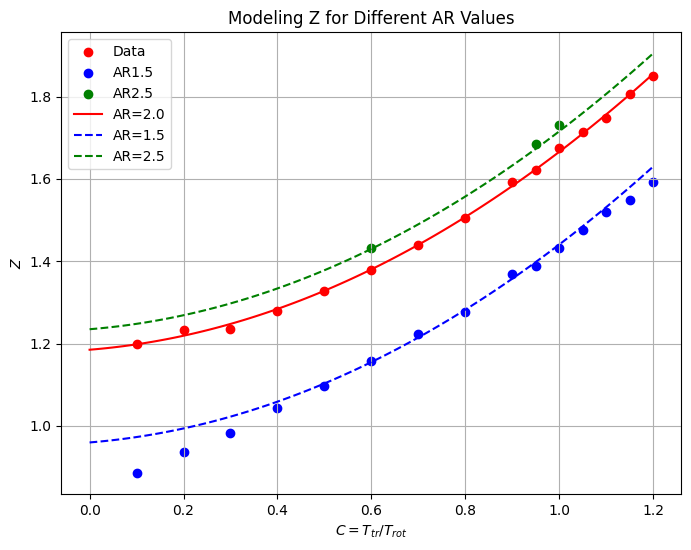

In [460]:
import numpy as np
import matplotlib.pyplot as plt

# Coefficients for AR=2.0 (from the fit)
a, b, c_AR2 = 0.3884, 0.0924, 1.1852  # Replace with fitted values

# Shifting constants for other ARs (initial guesses)
c_AR15 = 0.96  # Shift down for AR=1.5
c_AR25 = 1.235  # Shift up for AR=2.5

# Example data (replace these with your actual data points)
C1 = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 1.0, 1.05, 1.1, 1.15, 1.20])  # X-axis (C = T_tr/T_rot)
Z = np.array([1.19798, 1.23276, 1.2355, 1.27945, 1.327697, 1.3789, 1.43978, 1.5055, 1.59329, 1.6217, 1.674, 1.71377, 1.74836, 1.8071, 1.849768])  # Y-axis (Z)



C2 = [1, 0.95, 0.6]
Z_AR152 = [0.885, 0.9379, 0.9836, 1.0425, 1.0975, 1.1573, 1.224, 1.278, 1.3687, 1.3886, 1.4332, 1.475, 1.519, 1.5486, 1.5928]
Z_AR252 = [1.7322, 1.68435, 1.4324]

# Quadratic model function
def quadratic_model(C, a, b, c):
    return a * C**2 + b * C + c

# Generate data for C
C = np.linspace(0, 1.2, 100)

# Compute Z for different ARs
Z_AR2 = quadratic_model(C, a, b, c_AR2)
Z_AR15 = quadratic_model(C, a, b, c_AR15)
Z_AR25 = quadratic_model(C, a, b, c_AR25)

# Plot the curves
plt.figure(figsize=(8, 6))
plt.scatter(C1, Z, color='red', label='Data', zorder=3)
plt.scatter(C1, Z_AR152, color='b', label= 'AR1.5')
plt.scatter(C2, Z_AR252, color='g', label= 'AR2.5')
plt.plot(C, Z_AR2, label="AR=2.0", color="red")
plt.plot(C, Z_AR15, label="AR=1.5", color="blue", linestyle="--")
plt.plot(C, Z_AR25, label="AR=2.5", color="green", linestyle="--")
plt.xlabel(r"$C = T_{tr}/T_{rot}$")
plt.ylabel(r"$Z$")
plt.title("Modeling Z for Different AR Values")
plt.legend()
plt.grid()
plt.show()


In [461]:
Z_AR25 = quadratic_model(C1, a, b, c_AR25)
Z_AR25

array([1.248124, 1.269016, 1.297676, 1.334104, 1.3783  , 1.430264,
       1.489996, 1.557496, 1.632764, 1.673311, 1.7158  , 1.760231,
       1.806604, 1.854919, 1.905176])

In [373]:
def Zr(theta):
    return 0.39*theta**2 + 0.09*theta + 1.19

In [983]:
def prepare_theta(temp_ratio):
    if temp_ratio <= 0.0 or temp_ratio >= 1.3:
        raise ValueError(f"Error: temp_ratio must be in (0, 1.3). Received temp_ratio = {temp_ratio}")

    # Round to nearest 0.1
    r = round(temp_ratio * 10) / 10.0

    # Clamp within [0.1, 1.2]
    if r < 0.1:
        r = 0.1
    elif r > 1.2:
        r = 1.2

    return r


In [984]:
prob_one_hit = float(model_one_hit.predict(poly.transform([[0.95, 2]]))[0])
prob_one_hit

0.8064083027213593

In [988]:
import numpy as np
import random
import math
import time

# particle properties
AR = 2.0
radius = 0.5
diameter = 2*0.5
mass = 1.0
omass = 1/mass
lcycl = (AR-1) * diameter
volpart = (np.pi)*(diameter**3)/6 + (np.pi)*lcycl*(radius**2)
rho = mass/volpart
mI = (np.pi/48)*rho*(diameter**2) * lcycl**3 + 3.0*np.pi/64.0*rho*diameter**4*lcycl + np.pi/60*rho*diameter**5 + np.pi/24.0*rho*diameter**3*lcycl**2; # same as Iy
omI = 1/mI
sigma_c = (0.32 * AR**2 + 0.694 * AR - 0.0213)*(np.pi)


# system properties
kTt = 1.0
kTr = 1.0
alpha = 0.95
lx, ly, lz = 200, 200, 200
volsys = lx * ly * lz
ovol = 1/volsys
phi = 0.01
Np = math.ceil(phi*volsys/volpart)
gamma_max = np.polyval(coeffs1, alpha)
prob_one_hit = float(model_one_hit.predict(poly.transform([[alpha, AR]]))[0])
a_fit = 1.211
b_fit = 3.672

# time 
dt = 1e-2
halfdt = dt * 0.5
dtau = 0.1
t_end = 200
Ntau = 0.0
tol = 1e-6

# probability distribution of chi given alpha
p_chi_fn, p_max = init_p_chi_distribution(AR=AR, alpha=alpha)

def run_simulation(seed, realization_index):
    np.random.seed(seed)
    random.seed(seed)
    
    
    # Re-initialize arrays for each realization
    vel = np.zeros((Np, 3))
    omega = np.zeros((Np, 3))
    Er = np.zeros(Np)
    vbulk = np.zeros(3)

    # Initialize velocities
    sqkTt = np.sqrt(kTt *omass)
    sqkTr = np.sqrt(kTr*omI)
    vrmax = 10*np.sqrt(2.0)*sqkTt

    for i in range(Np):
        contains_nan = True
    
        while contains_nan:
            rand_values_t = np.random.randn(3)
            rand_values_r = np.random.randn(3)
            vel[i, :] = rand_values_t * sqkTt
            omega[i, :] = rand_values_r * sqkTr
            omega[i, 0] = 0.0
            Er[i] = 0.5 * mI * ((omega[i, 1])** 2 + (omega[i, 2])** 2)
            if not (np.isnan(vel[i]).any() or np.isnan(omega[i]).any()):
                contains_nan = False
            else:
                print(f"NaN values found in row {i} of vel or omega array. Re-generating...")

    vbulk = np.sum(vel, axis=0) / Np
    for i in range(Np):
        vel[i, :] -= vbulk
    
    NColl = 0
    t = 0.0
    Ntau = 0
    vrmax_temp = 0.0
    
    filename = f"/home/muhammed/Documents/Thesis/New Simulations/DSMC_HCS/AR2/COR95/AR2{realization_index}COR95.txt"
    with open(filename, 'w') as file:
        while t < t_end:
            if (NColl / Np >= Ntau * dtau):
                Eksum = 2.0 * 0.5 * mass * np.sum(np.sum(vel**2, axis=1)) / (3.0 * Np)
                Ersum = np.sum(Er) / float(Np)
            
                # Write the formatted string to the file
                file.write(f"{t:13.6f} {NColl/float(Np):13.6f} {Eksum:13.6f} {Ersum:13.6f} {(3.0*Eksum + 2.0*Ersum)/5.0:13.6f}\n")
                Ntau += 1
            
            Ttrans = 2.0 * 0.5 * mass * np.sum(np.sum(vel**2, axis=1)) / (3.0 * Np)
            Trot = np.sum(Er) / float(Np)
            temp_ratio = Ttrans/Trot
            
            #print(f"Temperature ratio: {temp_ratio}")
            #theta2 = prepare_theta(temp_ratio)
            #print(f"Temperature ratio dist: {theta2}")
            
            totalSel = float(Np)*float(Np-1)*sigma_c*vrmax*ovol*halfdt
            vrmax_temp = 0.0
        
            RR = np.random.rand()
            totalSel = np.floor(totalSel+RR)

            while totalSel > 0:
                totalSel -= 1

                # Select pairs randomly
                p1 = np.random.randint(0, Np)
                p2 = p1
                while p2 == p1:
                    p2 = np.random.randint(0, Np)

                # Calculate vr, velocities, and energies
                v1 = vel[p1, :]
                v2 = vel[p2, :]
                vr = np.linalg.norm(v2 - v1)

                # update maximum relative velocity
                if vr >= vrmax_temp:
                    vrmax_temp = vr

                # Test for collision
                RR = np.random.random()
                if vr < vrmax * RR:
                    continue  # Skip the rest of the loop
            
                # Count collisions
                NColl += 2
            
                vcom = (v1 + v2) * 0.5
                v1com = v1 - vcom
                v2com = v2 - vcom

                Etrans_i = 0.5 * mass * (np.dot(v1com, v1com) + np.dot(v2com, v2com))
                Erot_i = Er[p1] + Er[p2]
                Etotal_i = Etrans_i + Erot_i

                epsilon_tr_i = Etrans_i/Etotal_i
                epsilon_rot_1_i = Er[p1]/ Erot_i

                # Sample the post-collision angle
                chi = sample_chi(p_chi_fn, p_max)
                chi = np.pi * chi
                
                theta = temp_ratio
                Zr = (0.39*theta**2 + 0.09*theta + 1.67)*2
                #Zr = 5/3
                P_r = 1/Zr
            
                # Test for inelastic collision
                if RR < P_r:
                    theta2 = prepare_theta(temp_ratio)
                    sample = sample_conditionals(gmm_model, scaler, r=theta2, e_tr=epsilon_tr_i, e_r1=epsilon_rot_1_i, n_samples=1)
                    #sample = sample_feq_eps(theta2, num_samples=1)                    
                    epsilon_tr_f = sample[0, 0]
                    epsilon_rot_1_f = sample[0, 1]
                    epsilon_rot_2_f = 1 - epsilon_rot_1_f                      
                else:
                    # Elastic branch
                    epsilon_tr_f = epsilon_tr_i
                    RR = np.random.random()
                    epsilon_rot_1_f = RR
                    epsilon_rot_2_f = 1 - epsilon_rot_1_f
                
                #P_dissp = prob_one_hit
                #if RR < P_dissp:
                gamma = sample_dissp(a_fit, b_fit)
                gamma = gamma*gamma_max*prob_one_hit
                #else:
                #    gamma = 0.0

                Etotal_f = Etotal_i * (1 - gamma)

                Etrans_f = float(Etotal_f * epsilon_tr_f)
                Erot_f = float(Etotal_f - Etrans_f)
            
                # Now assign final energies:
                Er[p1] = epsilon_rot_1_f * Erot_f
                Er[p2] = epsilon_rot_2_f * Erot_f

                cr_new = np.sqrt(Etrans_f * omass)
                # Make sure cr_new is safe:
                cr_new = max(cr_new, 1e-14)

                RR = np.random.random()
                eps = 2*np.pi*RR
                vel[p1, :], vel[p2, :] = update_velocities(vel[p1, :], vel[p2, :], chi, eps, cr_new)

            # end selections loop
            if vrmax < vrmax_temp:
                vrmax = vrmax_temp

            # Update time count
            t += dt

In [388]:
np.polyval(coeffs1, 0.95)

0.09197746416454122

In [986]:
seeds = [42, 123, 999, 2024, 777]  # You can choose any set of 5 seeds
for i, seed in enumerate(seeds, start=1):
    print(f"Running realization {i} with seed {seed}")
    run_simulation(seed, i)

Running realization 1 with seed 42


KeyboardInterrupt: 

In [59]:
# Custom colour palette (red → blue gradient)
ncol = 5
red  = np.array([254,   0,   2], dtype=int)
blue = np.array([  3,   2, 252], dtype=int)

c1 = np.linspace(red[0],  blue[0],  ncol, dtype=int)
c2 = np.linspace(red[1],  blue[1],  ncol, dtype=int)
c3 = np.linspace(red[2],  blue[2],  ncol, dtype=int)

colors = [rgb2hex(r, g, b) for r, g, b in zip(c1, c2, c3)][::-1]

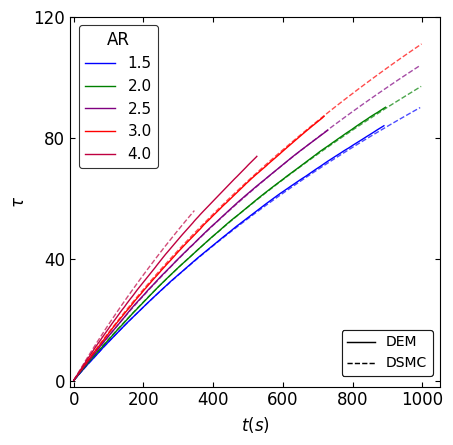

In [60]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as optimize
from scipy.stats import norm

def load_and_process_data(file_path):
    T2_Dem = np.loadtxt(file_path)
    delta_E_tr = np.diff(T2_Dem[1:, 4])
    return T2_Dem[1:, 0], T2_Dem[1:, 1], delta_E_tr / delta_E_tr[0], T2_Dem[1:,4], T2_Dem[1,4]

# Define labels and file paths
labels = ['1.5', '2.0', '2.5', '3.0', '4.0']
methods = ['DEM', 'DSMC']
file_list1 = [
    '/home/muhammed/Documents/Thesis/New Simulations/HCS_DEM/kT_1_kTr_1/Alpha_095/AR15/T.txt',
    '/home/muhammed/Documents/Thesis/New Simulations/HCS_DEM/kT_1_kTr_1/Alpha_095/AR20/T.txt',
    '/home/muhammed/Documents/Thesis/New Simulations/HCS_DEM/kT_1_kTr_1/Alpha_095/AR25/T.txt',
    '/home/muhammed/Documents/Thesis/New Simulations/HCS_DEM/kT_1_kTr_1/Alpha_095/AR30/T.txt',
    '/home/muhammed/Documents/Thesis/New Simulations/HCS_DEM/kT_1_kTr_1/Alpha_095/AR40/T.txt'
]
file_list2 = [
    '/home/muhammed/Documents/Thesis/New Simulations/figs/Journal_results/HCS/HCS_averages/AR15/R1COR95.txt',
    '/home/muhammed/Documents/Thesis/New Simulations/figs/Journal_results/HCS/HCS_averages/AR20/R1COR95.txt',
    '/home/muhammed/Documents/Thesis/New Simulations/figs/Journal_results/HCS/HCS_averages/AR25/R1COR95.txt',
    '/home/muhammed/Documents/Thesis/New Simulations/figs/Journal_results/HCS/HCS_averages/AR30/R1COR95.txt',
    '/home/muhammed/Documents/Thesis/New Simulations/Py_scripts2/Results/T40_95.txt'
]

#plt.figure(figsize=(10, 6))  # Adjust figure size for better layout
dem_handles = []
colors = ['blue', 'green', 'purple', 'red', '#BF0040']
fig,ax = plt.subplots();
from matplotlib.ticker import FuncFormatter

# Custom formatter: return '0' for 0, otherwise default formatting
formatter1 = FuncFormatter(lambda x, _: '0' if x == 0 else f'{x:.0f}')
formatter2 = FuncFormatter(lambda x, _: '0' if x == 0 else f'{x:.0f}')
ax.yaxis.set_major_formatter(formatter1)
ax.xaxis.set_major_formatter(formatter2)

# Plot DEM results with solid lines
for i, file_path in enumerate(file_list1):
    t, tau, delta_E_ratio, Temp, init_temp = load_and_process_data(file_path)
    line, = ax.plot(t, tau, label=labels[i], color=colors[i], linestyle='-')
    dem_handles.append(line)

# Plot DSMC results with dashed lines and larger, distinct markers, and using every 10th row
for i, file_path in enumerate(file_list2):
    t, tau, delta_E_ratio, Temp, init_temp = load_and_process_data(file_path)
    ax.plot(t[::10], tau[::10], color=colors[i], linestyle='--', markersize=4, alpha=0.7)  # Every 10th row

ax.set_xlim([-10, 1050])
ax.set_ylim([-2, 120])
ax.set_ylabel(r'$\tau$')
ax.set_xlabel(r'$t(s)$')
xval, yval = ax.get_xlim(), ax.get_ylim()
xrange = xval[1]-xval[0];
yrange = yval[1]-yval[0];
aspect = 1
ax.set_aspect(aspect*(xrange/yrange), adjustable='box')
ax.set_xticks([0, 200, 400, 600, 800, 1000])
ax.set_yticks([0, 40, 80, 120])
ax.tick_params(axis='both',direction='in',which='both',right=True,top=True)

from matplotlib.lines import Line2D

legend1 = ax.legend(
    loc='upper center',
    bbox_to_anchor=(0.13, 1.0),
    fontsize=11,
    frameon=True,
    title=r'AR'
)
legend1.get_frame().set_edgecolor('black')
legend1.get_frame().set_linewidth(0.8)
ax.add_artist(legend1)


legend2_handles = [
    Line2D([0], [0], color='black', linestyle='-', label=r'DEM'),
    Line2D([0], [0], color='black', linestyle='--', label=r'DSMC')
]

legend2 = ax.legend(handles=legend2_handles,
                    loc='lower right', bbox_to_anchor=(1.0, 0.01),
                    fontsize=10, title_fontsize=11, frameon=True)
legend2.get_frame().set_edgecolor('black')
legend2.get_frame().set_linewidth(0.8)
ax.add_artist(legend2)

mng = plt.get_current_fig_manager()
mng.full_screen_toggle()
plt.savefig('CollFreq.pdf',bbox_inches='tight')
plt.show()

In [135]:
import numpy as np
import matplotlib.pyplot as plt
import yt
import math
from matplotlib import ticker
from colormap import rgb2hex                         # keep if you prefer it
# NEW ────────────────────────────────────────────────────────────────────────
# axes_grid → axes_grid1   (same functionality, maintained sub-package)
from mpl_toolkits.axes_grid1.inset_locator import (
    inset_axes, InsetPosition, mark_inset
)
# ────────────────────────────────────────────────────────────────────────────

# --------------------------------------------------------------------------
# Matplotlib global style
# --------------------------------------------------------------------------
plt.rc("text", usetex=False)
plt.rc("font", size=12)
plt.rc("axes", titlesize=60)
plt.rcParams.update({
    "legend.fontsize": 12,
    "lines.markersize": 5,
    "lines.markeredgecolor": "k",
    "lines.markeredgewidth": 0.2,
    "lines.linewidth": 1.0,
})

formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-1, 1))

# --------------------------------------------------------------------------
# Plot parameters
# --------------------------------------------------------------------------
aspect = 1.0

# Custom colour palette (red → blue gradient)
ncol = 5
red  = np.array([254,   0,   2], dtype=int)
blue = np.array([  3,   2, 252], dtype=int)

c1 = np.linspace(red[0],  blue[0],  ncol, dtype=int)
c2 = np.linspace(red[1],  blue[1],  ncol, dtype=int)
c3 = np.linspace(red[2],  blue[2],  ncol, dtype=int)

colors = [rgb2hex(r, g, b) for r, g, b in zip(c1, c2, c3)][::-1]

markers = ["o", "^", "v", "s", "D", "X", "*"]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


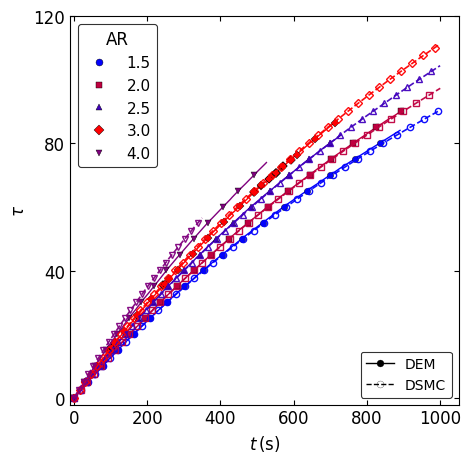

In [139]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
from matplotlib.ticker import FuncFormatter

# ----- Colorblind-safe palette (Okabe–Ito) -----
cb_colors = ['#0072B2', '#009E73', '#D55E00', '#CC79A7', '#E69F00']  # 5 distinct
markers_ar = ['o', 's', '^', 'D', 'v']  # one marker per AR label

cb_colors = [colors[0], colors[3], colors[1], colors[4], colors[2]]
markers_ar_ar = [markers[0], markers[2], markers[1], markers[3], markers[6]]

labels = ['1.5', '2.0', '2.5', '3.0', '4.0']

fig, ax = plt.subplots()

# formatters (keep your “0” behavior)
fmt0 = FuncFormatter(lambda x, _: '0' if x == 0 else f'{x:.0f}')
ax.xaxis.set_major_formatter(fmt0); ax.yaxis.set_major_formatter(fmt0)

dem_handles = []

# -------- DEM: solid line + FILLED markers ----------
for i, file_path in enumerate(file_list1):
    t, tau, dE_ratio, Temp, init_temp = load_and_process_data(file_path)
    h, = ax.plot(
        t, tau,
        color=cb_colors[i], linestyle='-',
        marker=markers_ar[i], markevery=50,  # space markers
        markersize=4.5, markerfacecolor=cb_colors[i], markeredgecolor='k', markeredgewidth=0.3,
        label=labels[i]
    )
    dem_handles.append(h)

# -------- DSMC: dashed line + HOLLOW markers ----------
for i, file_path in enumerate(file_list2):
    t, tau, dE_ratio, Temp, init_temp = load_and_process_data(file_path)
    ax.plot(
        t, tau,
        color=cb_colors[i], linestyle='--', linewidth=1.2,
        marker=markers_ar[i], markevery=25,
        markersize=4.5, markerfacecolor='none', markeredgecolor=cb_colors[i], markeredgewidth=1.0,
        alpha=0.95
    )

# ---- axes / aspect / ticks ----
ax.set_xlim([-10, 1050]); ax.set_ylim([-2, 120])
ax.set_xlabel(r'$t\,(\mathrm{s})$'); ax.set_ylabel(r'$\tau$')
ax.set_xticks([0, 200, 400, 600, 800, 1000]); ax.set_yticks([0, 40, 80, 120])

xval, yval = ax.get_xlim(), ax.get_ylim()
xrange, yrange = (xval[1]-xval[0]), (yval[1]-yval[0])
ax.set_aspect((xrange/yrange), adjustable='box')  # aspect = 1 already baked into limits

ax.tick_params(axis='both', direction='in', which='both', right=True, top=True)
#ax.grid(True, which='both', linestyle='--', alpha=0.35)

# ---- legends: AR (color+marker), and Method key ----
leg_ar = ax.legend(
    handles=[Line2D([0],[0], color=cb_colors[i], marker=markers_ar[i],
                    linestyle='None', markersize=5, markerfacecolor=cb_colors[i],
                    markeredgecolor='k', markeredgewidth=0.3, label=labels[i])
             for i in range(len(labels))],
    title=r'AR', fontsize=11, title_fontsize=12,
    loc='upper left', frameon=True
)
leg_ar.get_frame().set_edgecolor('black'); leg_ar.get_frame().set_linewidth(0.8)
ax.add_artist(leg_ar)

leg_method = ax.legend(
    handles=[
        Line2D([0],[0], color='k', linestyle='-', marker='o', markersize=5,
               markerfacecolor='k', markeredgecolor='k', label='DEM'),
        Line2D([0],[0], color='k', linestyle='--', marker='o', markersize=5,
               markerfacecolor='none', markeredgecolor='k', label='DSMC')
    ],
    loc='lower right', fontsize=10, frameon=True
)
leg_method.get_frame().set_edgecolor('black'); leg_method.get_frame().set_linewidth(0.8)

plt.tight_layout()
plt.savefig('CollFreq.eps', bbox_inches='tight')
plt.show()

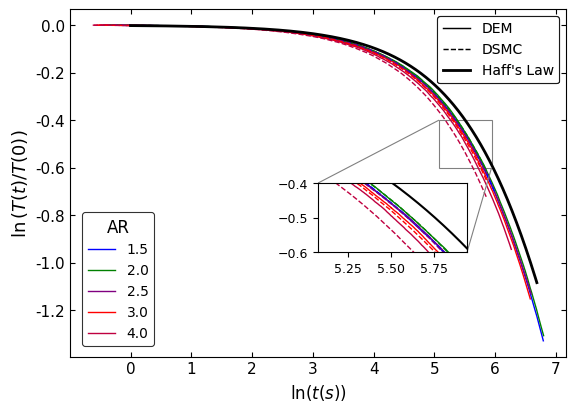

In [191]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter

# Define labels and file paths
labels = ['1.5', '2.0', '2.5', '3.0', '4.0']
methods = ['DEM', 'DSMC']
file_list1 = [
    '/home/muhammed/Documents/Thesis/New Simulations/HCS_DEM/kT_1_kTr_1/Alpha_095/AR15/T.txt',
    '/home/muhammed/Documents/Thesis/New Simulations/HCS_DEM/kT_1_kTr_1/Alpha_095/AR20/T.txt',
    '/home/muhammed/Documents/Thesis/New Simulations/HCS_DEM/kT_1_kTr_1/Alpha_095/AR25/T.txt',
    '/home/muhammed/Documents/Thesis/New Simulations/HCS_DEM/kT_1_kTr_1/Alpha_095/AR30/T.txt',
    '/home/muhammed/Documents/Thesis/New Simulations/HCS_DEM/kT_1_kTr_1/Alpha_095/AR40/T.txt',
]
file_list2 = [
    '/home/muhammed/Documents/Thesis/New Simulations/Py_scripts2/Results/T15_95dem.txt',
    '/home/muhammed/Documents/Thesis/New Simulations/Py_scripts2/Results/T20_95dsmc.txt',
    '/home/muhammed/Documents/Thesis/New Simulations/Py_scripts2/Results/T25_95dsmc.txt',
    '/home/muhammed/Documents/Thesis/New Simulations/Py_scripts2/Results/T30_95.txt',
    '/home/muhammed/Documents/Thesis/New Simulations/Py_scripts2/Results/T40_95.txt'
]


dem_handles = []
colors = ['blue', 'green', 'purple', 'red', '#BF0040']
fig,ax = plt.subplots();
from matplotlib.ticker import ScalarFormatter
formatter = ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-1, 1))
ax.yaxis.set_major_formatter(formatter)

ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.1f}'))

# Plot DEM results with solid lines
for i, file_path in enumerate(file_list1):
    t, tau, delta_E_ratio, Temp, init_temp = load_and_process_data(file_path)
    scale = np.log(Temp / init_temp)
    line, = ax.plot(np.log(t), scale, label=labels[i], color=colors[i], linestyle='-')
    dem_handles.append(line)

# Plot DSMC results with dashed lines and larger, distinct markers, and using every 10th row
for i, file_path in enumerate(file_list2):
    t, tau, delta_E_ratio, Temp, init_temp = load_and_process_data(file_path)
    scale = np.log(Temp / init_temp)
    ax.plot(np.log(t), scale, color=colors[i], linestyle='--')

zeta0 = 0.0018  # adjust to match AR=1.5 if you have empirical/kinetic theory value
t_haff = np.linspace(1, 800, 1000)
T_haff = np.log(1/ (1 + 0.5 * zeta0 * t_haff)**2)
ax.plot(np.log(t_haff), T_haff, color='black', linewidth=2.0, linestyle='-')


#ax.plot(np.log(x), haff(x,0.95), color='black', linestyle='-')
#ax.annotate('Haff Law*', xy=(20, np.exp(-0.2)), xytext=(30, np.exp(-0.05)),
#            arrowprops=dict(facecolor='black', shrink=0.05),
#            fontsize=11, ha='center')

ax.tick_params(axis='both', labelsize=11)


#ax.set_xlim([-1.0, 1000])
#ax.set_ylim([-1.6, 0.2])
ax.set_ylabel(r'$\ln\left(T(t)/T(0)\right)$', fontsize=13)
ax.set_xlabel(r'$\ln(t(s))$')
xval, yval = ax.get_xlim(), ax.get_ylim()
xrange = xval[1]-xval[0];
yrange = yval[1]-yval[0];
aspect = 0.7
ax.set_aspect(aspect*(xrange/yrange), adjustable='box')
#ax.set_xticks([0, 20, 40, 60, 80, 100, 120])
#ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.tick_params(axis='both',direction='in',which='both',right=True,top=True)

# Manually set y-ticks in decimal format


from matplotlib.lines import Line2D

legend1 = ax.legend(
    loc='lower left', 
    bbox_to_anchor=(0.01, 0.01),
    fontsize=10,
    frameon=True,
    title=r'AR'
)
legend1.get_frame().set_edgecolor('black')
legend1.get_frame().set_linewidth(0.8)
ax.add_artist(legend1)


legend2_handles = [
    Line2D([0], [0], color='black', linestyle='-', label=r'DEM'),
    Line2D([0], [0], color='black', linestyle='--', label=r'DSMC'),
    Line2D([0], [0], color='black',  linewidth=2.0, linestyle='-', label=r"Haff's Law")
]

legend2 = ax.legend(handles=legend2_handles,
                    loc='upper right',bbox_to_anchor=(1.0, 1.0),
                    fontsize=10, title_fontsize=10, frameon=True)
legend2.get_frame().set_edgecolor('black')
legend2.get_frame().set_linewidth(0.8)
ax.add_artist(legend2)

from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

# Create inset axes directly without bbox_to_anchor
axins = ax.inset_axes([0.5, 0.3, 0.3, 0.2])

# Plot same data in inset
for i, file_path in enumerate(file_list1):
    t, tau, delta_E_ratio, Temp, init_temp = load_and_process_data(file_path)
    scale = np.log(Temp / init_temp)
    axins.plot(np.log(t), scale, color=colors[i], linestyle='-')

for i, file_path in enumerate(file_list2):
    t, tau, delta_E_ratio, Temp, init_temp = load_and_process_data(file_path)
    scale = np.log(Temp / init_temp)
    axins.plot(np.log(t), scale, color=colors[i], linestyle='--')

axins.plot(np.log(t_haff), T_haff, color='black', linewidth=1.5, linestyle='-')

# Set zoom region in log(t) and log(T/T0)
axins.set_xlim(np.log(160), np.log(380))
axins.set_ylim(-0.6, -0.4)
axins.tick_params(labelsize=9)

# Draw connection lines
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="gray", lw=0.8, linestyle='-')

#mng = plt.get_current_fig_manager()
#mng.full_screen_toggle()

plt.draw()  # Ensures layout and locators are resolved

plt.savefig("CoolingRate.png", bbox_inches="tight")
plt.show()

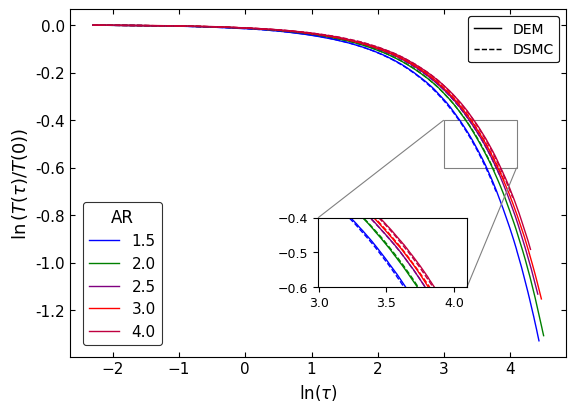

In [193]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter

# Define labels and file paths
labels = ['1.5', '2.0', '2.5', '3.0', '4.0']
methods = ['DEM', 'DSMC']
file_list1 = [
    '/home/muhammed/Documents/Thesis/New Simulations/HCS_DEM/kT_1_kTr_1/Alpha_095/AR15/T.txt',
    '/home/muhammed/Documents/Thesis/New Simulations/HCS_DEM/kT_1_kTr_1/Alpha_095/AR20/T.txt',
    '/home/muhammed/Documents/Thesis/New Simulations/HCS_DEM/kT_1_kTr_1/Alpha_095/AR25/T.txt',
    '/home/muhammed/Documents/Thesis/New Simulations/HCS_DEM/kT_1_kTr_1/Alpha_095/AR30/T.txt',
    '/home/muhammed/Documents/Thesis/New Simulations/HCS_DEM/kT_1_kTr_1/Alpha_095/AR40/T.txt',
]
file_list2 = [
    '/home/muhammed/Documents/Thesis/New Simulations/Py_scripts2/Results/T15_95dem.txt',
    '/home/muhammed/Documents/Thesis/New Simulations/Py_scripts2/Results/T20_95dsmc.txt',
    '/home/muhammed/Documents/Thesis/New Simulations/Py_scripts2/Results/T25_95dsmc.txt',
    '/home/muhammed/Documents/Thesis/New Simulations/Py_scripts2/Results/T30_95.txt',
    '/home/muhammed/Documents/Thesis/New Simulations/Py_scripts2/Results/T40_95.txt'
]


dem_handles = []
colors = ['blue', 'green', 'purple', 'red', '#BF0040']
fig,ax = plt.subplots();
from matplotlib.ticker import ScalarFormatter
formatter = ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-1, 1))
ax.yaxis.set_major_formatter(formatter)

ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.1f}'))

# Plot DEM results with solid lines
for i, file_path in enumerate(file_list1):
    t, tau, delta_E_ratio, Temp, init_temp = load_and_process_data(file_path)
    scale = np.log(Temp / init_temp)
    line, = ax.plot(np.log(tau), scale, label=labels[i], color=colors[i], linestyle='-')
    dem_handles.append(line)

# Plot DSMC results with dashed lines and larger, distinct markers, and using every 10th row
for i, file_path in enumerate(file_list2):
    t, tau, delta_E_ratio, Temp, init_temp = load_and_process_data(file_path)
    scale = np.log(Temp / init_temp)
    ax.plot(np.log(tau), scale, color=colors[i], linestyle='--')

zeta0 = 0.0018  # adjust to match AR=1.5 if you have empirical/kinetic theory value
t_haff = np.linspace(0, 1000, 1000)
T_haff = np.log(1/ (1 + 0.5 * zeta0 * t_haff)**2)
#ax.plot(np.log(t_haff), T_haff, color='black', linewidth=1.5, linestyle='-', label='Haff Law')

#ax.plot(np.log(x), haff(x,0.95), color='black', linestyle='-')
ax.annotate('Haff Law*', xy=(20, np.exp(-0.2)), xytext=(30, np.exp(-0.05)),
            arrowprops=dict(facecolor='black', shrink=0.05),
            fontsize=11, ha='center')

ax.tick_params(axis='both', labelsize=11)


#ax.set_xlim([-1.0, 1000])
#ax.set_ylim([-1.6, 0.2])
ax.set_ylabel(r'$\ln\left(T(\tau)/T(0)\right)$', fontsize=13)
ax.set_xlabel(r'$\ln(\tau)$')
xval, yval = ax.get_xlim(), ax.get_ylim()
xrange = xval[1]-xval[0];
yrange = yval[1]-yval[0];
aspect = 0.7
ax.set_aspect(aspect*(xrange/yrange), adjustable='box')
#ax.set_xticks([0, 20, 40, 60, 80, 100, 120])
#ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.tick_params(axis='both',direction='in',which='both',right=True,top=True)

# Manually set y-ticks in decimal format


from matplotlib.lines import Line2D

legend1 = ax.legend(
    loc='lower left', 
    bbox_to_anchor=(0.01, 0.01),
    fontsize=11,
    frameon=True,
    title=r'AR'
)
legend1.get_frame().set_edgecolor('black')
legend1.get_frame().set_linewidth(0.8)
ax.add_artist(legend1)


legend2_handles = [
    Line2D([0], [0], color='black', linestyle='-', label=r'DEM'),
    Line2D([0], [0], color='black', linestyle='--', label=r'DSMC')
]

legend2 = ax.legend(handles=legend2_handles,
                    loc='upper right',bbox_to_anchor=(1.0, 1.0),
                    fontsize=10, title_fontsize=11, frameon=True)
legend2.get_frame().set_edgecolor('black')
legend2.get_frame().set_linewidth(0.8)
ax.add_artist(legend2)

from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

# Create inset axes directly without bbox_to_anchor
axins = ax.inset_axes([0.5, 0.2, 0.3, 0.2])

# Plot same data in inset
for i, file_path in enumerate(file_list1):
    t, tau, delta_E_ratio, Temp, init_temp = load_and_process_data(file_path)
    scale = np.log(Temp / init_temp)
    axins.plot(np.log(tau), scale, color=colors[i], linestyle='-')

for i, file_path in enumerate(file_list2):
    t, tau, delta_E_ratio, Temp, init_temp = load_and_process_data(file_path)
    scale = np.log(Temp / init_temp)
    axins.plot(np.log(tau), scale, color=colors[i], linestyle='--')

# Set zoom region in log(t) and log(T/T0)
axins.set_xlim(np.log(20), np.log(60))
axins.set_ylim(-0.6, -0.4)
axins.tick_params(labelsize=9)

# Draw connection lines
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="gray", lw=0.8, linestyle='-')

#mng = plt.get_current_fig_manager()
#mng.full_screen_toggle()

plt.draw()  # Ensures layout and locators are resolved

plt.savefig("CoolingRate2.png", bbox_inches="tight")
plt.show()

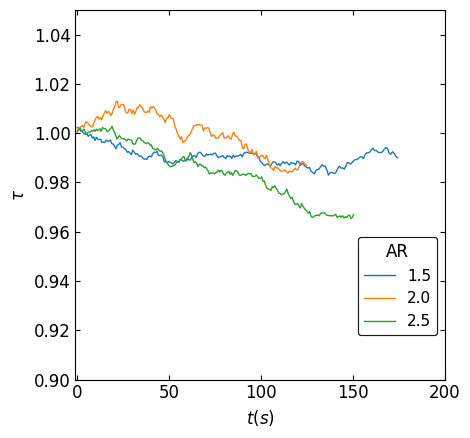

In [200]:
def load_marginals(file_path):
    T2_Dem = np.loadtxt(file_path)
    return T2_Dem[:215, 0], T2_Dem[:215,2], T2_Dem[:215,3]

i=0
labels = ['1.5', '2.0', '2.5']
file_list1 = [
    '/home/muhammed/Documents/Thesis/New Simulations/figs/Journal_results/HCS/AR15/R1COR95.txt',
    '/home/muhammed/Documents/Thesis/New Simulations/figs/Journal_results/HCS/AR15/R3COR95.txt',
    '/home/muhammed/Documents/Thesis/New Simulations/figs/Journal_results/HCS/AR15/R4COR95.txt',
]

t_15 = np.zeros(215)
frac_E_15 = np.zeros(215)
for file_path in file_list1:
    t, E_trans, E_rot = load_marginals(file_path)
    frac_E = E_trans/E_rot
    frac_E_15 += frac_E 
    t_15 += t

frac_E_15 = frac_E_15/3   
t_15 = t_15/3

def load_marginals(file_path):
    T2_Dem = np.loadtxt(file_path)
    return T2_Dem[:169, 0], T2_Dem[:169,2], T2_Dem[:169,3]

file_list2 = [
    '/home/muhammed/Documents/Thesis/New Simulations/figs/Journal_results/HCS/AR20/R2COR95.txt',
    '/home/muhammed/Documents/Thesis/New Simulations/figs/Journal_results/HCS/AR20/R4COR95.txt',
]

t_20 = np.zeros(169)
frac_E_20 = np.zeros(169)
for file_path in file_list2:
    t, E_trans, E_rot = load_marginals(file_path)
    frac_E = E_trans/E_rot
    frac_E_20 += frac_E
    t_20 += t
    
frac_E_20 = frac_E_20/2
t_20 = t_20/2

def load_marginals(file_path):
    T2_Dem = np.loadtxt(file_path)
    return T2_Dem[:216, 0], T2_Dem[:216,2], T2_Dem[:216,3]
    
file_list3 = [
    '/home/muhammed/Documents/Thesis/New Simulations/figs/Journal_results/HCS/AR25/R1COR95.txt',
    '/home/muhammed/Documents/Thesis/New Simulations/figs/Journal_results/HCS/AR25/R2COR95.txt',
    '/home/muhammed/Documents/Thesis/New Simulations/figs/Journal_results/HCS/AR25/R3COR95.txt',
    '/home/muhammed/Documents/Thesis/New Simulations/figs/Journal_results/HCS/AR25/R4COR95.txt',
]

t_25 = np.zeros(216)
frac_E_25 = np.zeros(216)
for file_path in file_list3:
    t, E_trans, E_rot = load_marginals(file_path)
    frac_E = E_trans/E_rot
    frac_E_25 += frac_E
    t_25 += t
    
frac_E_25 = frac_E_25/4
t_25 = t_25/4

fig,ax = plt.subplots();
ax.plot(t_15, frac_E_15, label=labels[0])
ax.plot(t_20, frac_E_20, label=labels[1])
ax.plot(t_25, frac_E_25, label=labels[2])

ax.set_xlim([-1, 200])
ax.set_ylim([0.9, 1.05])
ax.set_ylabel(r'$\tau$')
ax.set_xlabel(r'$t(s)$')
xval, yval = ax.get_xlim(), ax.get_ylim()
xrange = xval[1]-xval[0];
yrange = yval[1]-yval[0];
aspect = 1
ax.set_aspect(aspect*(xrange/yrange), adjustable='box')
#ax.set_xticks([0, 200, 400, 600, 800, 1000])
#ax.set_yticks([0, 40, 80, 120])
ax.tick_params(axis='both',direction='in',which='both',right=True,top=True)

legend1 = ax.legend(
    loc='lower right',
    bbox_to_anchor=(1.0, 0.1),
    fontsize=11,
    frameon=True,
    title=r'AR'
)
legend1.get_frame().set_edgecolor('black')
legend1.get_frame().set_linewidth(0.8)
ax.add_artist(legend1)

mng = plt.get_current_fig_manager()
mng.full_screen_toggle()
plt.savefig('theta.pdf',bbox_inches='tight')
plt.show()

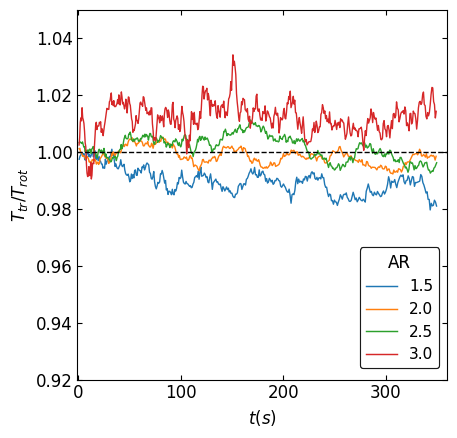

In [195]:
def load_marginals(file_path):
    T2_Dem = np.loadtxt(file_path)
    return T2_Dem[1:, 0], T2_Dem[1:,2], T2_Dem[1:,3]

fig,ax = plt.subplots();

#labels = [ r'$p_r=0.95$; CTC: $\frac{T_{tr}}{T_{rot}} = 1.0$', r'$p_r=0.28$; CTC: $\frac{T_{tr}}{T_{rot}} = 0.97$', '2.5', '3.0']
labels = [ '1.5', '2.0', '2.5', '3.0']
file_list = [
    '/home/muhammed/Documents/Thesis/New Simulations/Py_scripts2/Results/T15_95.txt',
    #'/home/muhammed/Documents/Negishi/Run_inelastic_p/T15new395.txt',
    '/home/muhammed/Documents/Thesis/New Simulations/Py_scripts2/Results/T20_95.txt',
    '/home/muhammed/Documents/Thesis/New Simulations/Py_scripts2/Results/T25_95.txt',
    '/home/muhammed/Documents/Negishi/Run_inelastic_p/T30e.txt',
    #'/home/muhammed/Documents/Thesis/New Simulations/Py_scripts2/Results/T30_95.txt'
]
i=0

for file_path in file_list:
    t, E_trans, E_rot = load_marginals(file_path)
    frac_E = E_trans/E_rot
    plt.plot(t, frac_E, label=labels[i])
    i+=1

ax.set_xlim([-1, 360])
ax.set_ylim([0.92, 1.05])
ax.set_ylabel(r'$T_{tr}/T_{rot}$')
ax.set_xlabel(r'$t(s)$')
xval, yval = ax.get_xlim(), ax.get_ylim()
xrange = xval[1]-xval[0];
yrange = yval[1]-yval[0];
aspect = 1
ax.set_aspect(aspect*(xrange/yrange), adjustable='box')

ax.axhline(y=1.0, color='black', linestyle='--')

ax.tick_params(axis='both',direction='in',which='both',right=True,top=True)

legend1 = ax.legend(
    loc='lower right',
    bbox_to_anchor=(1.0, 0.01),
    fontsize=11,
    frameon=True,
    title=r'AR'
)
legend1.get_frame().set_edgecolor('black')
legend1.get_frame().set_linewidth(0.8)
ax.add_artist(legend1)

mng = plt.get_current_fig_manager()
mng.full_screen_toggle()
plt.savefig('theta.png',bbox_inches='tight')
plt.show()

In [226]:
import numpy as np
import matplotlib.pyplot as plt
import yt
import math
from matplotlib import ticker
from colormap import rgb2hex                         # keep if you prefer it
# NEW ────────────────────────────────────────────────────────────────────────
# axes_grid → axes_grid1   (same functionality, maintained sub-package)
from mpl_toolkits.axes_grid1.inset_locator import (
    inset_axes, InsetPosition, mark_inset
)
# ────────────────────────────────────────────────────────────────────────────

# --------------------------------------------------------------------------
# Matplotlib global style
# --------------------------------------------------------------------------
plt.rc("text", usetex=False)
plt.rc("font", size=12)
plt.rc("axes", titlesize=60)
plt.rcParams.update({
    "legend.fontsize": 12,
    "lines.markersize": 5,
    "lines.markeredgecolor": "k",
    "lines.markeredgewidth": 0.2,
    "lines.linewidth": 1.0,
})

formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(False)
formatter.set_powerlimits((-1, 1))

# --------------------------------------------------------------------------
# Plot parameters
# --------------------------------------------------------------------------
aspect = 1.0

# Custom colour palette (red → blue gradient)
ncol = 5
red  = np.array([254,   0,   2], dtype=int)
blue = np.array([  3,   2, 252], dtype=int)

c1 = np.linspace(red[0],  blue[0],  ncol, dtype=int)
c2 = np.linspace(red[1],  blue[1],  ncol, dtype=int)
c3 = np.linspace(red[2],  blue[2],  ncol, dtype=int)

colors = [rgb2hex(r, g, b) for r, g, b in zip(c1, c2, c3)][::-1]

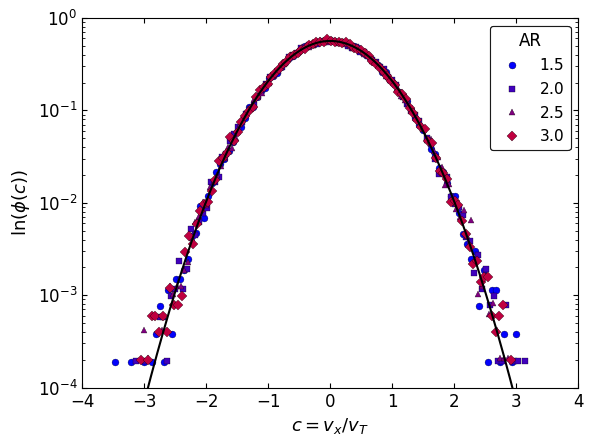

In [ ]:
fig, ax = plt.subplots()

ax.semilogy(c1, phi1, linestyle='None', marker=markers[0], color=colors[0], label=r'$1.5$')
ax.semilogy(c2, phi2, linestyle='None', marker=markers[1], color=colors[1], label=r'$2.0$')
ax.semilogy(c3, phi3, linestyle='None', marker=markers[2], color=colors[2], label=r'$2.5$')
ax.semilogy(c4, phi4, linestyle='None', marker=markers[3], color=colors[3], label=r'$3.0$')

# Maxwellian reference
ax.semilogy(c_ref, phi_MB, '-', linewidth=1.5, color='black')

ax.set_xlim([-4.0, 4.0])
ax.set_ylim([1e-4, 1])
ax.tick_params(axis='both', direction='in', which='both', right=True, top=True)

# Legend
legend1 = ax.legend(
    loc='upper right',
    bbox_to_anchor=(1.0, 1.0),
    fontsize=11,
    frameon=True,
    title=r'AR'
)
legend1.get_frame().set_edgecolor('black')
legend1.get_frame().set_linewidth(0.8)
ax.add_artist(legend1)

# Labels
ax.set_xlabel(r'$c = v_x / v_T$', fontsize=14)
ax.set_ylabel(r'$\ln(\phi(c))$', fontsize=14)

# Optional: remove aspect ratio override for clean shape
# ax.set_aspect(...)  ← remove this

mng = plt.get_current_fig_manager()
mng.full_screen_toggle()

plt.savefig('VDF.pdf', bbox_inches='tight')


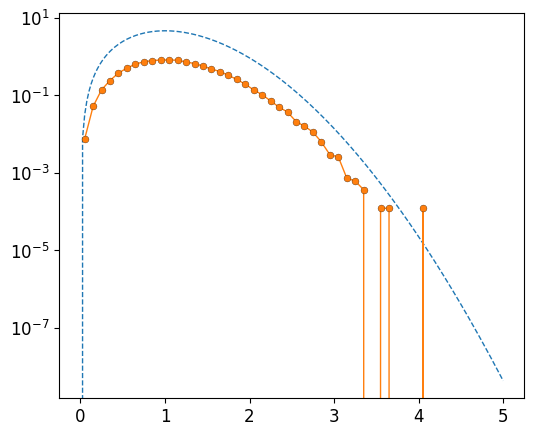

In [209]:
import numpy as np
import matplotlib.pyplot as plt

# === Set your VDF file path ===
vdf_file = "/home/muhammed/Documents/Thesis/New Simulations/figs/Journal_results/HCS/Realizations/AR20/R1COR95_vdf_Nt50.txt"

# === Load VDF data ===
try:
    data = np.loadtxt(vdf_file)
    c_vals = data[:, 0]  # Scaled speed c = |v| / v_T
    f_vals = data[:, 1]  # Normalized histogram values
except Exception as e:
    print(f"Error loading VDF file: {e}")
    raise

# === Plotting ===
plt.figure(figsize=(6, 5))
c = np.linspace(0, 5, 200)
phi_MB = 4*np.pi*c**2 * np.exp(-c**2)
plt.semilogy(c, phi_MB, linestyle='--', label='Maxwellian')


plt.semilogy(c_vals, f_vals, marker='o', label=r'$\alpha = 0.95$')  # for log scale

plt.show()

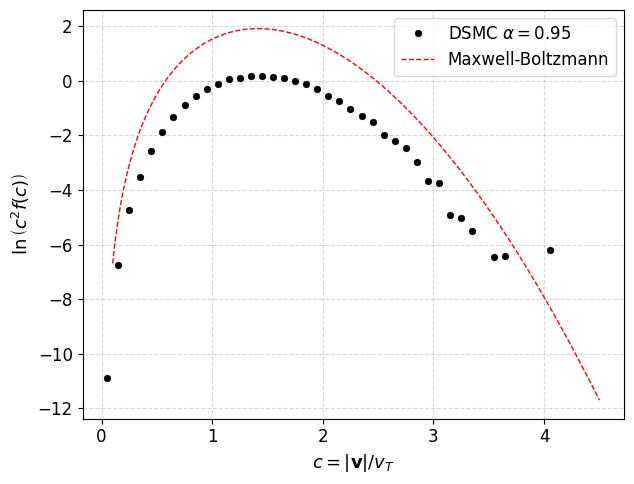

In [208]:
import numpy as np
import matplotlib.pyplot as plt

# === Load your VDF snapshot ===
vdf_file = "/home/muhammed/Documents/Thesis/New Simulations/figs/Journal_results/HCS/Realizations/AR20/R1COR95_vdf_Nt50.txt"
data = np.loadtxt(vdf_file)
c_vals = data[:, 0]
f_vals = data[:, 1]

# === Avoid log(0) issues ===
valid = (f_vals > 0) & (c_vals > 0)
c_plot = c_vals[valid]
phi_plot = f_vals[valid]
log_phi = np.log(c_plot**2 * phi_plot)

# === Optional: reference Maxwellian for visual comparison ===
c_theory = np.linspace(0.1, 4.5, 300)
phi_MB = 4*np.pi * c_theory**2 * np.exp(-c_theory**2)
log_phi_MB = np.log(c_theory**2 * phi_MB)  # Consistent with processing above

# === Plotting ===
plt.figure(figsize=(6.5, 5))
plt.plot(c_plot, log_phi, 'o', label=r'DSMC $\alpha=0.95$', color='black')
plt.plot(c_theory, log_phi_MB, '--', color='red', label='Maxwell-Boltzmann')

plt.xlabel(r'$c = |\mathbf{v}|/v_T$', fontsize=13)
plt.ylabel(r'$\ln\left(c^2 f(c)\right)$', fontsize=13)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(frameon=True)
plt.tight_layout()
plt.savefig("log_scaled_vdf_vs_maxwellian.pdf", bbox_inches='tight')
plt.show()


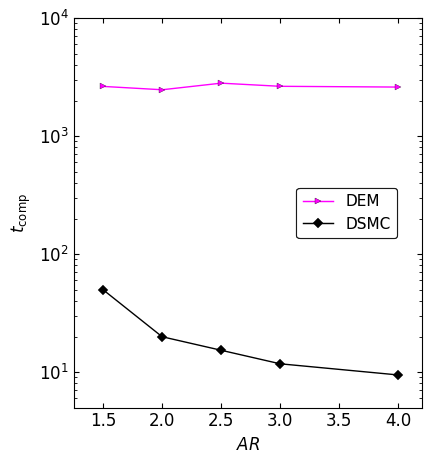

In [197]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()

# Data
AR = np.array([1.5, 2.0, 2.5, 3.0, 4.0])
DEM_time = np.array([2634.30, 2467.8, 2806.92, 2639.85, 2600.85])
DSMC_time = np.array([49.80, 19.92, 15.30, 11.75, 9.45])

# Plot
ax.plot(AR, DEM_time, marker='>', color='magenta', label='DEM')
ax.plot(AR, DSMC_time, marker='D', color='black', label='DSMC')

# Axis settings
ax.set_xscale('linear')
ax.set_yscale('log')
ax.set_xlim([1.25, 4.2])
ax.set_ylim([5e0, 1e4])

ax.set_xlabel(r'$AR$', fontsize=12)
ax.set_ylabel(r'$t_{\mathrm{comp}}$', fontsize=12)
ax.tick_params(axis='both', direction='in', which='both', right=True, top=True)

# Fix aspect ratio: equal length per data unit in screen space
from matplotlib.transforms import blended_transform_factory
tr = blended_transform_factory(ax.transData, ax.transData)
ax.set_aspect('equal', adjustable='box')

# Legend
legend1 = ax.legend(
    loc='center right',
    bbox_to_anchor=(0.95, 0.5),
    fontsize=11,
    frameon=True,
)
legend1.get_frame().set_edgecolor('black')
legend1.get_frame().set_linewidth(0.8)
ax.add_artist(legend1)

plt.tight_layout()
plt.savefig("tcomp.png", bbox_inches="tight")
plt.show()


In [ ]:
def load_and_process_Edata(file_path):
    E_data = np.loadtxt(file_path)
    pre_coll_energy = E_data[:, 0] + E_data[:, 1] + E_data[:, 2]
    post_coll_energy = E_data[:, 3] + E_data[:, 4] + E_data[:, 5]
    dissp_energy = (pre_coll_energy - post_coll_energy)/pre_coll_energy
    max_dissp = max(dissp_energy)
    dissp_energy2 = (dissp_energy/max_dissp)
    return dissp_energy2

file_list1 = [
    '/home/muhammed/Documents/Thesis/New Simulations/Alpha/95/20/Ef.txt',
    '/home/muhammed/Documents/Thesis/New Simulations/Alpha/80/20/Ef.txt',
]
label = [r'$\alpha = 0.95$', r'$\alpha=0.80$']

file_list2 = [
    '/home/muhammed/Documents/Thesis/New Simulations/Alpha/95/15/Ef.txt',
    '/home/muhammed/Documents/Thesis/New Simulations/Alpha/80/15/Ef.txt',
]
fig,ax = plt.subplots();
from matplotlib.ticker import FuncFormatter

# Custom formatter: return '0' for 0, otherwise default formatting
formatter1 = FuncFormatter(lambda x, _: '0' if x == 0 else f'{x:.1f}')
formatter2 = FuncFormatter(lambda x, _: '0' if x == 0 else f'{x:.1f}')
ax.yaxis.set_major_formatter(formatter1)
ax.xaxis.set_major_formatter(formatter2)

for j, file_path in enumerate(file_list1):
    dissp = load_and_process_Edata(file_path)
    hist_data, bin_edges = np.histogram(dissp, bins=50, density=True)
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    ax.scatter(bin_centers, hist_data, label=f'{label[j]}', marker=markers[j], color=colors[j])
    
for j, file_path in enumerate(file_list2):
    dissp = load_and_process_Edata(file_path)
    hist_data, bin_edges = np.histogram(dissp, bins=50, density=True)
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    ax.scatter(bin_centers, hist_data, label=f'{label[j]}', marker=markers[j+2], color=colors[j+2])

from scipy.stats import beta

a_fit = 1.211
b_fit = 3.672
loc_fit = 0  # Location parameter (already fitted to 0)
scale_fit = 1  # Scale parameter (already fitted to 1) 
gamma_vals = np.linspace(0, 1, 300)
beta_pdf = beta.pdf(gamma_vals, a_fit, b_fit, loc=loc_fit, scale=scale_fit)
ax.plot(gamma_vals, beta_pdf, color='black', linestyle='--', linewidth=1.5,
        label=r'$\mathrm{Beta}(\alpha=1.211,\ \beta=3.672)$')
    
ax.set_xlim([0,1.05])
ax.set_ylim([0,3.2])
ax.set_ylabel(r'f($\gamma$)')
ax.set_xlabel(r'$\gamma$')
xval, yval = ax.get_xlim(), ax.get_ylim()
xrange = xval[1]-xval[0];
yrange = yval[1]-yval[0];
ax.set_aspect(aspect*(xrange/yrange), adjustable='box')
ax.set_xticks([0, 0.5, 1.0])
ax.set_yticks([0, 1.6, 3.2])
ax.tick_params(axis='both',direction='in',which='both',right=True,top=True)
from matplotlib.lines import Line2D

beta_line = Line2D([0], [0], color='black', lw=1.5, linestyle='--',
                   label=r'$\mathrm{Beta}(1.21, 3.67)$')
legend3 = ax.legend(handles=[beta_line], loc='center right', bbox_to_anchor=(1.0, 0.35),fontsize=11, frameon=False)
ax.add_artist(legend3)

# Custom handles for AR=2.0
legend1_handles = [
    Line2D([0], [0], marker=markers[0], color='none', markerfacecolor=colors[0], label=r'$\alpha = 0.95$'),
    Line2D([0], [0], marker=markers[1], color='none', markerfacecolor=colors[1], label=r'$\alpha = 0.80$')
]

# Custom handles for AR=1.5
legend2_handles = [
    Line2D([0], [0], marker=markers[2], color='none', markerfacecolor=colors[2], label=r'$\alpha = 0.95$'),
    Line2D([0], [0], marker=markers[3], color='none', markerfacecolor=colors[3], label=r'$\alpha = 0.80$')
]

# Legend for AR=2.0
legend1 = ax.legend(handles=legend1_handles, title=r'AR = 2.0',
                    loc='upper right', bbox_to_anchor=(1.0, 1.0),
                    fontsize=10, title_fontsize=11, frameon=True)
legend1.get_frame().set_edgecolor('black')
legend1.get_frame().set_linewidth(0.8)
ax.add_artist(legend1)

# Legend for AR=1.5
legend2 = ax.legend(handles=legend2_handles, title=r'AR = 1.5',
                    loc='upper right', bbox_to_anchor=(0.7, 1.0),
                    fontsize=10, title_fontsize=11, frameon=True)
legend2.get_frame().set_edgecolor('black')
legend2.get_frame().set_linewidth(0.8)

mng = plt.get_current_fig_manager()
mng.full_screen_toggle()
plt.savefig('Gamma.eps',bbox_inches='tight')
plt.show()

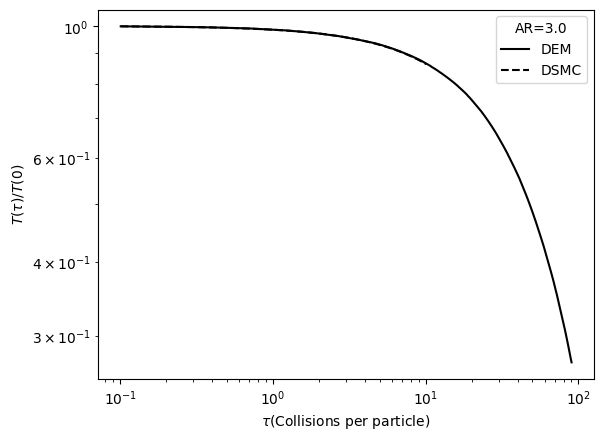

In [516]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as optimize
from scipy.stats import norm

def load_and_process_data(file_path):
    T2_Dem = np.loadtxt(file_path)
    delta_E_tr = np.diff(T2_Dem[1:, 2])
    return T2_Dem[1:, 0], T2_Dem[1:, 1], delta_E_tr / delta_E_tr[0], T2_Dem[1:,4], T2_Dem[1,4]

file_list = [
    '/home/muhammed/Documents/Thesis/New Simulations/HCS_DEM/kT_1_kTr_1/Alpha_095/AR20/T.txt'
]

for file_path in file_list:
    t, tau, delta_E_ratio, Temp, init_temp = load_and_process_data(file_path)
    plt.plot(tau, Temp/init_temp, color='black', linestyle= '-', label='DEM')

file_list = [
    '/home/muhammed/Documents/Thesis/New Simulations/DSMC_HCS/AR2/COR95/AR21COR95.txt'
]
for file_path in file_list:
    t, tau, delta_E_ratio, Temp, init_temp = load_and_process_data(file_path)
    plt.plot(tau, Temp/init_temp, color='black', linestyle='--', label='DSMC')

plt.xlabel(r'$\tau$(Collisions per particle)')
plt.yscale('log')
plt.xscale('log')
plt.ylabel(r'$T(\tau)/T(0)$')
#plt.grid()
#plt.title('AR')
plt.legend(title = 'AR=3.0', loc='best')
# Save the plot in .svg format
#plt.savefig('/home/muhammed/Documents/Negishi/Run_inelastic_p/T30.png', format='png', dpi=300)
plt.show()

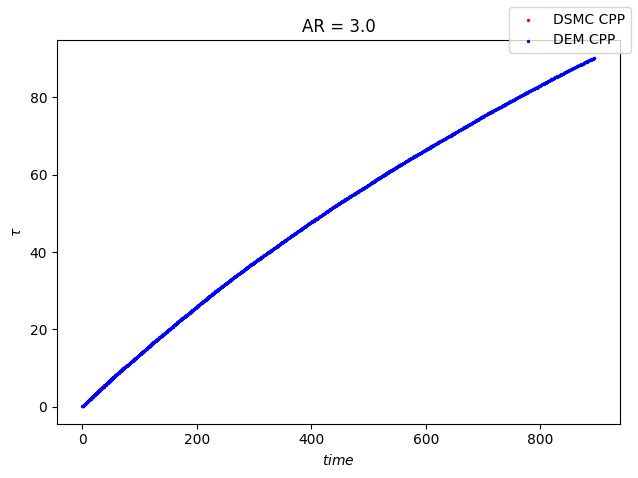

In [517]:
file_list = [
    '/home/muhammed/Documents/Thesis/New Simulations/DSMC_HCS/AR2/COR95/AR21COR95.txt'
]

fig, ax1 = plt.subplots()

x = np.linspace(0, 200, 2000)
for file_path in file_list:
    t, tau, delta_E_ratio, Temp, init_temp = load_and_process_data(file_path)
    ax1.scatter(t, tau, color='r',  s=2, label='DSMC CPP')
   

file_list = [
    '/home/muhammed/Documents/Thesis/New Simulations/HCS_DEM/kT_1_kTr_1/Alpha_095/AR20/T.txt'
]
for file_path in file_list:
    t, tau, delta_E_ratio, Temp, init_temp = load_and_process_data(file_path)
    ax1.scatter(t, tau, color='b',  s=2, label='DEM CPP')

ax1.set_xlabel(r'$time$')
#ax1.set_yscale('log')
#ax1.set_xscale('log')
ax1.set_ylabel(r'$\tau$')
ax1.set_title('AR = 3.0')

fig.tight_layout()
fig.legend(loc='upper right')
plt.show()

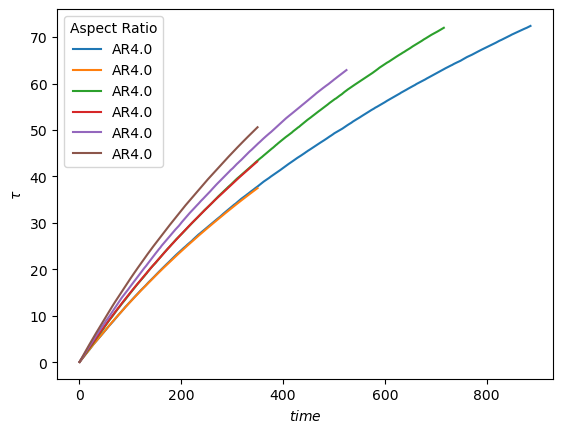

In [419]:
labels = ['AR1.5', 'AR2.0', 'AR2.5', 'AR3.0','AR4.0', 'AR5.0' ]
file_list = [
    '/home/muhammed/Documents/Thesis/New Simulations/HCS_DEM/kT_1_kTr_1/Alpha_09/AR20/T.txt',
    '/home/muhammed/Documents/Negishi/Run_inelastic_p/T20new3.txt',
    '/home/muhammed/Documents/Thesis/New Simulations/HCS_DEM/kT_1_kTr_1/Alpha_09/AR30/T.txt',
    '/home/muhammed/Documents/Negishi/Run_inelastic_p/T30new3.txt',
    '/home/muhammed/Documents/Thesis/New Simulations/HCS_DEM/kT_1_kTr_1/Alpha_09/AR40/T.txt',
    '/home/muhammed/Documents/Negishi/Run_inelastic_p/T40new3.txt'
]
for file_path in file_list:
    t, tau, delta_E_ratio, Temp, init_temp = load_and_process_data(file_path)
    plt.plot(t, tau, label=labels[i])

plt.xlabel(r'$time$')
#ax1.set_yscale('log')
#ax1.set_xscale('log')
plt.ylabel(r'$\tau$')
plt.legend(title='Aspect Ratio')
plt.show()

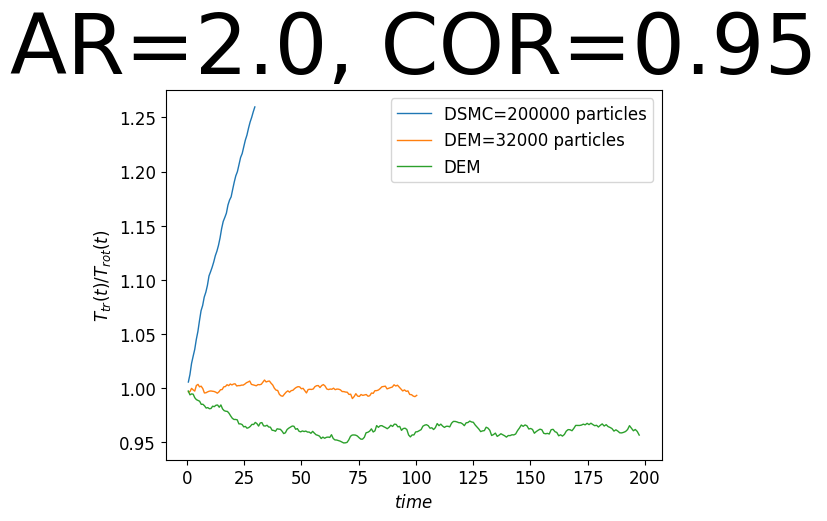

In [987]:
def load_marginals(file_path):
    T2_Dem = np.loadtxt(file_path)
    return T2_Dem[1:, 0], T2_Dem[1:,2], T2_Dem[1:,3]


labels = ['DSMC=200000 particles', 'DEM=32000 particles', 'DEM', 'AR3.0','AR4.0', 'AR5.0' ]
file_list = [
    #'/home/muhammed/Documents/Thesis/New Simulations/HCS_DEM/kT_1_kTr_1/Alpha_09/AR15/T.txt',
    #'/home/muhammed/Documents/Thesis/New Simulations/Py_scripts2/Results/T20simpleZr.txt',
    '/home/muhammed/Documents/Thesis/New Simulations/DSMC_HCS/AR2/COR95/AR21COR95.txt',
    '/home/muhammed/Documents/Thesis/New Simulations/DSMC_HCS/AR2/COR95/AR21COR95new.txt',
    '/home/muhammed/Documents/Thesis/New Simulations/DSMC_HCS/AR2/COR95/AR23COR95copy.txt',
    #'/home/muhammed/Documents/Thesis/New Simulations/Py_scripts2/Results/T20simple3.txt',
    #'/home/muhammed/Documents/Thesis/New Simulations/Rubio_largo/Alpha_88/AR2/T.txt',
    #'/home/muhammed/Documents/Negishi/Run_inelastic_p/T15new3.txt',
    #'/home/muhammed/Documents/Negishi/Run_inelastic_p/T30e.txt'
]
i=0

for file_path in file_list:
    t, E_trans, E_rot = load_marginals(file_path)
    frac_E = E_trans/E_rot
    plt.plot(t, frac_E, label=labels[i])
    i+=1

plt.xlabel(r'$time$')
plt.ylabel(r'$T_{tr}(t)/T_{rot}(t)$')
#plt.grid()
plt.title('AR=2.0, COR=0.95')
plt.legend(title='Aspect Ratio')
# Save the plot in .svg format
#plt.savefig('/home/muhammed/Documents/Negishi/Run_inelastic_p/T30.png', format='png', dpi=300)
plt.legend()
plt.show()

In [173]:
theta

0.4567

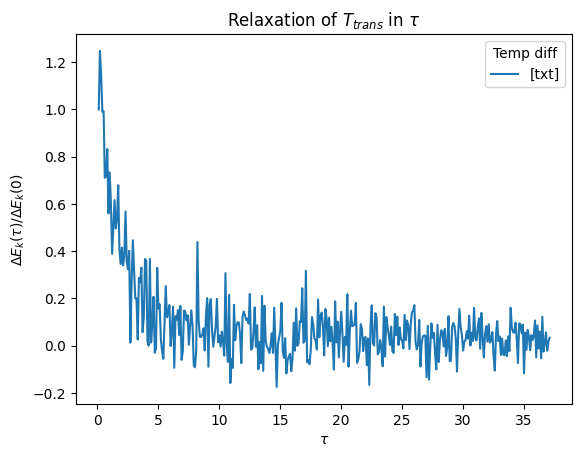

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as optimize

def load_and_process_data(file_path):
    T2_Dem = np.loadtxt(file_path)
    delta_E_tr = np.diff(T2_Dem[1:, 2])
    return T2_Dem[1:-1, 1], delta_E_tr / delta_E_tr[0]

file_list = [
    '/home/muhammed/Documents/Thesis/Simulation results/HCS_2Sphcyl_particles/kT_1_kTr_0/Alpha_09/AR20/T.txt'
]

plt.figure()
for file_path in file_list:
    t, delta_E_ratio = load_and_process_data(file_path)   
    plt.plot(t, delta_E_ratio, label=f'[{file_path.split("/")[-1].split(".")[-1]}]')

plt.legend(title='Temp diff')
plt.xlabel(r'$\tau$')
plt.ylabel(r'$\Delta{E_{k}(\tau)}/\Delta{E_{k}(0)}$')
plt.title(r'Relaxation of $T_{trans}$ in $\tau$')
plt.show()

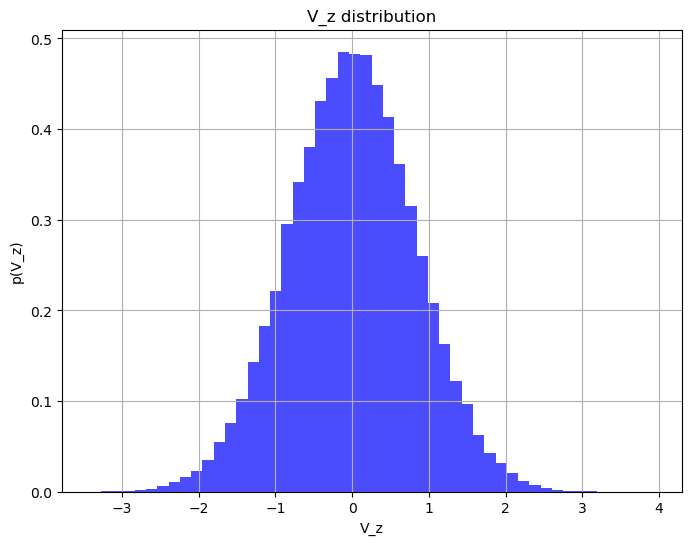

In [149]:
import matplotlib.pyplot as plt

# Extract the x-components of the velocities
x_components = vel[:, 0]  # Assuming the x-components are the first column

# Plot the histogram of the x-components
plt.figure(figsize=(8, 6))
plt.hist(x_components, bins=50, density=True, alpha=0.7, color='blue')  # Adjust bins as necessary

plt.xlabel('V_z')
plt.ylabel('p(V_z)')
plt.title('V_z distribution')

plt.grid(True)
plt.show()

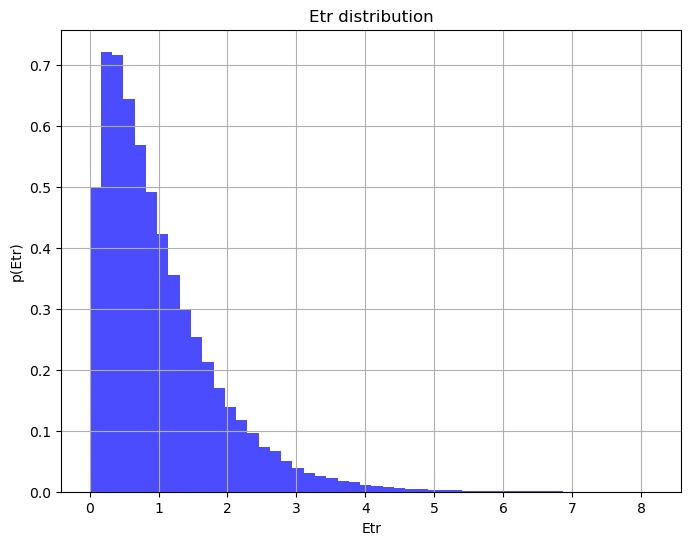

In [150]:
Et = np.zeros(Np)
for i in range(Np):
    Et[i] = 0.5 * mass * np.dot(vel[i, :], vel[i, :])

# Extract the x-components of the velocities
x_components = Et[:]  # Assuming the x-components are the first column

# Plot the histogram of the x-components
plt.figure(figsize=(8, 6))
plt.hist(x_components, bins=50, density=True, alpha=0.7, color='blue')  # Adjust bins as necessary

plt.xlabel('Etr')
plt.ylabel('p(Etr)')
plt.title('Etr distribution')

plt.grid(True)
plt.show()

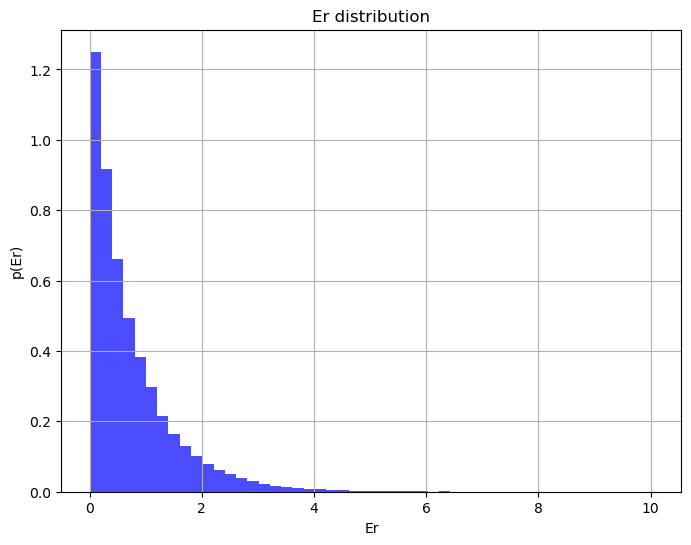

In [151]:
import matplotlib.pyplot as plt


# Extract the x-components of the velocities
x_components = Er[:]  # Assuming the x-components are the first column

# Plot the histogram of the x-components
plt.figure(figsize=(8, 6))
plt.hist(x_components, bins=50, density=True, alpha=0.7, color='blue')  # Adjust bins as necessary

plt.xlabel('Er')
plt.ylabel('p(Er)')
plt.title('Er distribution')

plt.grid(True)
plt.show()